# Signate開始時のお約束

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
signate_api_key = results.get('files', [])

filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=signate_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [3]:
!pip install signate

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=a4f03395f34ae0e5eba58a70c3f26c5a078772fcf647bb7794c51a541f54ac71
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [4]:
!signate files --competition-id=1523

  fileId  name               title                     size  updated_at
--------  -----------------  ----------------------  ------  -------------------
    3939  train.csv          学習用データ            494008  2024-08-01 12:00:28
    3940  test.csv           評価用データ            488363  2024-08-01 12:00:38
    3944  sample_submit.csv  応募用サンプルファイル   86893  2024-08-01 12:00:49
    4057  tutorial.ipynb     チュートリアルコード    323126  2024-08-01 12:01:00


In [5]:
!signate download --competition-id=1523

sample_submit.csv

tutorial.ipynb

test.csv

train.csv


Download completed.


In [6]:
!pip install kanjize

In [7]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 15.5 MB/s eta 0:00:00


In [8]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# データフレーム読み込み
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

In [9]:
# データ結合(番号を振り直す)
all_df = pd.concat([train_df,test_df],axis=0,ignore_index=True)
max_row = len(all_df)

In [10]:
# 元のカラム順
colorigin = all_df.columns

<ipython-input-11-8331b9fb236d>:45: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_df["Age"] = all_df["Age"].replace(-1,all_df.loc[all_df["Age"]>0,"Age"].median())


<Axes: >

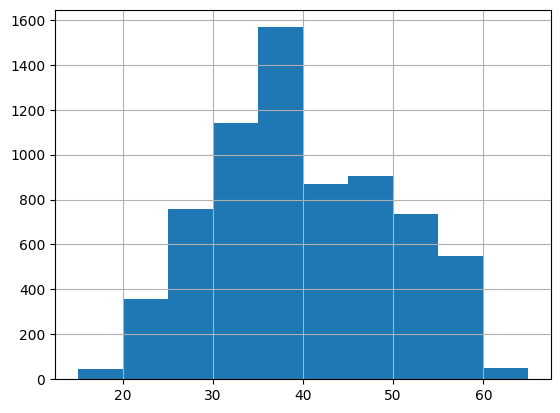

In [11]:
###############
# "Age"の処理 #
###############
import unicodedata # 全角を半角に変換
from kanjize import kanji2number # 漢字を数値に変換
import re

# 漢字の判定用
p = re.compile('[一二三四五六七八九十]+')

# nanを-1歳で補完
all_df["Age"] = all_df["Age"].fillna("-1歳")

# Ageの処理
for i in range(max_row):

  # 末尾文字の取得
  tail = all_df.loc[i,"Age"][-1:]

  # 先頭文字が漢字の場合
  if(p.search(all_df.loc[i,"Age"][0])!=None):
    tmp = all_df.loc[i,"Age"][:-1]
    all_df.loc[i,"Age"] = kanji2number(tmp)
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 末尾文字が歳、才、際の場合
  elif((tail=="歳")or(tail=="才")or(tail=="際")):
    all_df.loc[i,"Age"] = all_df.loc[i,"Age"][:-1]
    # 全角を半角に直す
    all_df.loc[i,"Age"] = unicodedata.normalize("NFKC", all_df.loc[i,"Age"])
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 代の場合
  elif(tail == "代"):
    tmp = all_df.loc[i,"Age"][:-1]

    # 「代」は○5歳に変換する
    tmp = int(tmp)
    # 10歳で分けて5足す
    tmp = tmp//10 * 10
    all_df.loc[i,"Age"] = tmp + 5
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

# 「-1」はそれ以外の中央値を代入
all_df["Age"] = all_df["Age"].replace(-1,all_df.loc[all_df["Age"]>0,"Age"].median())

# int型にキャストする
all_df["Age"] = all_df["Age"].astype(int)

# ヒストグラムを描く
all_df["Age"].hist()

In [12]:
#########################
# "TypeofContact"の処理 #
#########################
# 欠損は最頻値で補完する
all_df["TypeofContact"] = all_df["TypeofContact"].fillna("Self Enquiry")

# one-hot化して追加する
all_df.loc[all_df["TypeofContact"]=="Self Enquiry","TypeofContact"] = 0
all_df.loc[all_df["TypeofContact"]=="Company Invited","TypeofContact"] = 1

# 列名を変更
all_df = all_df.rename(columns={"TypeofContact":"CompanyInvited"})

print(all_df["CompanyInvited"].value_counts())

CompanyInvited
0    4462
1    2516
Name: count, dtype: int64


In [13]:
#########################
# "CityTier"の処理 #
#########################
print(all_df["CityTier"].value_counts())

CityTier
2    3160
1    2991
3     827
Name: count, dtype: int64


In [14]:
#########################
# "DurationOfPitch"の処理 #
#########################
# nanを-1分で補完
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].fillna("-1分")

# 秒を分に変換 #
for i in range(max_row):

  tail = str(all_df.loc[i,"DurationOfPitch"])[-1:]

  if(tail == "秒"):
    tmp = all_df.loc[i,"DurationOfPitch"][:-1]
    all_df.loc[i,"DurationOfPitch"] = float(tmp) / 60.0
  elif(tail == "分"):
    all_df.loc[i,"DurationOfPitch"] = all_df.loc[i,"DurationOfPitch"][:-1]

all_df["DurationOfPitch"] = all_df["DurationOfPitch"].astype("float64")

# 「-1」はそれ以外の中央値を代入
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].replace(-1,all_df.loc[all_df["DurationOfPitch"]>0,"DurationOfPitch"].median())

# 重要でないため、10分刻みのカテゴリにする
all_df["DurationOfPitch"] = (all_df["DurationOfPitch"].values // 10).astype(int)

# 分布を確認する
print(all_df["DurationOfPitch"].value_counts())

DurationOfPitch
1    3824
0    1984
2     709
3     461
Name: count, dtype: int64


In [15]:
####################
# "Occupation"の処理 #
####################
# 特徴量を追加する
all_df["SmallBusiness"] = 0
all_df["Salaried"] = 0
all_df["LargeBusiness"] = 0

# one-hot化して追加する
all_df.loc[all_df["Occupation"]=="Small Business","SmallBusiness"] = 1
all_df.loc[all_df["Occupation"]=="Salaried","Salaried"] = 1
all_df.loc[all_df["Occupation"]=="Large Business","LargeBusiness"] = 1

# 元のカラムを削除する
all_df = all_df.drop("Occupation", axis=1)

print(all_df["SmallBusiness"].value_counts())
print(all_df["Salaried"].value_counts())
print(all_df["LargeBusiness"].value_counts())

SmallBusiness
0    3522
1    3456
Name: count, dtype: int64
Salaried
0    4177
1    2801
Name: count, dtype: int64
LargeBusiness
0    6257
1     721
Name: count, dtype: int64


In [16]:
##################
# "Genger"の処理 #
##################
# 先頭文字がMかmならMaleになる
for i in range(max_row):

  # 先頭文字の取得(半角)
  head = unicodedata.normalize("NFKC", all_df.loc[i,"Gender"][:1])
  if(head == "m"):
    all_df.loc[i,"Gender"] = "Male"
  else:
    all_df.loc[i,"Gender"] = "Female"

# one-hot化して追加する
all_df.loc[all_df["Gender"]=="Male","Gender"] = 1
all_df.loc[all_df["Gender"]=="Female","Gender"] = 0

# 列名を変更する
all_df = all_df.rename(columns={"Gender":"Male"})

print(all_df["Male"].value_counts())

Male
0    5946
1    1032
Name: count, dtype: int64


In [17]:
##################################
# "NumberOfPersonVisiting"の処理 #
##################################
print(all_df["NumberOfPersonVisiting"].value_counts())

NumberOfPersonVisiting
2.0    3163
3.0    2773
1.0     686
4.0     356
Name: count, dtype: int64


In [18]:
##################################
# "NumberOfFollowups"の処理 #
##################################

# 欠損を-1で埋めてから中央値を取る
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].fillna(-1)
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].replace(-1,all_df.loc[all_df["NumberOfFollowups"]>0,"NumberOfFollowups"].median())

# 100回以上は記録違いとして100で割る
all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] = all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] / 100

# 分布の確認
print(all_df["NumberOfFollowups"].value_counts())

NumberOfFollowups
4.0    2834
3.0    2561
5.0    1122
2.0     213
1.0     178
6.0      70
Name: count, dtype: int64


In [19]:
##########################
# "ProductPitched"の処理 #
##########################
# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdib"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

# Basic, Standard, Deluxe, Super Deluxe, kingに分ける
prefix = 0
others = []
# すべて小文字に変換し判定
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"ProductPitched"][:2].lower())).lower()

  if(prefix == "ba"):
    all_df.loc[i,"ProductPitched"] = "Basic"

  elif(prefix == "st"):
    all_df.loc[i,"ProductPitched"] = "Standard"

  elif(prefix == "de"):
    all_df.loc[i,"ProductPitched"] = "Deluxe"

  elif(prefix == "su"):
    all_df.loc[i,"ProductPitched"] = "SuperDeluxe"

  elif(prefix == "ki"):
    all_df.loc[i,"ProductPitched"] = "King"

  else:
    others.append(i)

# ラベルエンコード
all_df.loc[all_df["ProductPitched"]=="Basic","ProductPitched"] = 1
all_df.loc[all_df["ProductPitched"]=="Standard","ProductPitched"] = 2
all_df.loc[all_df["ProductPitched"]=="Deluxe","ProductPitched"] = 3
all_df.loc[all_df["ProductPitched"]=="SuperDeluxe","ProductPitched"] = 4
all_df.loc[all_df["ProductPitched"]=="King","ProductPitched"] = 5

# 分布の確認
print(all_df["ProductPitched"].value_counts())

ProductPitched
1    2347
3    2091
2    1614
4     640
5     286
Name: count, dtype: int64


In [20]:
#################################
# "PreferredPropertyStar"の処理 #
#################################
# 順番に意味があるので2引く
all_df["PreferredPropertyStar"] = all_df["PreferredPropertyStar"] - 2

# 分布を確認する
all_df["PreferredPropertyStar"].value_counts()

,count
PreferredPropertyStar,
1.0,4328
2.0,2254
3.0,396


In [21]:
#########################
# "NumberOfTrips"の処理 #
#########################
# nanは-1で補完
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].fillna("-1")

# 一旦オブジェクト型に変更
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].astype("object")

for i in range(max_row):

  # 先頭文字の取得(半角)
  head = all_df.loc[i,"NumberOfTrips"][:1]

  if(head == "年"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][2:3]

  elif(head == "半"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][3:4]

  elif(head == "四"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][4:5]

# int型に変更
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].astype("int")

# 「-1」はそれ以外の中央値を代入
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].replace(-1,all_df.loc[all_df["NumberOfTrips"]>0,"NumberOfTrips"].median())

# 3グループに分割する
all_df.loc[all_df["NumberOfTrips"]<4,"NumberOfTrips"] = 1
all_df.loc[(all_df["NumberOfTrips"]>=4)& (all_df["NumberOfTrips"]<6),"NumberOfTrips"] = 2
all_df.loc[all_df["NumberOfTrips"]>=6,"NumberOfTrips"] = 3

# 分布を確認する
all_df["NumberOfTrips"].value_counts()

,count
NumberOfTrips,
1,4854
2,1304
3,820


In [22]:
#########################
# "Passport"の処理 #
#########################
print(all_df["Passport"].value_counts())

Passport
0    6288
1     690
Name: count, dtype: int64


In [23]:
##################################
# "PitchSatisfactionScore"の処理 #
##################################
print(all_df["PitchSatisfactionScore"].value_counts())

PitchSatisfactionScore
2    2500
4    1452
1    1439
3    1344
5     243
Name: count, dtype: int64


In [24]:
#########################
# "Designation"の処理 #
#########################

# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡Аае"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdibaae"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

# 文字を変換する
prefix = 0
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"Designation"][:1].lower())).lower()

  # Executive: 取締役、執行役員
  if(prefix == "e"):
    all_df.loc[i,"Designation"] = "Executive"

  # Vice President: 本部長
  elif(prefix == "v"):
    all_df.loc[i,"Designation"] = "VP"

  # Associate Vice President: 本部長補佐
  elif(prefix == "a"):
    all_df.loc[i,"Designation"] = "AVP"

  # Senior Manager: 次長
  elif(prefix == "s"):
    all_df.loc[i,"Designation"] = "Senior Manager"

  # Manager: 課長
  elif(prefix == "m"):
    all_df.loc[i,"Designation"] = "Manager"

# ラベルエンコード
all_df.loc[all_df["Designation"]=="Executive","Designation"] = 5
all_df.loc[all_df["Designation"]=="VP","Designation"] = 4
all_df.loc[all_df["Designation"]=="AVP","Designation"] = 3
all_df.loc[all_df["Designation"]=="Senior Manager","Designation"] = 2
all_df.loc[all_df["Designation"]=="Manager","Designation"] = 1

# 分布の確認
all_df["Designation"].value_counts()

,count
Designation,
5,2330
1,2117
2,1632
3,635
4,264


<Axes: >

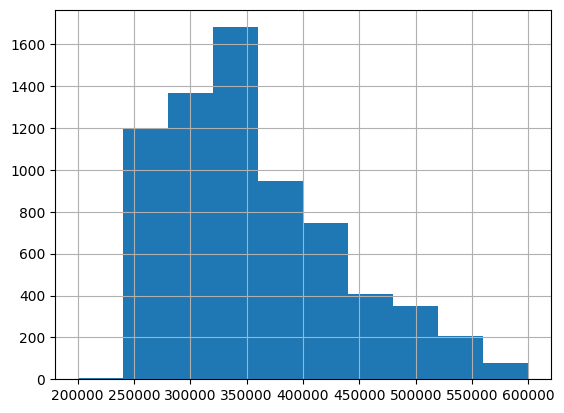

In [25]:
#########################
# "MonthlyIncome"の処理 #
#########################
import re

# 漢字の判定用
p = re.compile('[月]+')

# nanを-1で補完
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].fillna("-1")

for i in range(max_row):

  # 先頭文字の取得
  head = all_df.loc[i,"MonthlyIncome"][:1]

  # 先頭文字が漢字の場合
  if(p.search(head[0])!=None):
    tmp = all_df.loc[i,"MonthlyIncome"][2:-2]
    all_df.loc[i,"MonthlyIncome"] = float(tmp)*10000

# float型にキャストする
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].astype(float)

# 「-1」はそれ以外の中央値を代入
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].replace(-1,all_df.loc[all_df["MonthlyIncome"]>0,"MonthlyIncome"].median())

# 分布の確認
all_df["MonthlyIncome"].hist()

In [26]:
#########################
# "customer_info"の処理 #
#########################
import re

# 項目名
cont = []

# 区切り文字で分割する
for i in range(max_row):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      if(tmp[j] not in cont):
        cont.append(tmp[j])

# キーワード抽出
c_car = [] # 車関係
c_child = [] # 子供関係
c_married = [] # 婚姻関係
c_other = [] # その他

for i in range(len(cont)):
  # 「車あり」、「車所持」、「自家用車あり」、「車保有」、「乗用車所持」、「自動車保有」
  # 「車なし」、「車未所持」、「自家用車なし」、「車保有なし」、「乗用車なし」、「自動車未所有」
  if((cont[i][0:1] == "車") or (cont[i][0:1] == "自") or (cont[i][0:1] == "乗")):
    c_car.append(cont[i])
  # 「こども1人」、「1児」、「子供1人」、「子供有り(1人)」、「子供有り」
  # 「こども2人」、「2児」、「子供2人」、「子供有り(2人)」
  # 「こども3人」、「3児」「子供3人」、「子供有り(3人)」
  # 「子供なし」、「子供無し」、「無子」、「子供ゼロ」、「非児童家庭」
  # 「子育て状況不明」、「子の数不詳」、「子供の数不明」
  elif((cont[i][0:1] == "子") or (cont[i][0:1] == "こ") or (cont[i][-1:] == "児") or (cont[i][-1:] == "子") or (cont[i][-1:] == "庭")):
    c_child.append(cont[i])
  # 「結婚済み」、「離婚済み」、「未婚」、「独身」
  elif((cont[i][0:1] == "結") or (cont[i][0:1] == "離") or (cont[i][0:1] == "独") or (cont[i][0:1] == "離") or (cont[i][0:1] == "未")):
    c_married.append(cont[i])
  # 「1人」、「2人」、「3人」、「不明」、「わからない」
  else:
    c_other.append(cont[i])

In [27]:
# 新たなカラムを追加
all_df["CarHolder"] = 0 # 車所有
all_df["NumofChild"] = 0 # 子供の数
all_df["Married"] = "Single" # 婚姻歴

# 車
c_car_hold = ["車あり","車所持","自家用車あり","車保有","乗用車所持","自動車保有"]

# 子供
c_child_1 = ["こども1人","1児""子供1人","子供有り(1人)","子供有り"]
c_child_2 = ["こども2人","2児""子供2人","子供有り(2人)"]
c_child_3 = ["こども3人","3児""子供3人","子供有り(3人)"]

# 婚姻状況
c_pair = ["結婚済み"]
c_batu = ["離婚済み"]

# 区切り文字で分割する
for i in range(max_row):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      # 車の情報
      if(tmp[j] in c_car_hold):
        all_df.loc[i, "CarHolder"] = 1
      # 子供の情報
      if(tmp[j] in c_child_1):
        all_df.loc[i, "NumofChild"] = 1
      if(tmp[j] in c_child_2):
        all_df.loc[i, "NumofChild"] = 2
      if(tmp[j] in c_child_3):
        all_df.loc[i, "NumofChild"] = 3
      # 婚姻歴
      if(tmp[j] in c_pair):
        all_df.loc[i, "Married"] = "Married"
      if(tmp[j] in c_batu):
        all_df.loc[i, "Married"] = "Divorce"

# 使用済みカラム抹消
all_df = all_df.drop("customer_info", axis=1)

In [28]:
# 車保有率
print(all_df["CarHolder"].value_counts())

CarHolder
0    4408
1    2570
Name: count, dtype: int64


In [29]:
# 子供の数
print(all_df["NumofChild"].value_counts())

NumofChild
0    5015
1    1347
2     571
3      45
Name: count, dtype: int64


In [30]:
# 婚姻歴

# 特徴量を追加する
all_df["Family"] = 0
all_df["Single"] = 0
all_df["Divorce"] = 0

# one-hot化して追加する
all_df.loc[all_df["Married"]=="Married","Family"] = 1
all_df.loc[all_df["Married"]=="Single","Single"] = 1
all_df.loc[all_df["Married"]=="Divorce","Divorce"] = 1

# 元のカラムを削除する
all_df = all_df.drop("Married", axis=1)

print(all_df["Family"].value_counts())
print(all_df["Single"].value_counts())
print(all_df["Divorce"].value_counts())

Family
0    4132
1    2846
Name: count, dtype: int64
Single
0    4534
1    2444
Name: count, dtype: int64
Divorce
0    5290
1    1688
Name: count, dtype: int64


In [31]:
all_df.columns

Index(['id', 'Age', 'CompanyInvited', 'CityTier', 'DurationOfPitch', 'Male',
       'NumberOfPersonVisiting', 'NumberOfFollowups', 'ProductPitched',
       'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'ProdTaken',
       'SmallBusiness', 'Salaried', 'LargeBusiness', 'CarHolder', 'NumofChild',
       'Family', 'Single', 'Divorce'],
      dtype='object')

In [32]:
# 順番を整列させる
col = ['id', 'Age', "CompanyInvited", 'CityTier', 'DurationOfPitch',
       'SmallBusiness', 'Salaried', 'LargeBusiness',
       'Male', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', "CarHolder",
       "NumofChild", 'Family', 'Single', 'Divorce',
       'ProdTaken']

all_df = all_df.reindex(columns=col)

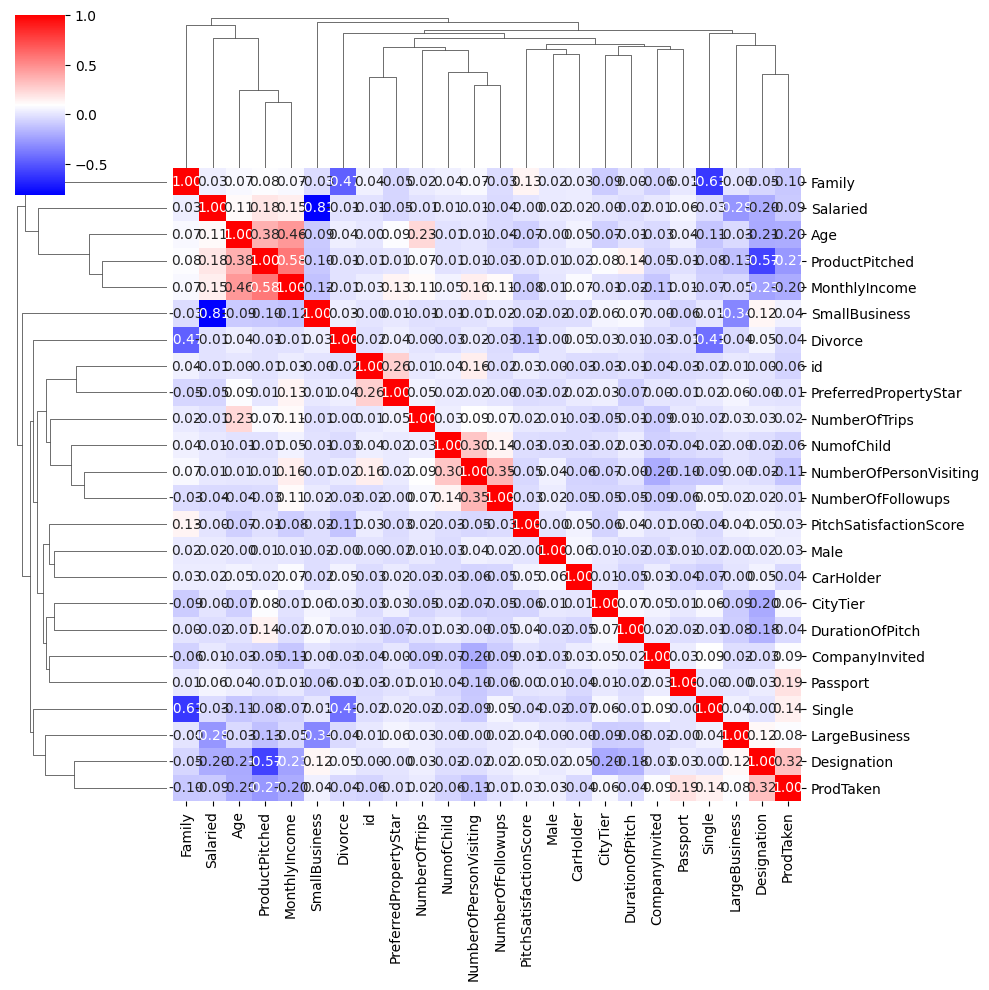

In [33]:
# 相関係数を確認する
import seaborn as sns
import matplotlib.pyplot as plt

all_df_corr = all_df.corr()
sns.clustermap(all_df_corr,annot=True,fmt=".2f",cmap="bwr")
plt.show()

In [34]:
# "Salaried" と "SmallBusiness" が0.6 超えるため、サラリーマンかそうでないかに分ける
all_df = all_df.drop("SmallBusiness", axis=1)
all_df = all_df.drop("LargeBusiness", axis=1)

In [35]:
# "Family" と "Single" が0.6 超えるため、独身かそうでないかに分ける
all_df = all_df.drop("Family", axis=1)
all_df = all_df.drop("Divorce", axis=1)

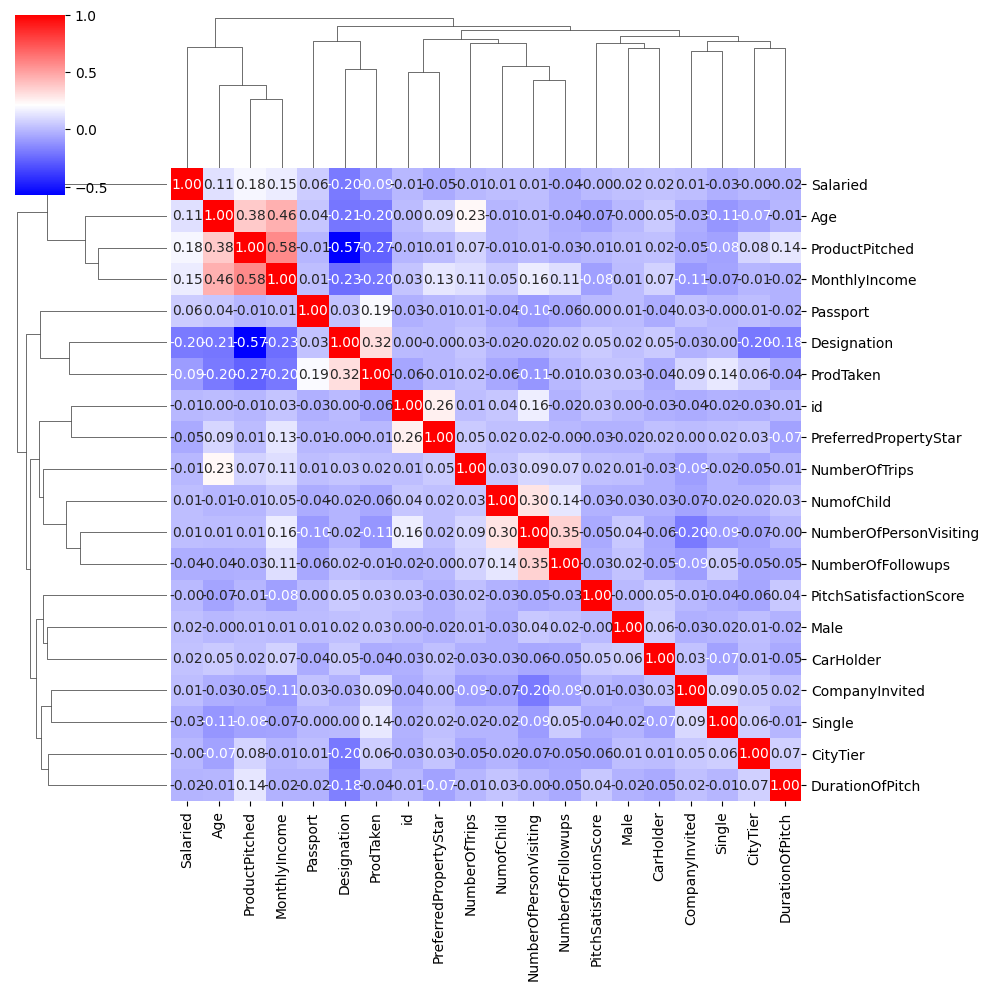

In [36]:
# 相関係数がすべて0.6未満に収まったので次のステップに進む
all_df_corr = all_df.corr()
sns.clustermap(all_df_corr,annot=True,fmt=".2f",cmap="bwr")
plt.show()

# 特徴量エンジニアリング

In [ ]:
plus = all_df[all_df["ProdTaken"]==1] # 正例
minus = all_df[all_df["ProdTaken"]==0]  # 負例
train = pd.concat([plus,minus])
# 全体数の比
print("正例：", len(plus))
print("負例：", len(minus))
print("比率：", len(minus)/len(plus))

正例： 497
負例： 2992
比率： 6.020120724346077


In [ ]:
train.groupby("ProdTaken").mean()

,id,Age,CompanyInvited,CityTier,DurationOfPitch,Salaried,Male,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,CarHolder,NumofChild,Single
ProdTaken,,,,,,,,,,,,,,,,,,,
0.0,1769.117313,40.188503,0.352273,1.680816,0.953209,0.420455,0.141711,2.428142,3.674465,2.382687,1.442513,1.414773,0.078543,2.500000,2.629011,361609.074198,0.384693,0.384358,0.323529
1.0,1592.790744,34.625755,0.472837,1.794769,0.863179,0.287726,0.17505,2.193159,3.657948,1.519115,1.432596,1.454728,0.247485,2.597586,4.136821,318393.682093,0.323944,0.279678,0.521127


In [ ]:
# パスポート所持率が高い
# 若い(34.6歳 VS 40.2歳)、事業主(28.8% VS 42.0%)、パスポート(24.7% VS 7.9%)、月給(31.8万 VS 36.2万)、独身(52.1% VS 32.4%)
data1 = train.loc[train["ProdTaken"]==1].mean()
data0 = train.loc[train["ProdTaken"]==0].mean()
data0 = data0.drop("ProdTaken", axis=0)
data1 = data1.drop("ProdTaken", axis=0)
print(data1/data0)

id                        0.900331
Age                       0.861584
CompanyInvited            1.342247
CityTier                  1.067796
DurationOfPitch           0.905551
Salaried                  0.684322
Male                      1.235261
NumberOfPersonVisiting    0.903225
NumberOfFollowups         0.995505
ProductPitched            0.637564
PreferredPropertyStar     0.993125
NumberOfTrips             1.028242
Passport                  3.150957
PitchSatisfactionScore    1.039034
Designation               1.573528
MonthlyIncome             0.880491
CarHolder                 0.842085
NumofChild                0.727649
Single                    1.610755
dtype: object


# 学習準備

In [ ]:
#-------------------------------------------------------------------------------------------
# カテゴリ列 x 13
# CompanyInvited, CityTier, DurationOfPitch, Salaried, Male, ProductPitched, PreferredPropertyStar,
# NumberOfTrips, Passport, PitchSatisfactionScore, Designation, CarHolder, Single
# 数値列 x 5
# Age, NumberOfPersonVisiting, NumberOfFollowups, MonthlyIncome, NumofChild
#-------------------------------------------------------------------------------------------
all_df.columns

Index(['id', 'Age', 'CompanyInvited', 'CityTier', 'DurationOfPitch',
       'Salaried', 'Male', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'CarHolder',
       'NumofChild', 'Single', 'ProdTaken'],
      dtype='object')

In [ ]:
# まずはseed複数のスコア平均を取る環境を作ること

In [ ]:
# 契約する人
# 若い(34.6歳 VS 40.2歳)、事業主(28.8% VS 42.0%)、パスポート(24.7% VS 7.9%)、月給(31.8万 VS 36.2万)、独身(52.1% VS 32.4%)

In [37]:
# # クロス特徴量の追加
# 「役職」x「商品ランク」
all_df["Designation_ProductPitched"] = all_df["Designation"] * all_df["ProductPitched"]

# 「パスポート」x「役職」
# all_df["Passport_Designation"] = all_df["Passport"] & all_df["Designation"]

# 「会社招待」x「独身」
# all_df["CompanyInvited_Single"] = all_df["CompanyInvited"] & all_df["Single"]


In [ ]:
# 古い列を削除
all_df = all_df.drop("CompanyInvited_Single", axis=1)

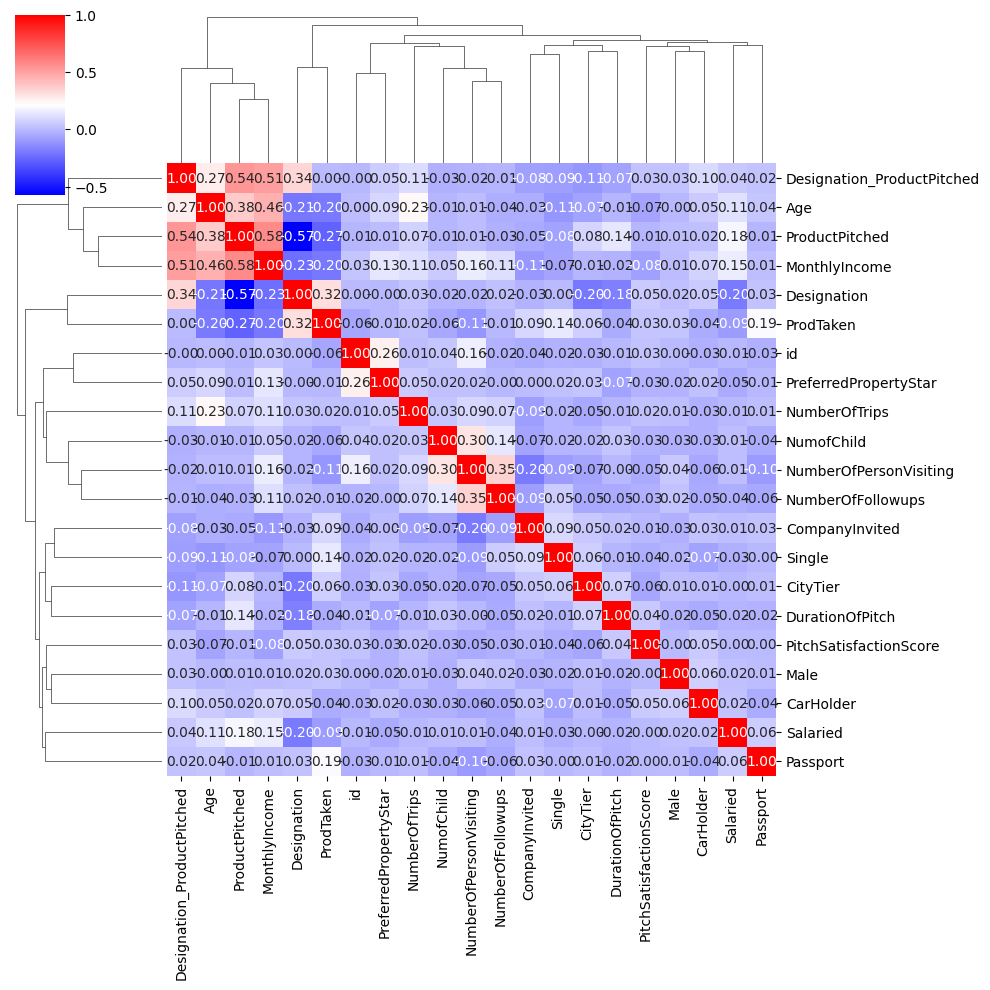

In [38]:
# 相関係数の確認OK
all_df_corr = all_df.corr()
sns.clustermap(all_df_corr,annot=True,fmt=".2f",cmap="bwr")
plt.show()

In [39]:
# 古い列を削除
all_df = all_df.drop("DurationOfPitch", axis=1)

In [40]:
all_df.columns

Index(['id', 'Age', 'CompanyInvited', 'CityTier', 'Salaried', 'Male',
       'NumberOfPersonVisiting', 'NumberOfFollowups', 'ProductPitched',
       'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'CarHolder',
       'NumofChild', 'Single', 'ProdTaken', 'Designation_ProductPitched'],
      dtype='object')

In [ ]:
# 古い列を削除
# all_df = all_df.drop("Salaried", axis=1)

In [41]:
# 順番を整列させる
# col = ['id', 'Age', 'CompanyInvited', 'CityTier', 'DurationOfPitch',
#        'Salaried', 'Male', 'NumberOfPersonVisiting', 'NumberOfFollowups',
#        'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
#        'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'CarHolder',
#        'NumofChild', 'Single', 'ProdTaken']

col = ['id', 'Age', 'CompanyInvited', 'CityTier', 'Designation_ProductPitched',
       'Salaried', 'Male', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'CarHolder',
       'NumofChild', 'Single', 'ProdTaken']

all_df = all_df.reindex(columns=col)

In [42]:
all_df.columns

Index(['id', 'Age', 'CompanyInvited', 'CityTier', 'Designation_ProductPitched',
       'Salaried', 'Male', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'CarHolder',
       'NumofChild', 'Single', 'ProdTaken'],
      dtype='object')

# ここから学習作業

In [43]:
# 取り除く変数
RMV = ["id","ProdTaken"]
RMV2 = ["id"]

FEATURES = [c for c in all_df.columns if c not in RMV2]
TARGET = "ProdTaken"

In [44]:
CATS = []
for c in FEATURES:
  if all_df[c].dtype == "object":
    CATS.append(c)
print(CATS)

['CompanyInvited', 'Designation_ProductPitched', 'Male', 'ProductPitched', 'Designation']


In [45]:
# オブジェクト型はint型に変換する
all_df[CATS] = all_df[CATS].astype(int)

In [46]:
# カラムを制限
all_df2 = all_df[FEATURES]

# 結合を戻す
train = all_df2.iloc[:len(train_df)].copy()
test = all_df2.iloc[len(train_df):].reset_index(drop=True).copy()

# 対象の列のみ取り込み
test = test.drop(TARGET,axis=1)
FEATURES = test.columns

In [47]:
# Optunaを使用する
import optuna
import lightgbm as lgb
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold

oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))
models = []
evaluations_result = {}

FOLDS = 5 # 分割数
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

def objective(trial):

  lgbm_params = {
      'objective': 'binary',
      "device": "cpu",
      'metric': 'auc',
      'verbose': -1,              # ログ出力の制御
      'boosting_type': 'gbdt',
      'learning_rate': 0.01,
      'n_estimators': 3000,

      'num_leaves': trial.suggest_int('num_leaves', 16, 256),
      'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
      'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
      'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1),
      'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
      'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0,log=True),
      'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0,log=True),
      'max_depth': trial.suggest_int('max_depth', 3, 12),

      # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
      }

  for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    # インデックスに割り振る

    x_train = train.loc[train_index, FEATURES].copy()
    y_train = train.loc[train_index, TARGET]
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = train.loc[test_index, TARGET]
    # x_test = test[FEATURES].copy()

    # データセット作成
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

    # 学習
    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          num_boost_round = 2000,
                          valid_sets = [lgb_train, lgb_eval],
                          valid_names = ["train", "valid"],
                          callbacks = [
                              lgb.early_stopping(stopping_rounds=100, verbose=False),
                              # lgb.record_evaluation(evaluations_result),
                              lgb.log_evaluation(100),])

    oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)

  score = roc_auc_score(train[TARGET],oof_lgb)

  return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2025-05-27 13:26:33,694] A new study created in memory with name: no-name-bae218a4-4a1c-422e-89ab-d88c849964b4
<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 1
#########################
[100]	train's auc: 0.831597	valid's auc: 0.822174
#########################
### Fold 2
#########################
[100]	train's auc: 0.829254	valid's auc: 0.82138
[200]	train's auc: 0.838189	valid's auc: 0.829197


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.844832	valid's auc: 0.839824
[400]	train's auc: 0.849385	valid's auc: 0.845435
[500]	train's auc: 0.852813	valid's auc: 0.847224
[600]	train's auc: 0.855497	valid's auc: 0.84903
[700]	train's auc: 0.857905	valid's auc: 0.849783
[800]	train's auc: 0.860191	valid's auc: 0.849799
[900]	train's auc: 0.862357	valid's auc: 0.850167
#########################
### Fold 3
#########################
[100]	train's auc: 0.838709	valid's auc: 0.793418


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.84769	valid's auc: 0.801825
[300]	train's auc: 0.852981	valid's auc: 0.804135
[400]	train's auc: 0.8578	valid's auc: 0.804169
#########################
### Fold 4
#########################
[100]	train's auc: 0.834729	valid's auc: 0.826478
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.833106	valid's auc: 0.797085
[200]	train's auc: 0.844648	valid's auc: 0.805302
[300]	train's auc: 0.850969	valid's auc: 0.811966
[400]	train's auc: 0.855541	valid's auc: 0.814719
[500]	train's auc: 0.859055	valid's auc: 0.81754
[600]	train's auc: 0.861648	valid's auc: 0.819398


[I 2025-05-27 13:26:36,097] Trial 0 finished with value: 0.8076594594303791 and parameters: {'num_leaves': 77, 'min_data_in_leaf': 53, 'feature_fraction': 0.7375711163356679, 'bagging_fraction': 0.8787013223091541, 'bagging_freq': 3, 'lambda_l1': 6.128657774155402, 'lambda_l2': 0.32212132703631624, 'max_depth': 3}. Best is trial 0 with value: 0.8076594594303791.


[700]	train's auc: 0.863544	valid's auc: 0.820378
[800]	train's auc: 0.865449	valid's auc: 0.821324
#########################
### Fold 1
#########################


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.86097	valid's auc: 0.833161
[200]	train's auc: 0.878976	valid's auc: 0.839933
[300]	train's auc: 0.893758	valid's auc: 0.83597
#########################
### Fold 2
#########################
[100]	train's auc: 0.856131	valid's auc: 0.83143


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.875239	valid's auc: 0.841839
[300]	train's auc: 0.891417	valid's auc: 0.845987
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867428	valid's auc: 0.798882
[200]	train's auc: 0.882145	valid's auc: 0.801555
[300]	train's auc: 0.897142	valid's auc: 0.807052
[400]	train's auc: 0.910655	valid's auc: 0.807002
[500]	train's auc: 0.92101	valid's auc: 0.804337
#########################
### Fold 4
#########################
[100]	train's auc: 0.862621	valid's auc: 0.82577


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.880798	valid's auc: 0.826394
[300]	train's auc: 0.895887	valid's auc: 0.827288
#########################
### Fold 5
#########################
[100]	train's auc: 0.866696	valid's auc: 0.810091


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-27 13:26:38,438] Trial 1 finished with value: 0.8205385387189447 and parameters: {'num_leaves': 218, 'min_data_in_leaf': 63, 'feature_fraction': 0.7775813067081101, 'bagging_fraction': 0.643953168682261, 'bagging_freq': 7, 'lambda_l1': 8.308720878667268e-06, 'lambda_l2': 4.150184857246574e-06, 'max_depth': 8}. Best is trial 1 with value: 0.8205385387189447.
<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Wil

#########################
### Fold 1
#########################
[100]	train's auc: 0.842141	valid's auc: 0.838445
[200]	train's auc: 0.859362	valid's auc: 0.83995
[300]	train's auc: 0.870954	valid's auc: 0.838696
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.842496	valid's auc: 0.827391
[200]	train's auc: 0.855789	valid's auc: 0.838796
[300]	train's auc: 0.868883	valid's auc: 0.843094
[400]	train's auc: 0.878743	valid's auc: 0.845819
[500]	train's auc: 0.887663	valid's auc: 0.845468
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850307	valid's auc: 0.796437
[200]	train's auc: 0.862685	valid's auc: 0.801892
[300]	train's auc: 0.875691	valid's auc: 0.807002
[400]	train's auc: 0.885172	valid's auc: 0.806917
[500]	train's auc: 0.894026	valid's auc: 0.808755
#########################
### Fold 4
#########################
[100]	train's auc: 0.845786	valid's auc: 0.826327


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.860298	valid's auc: 0.828957
#########################
### Fold 5
#########################
[100]	train's auc: 0.848615	valid's auc: 0.801189


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.862855	valid's auc: 0.81727
[300]	train's auc: 0.875717	valid's auc: 0.824161


[I 2025-05-27 13:26:42,639] Trial 2 finished with value: 0.824860930287608 and parameters: {'num_leaves': 174, 'min_data_in_leaf': 84, 'feature_fraction': 0.6580638674314843, 'bagging_fraction': 0.5851887827662434, 'bagging_freq': 6, 'lambda_l1': 0.28227847641343057, 'lambda_l2': 0.044169961225098, 'max_depth': 10}. Best is trial 2 with value: 0.824860930287608.


[400]	train's auc: 0.884889	valid's auc: 0.824601
[500]	train's auc: 0.893696	valid's auc: 0.824719
#########################
### Fold 1
#########################


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.828341	valid's auc: 0.829983
[200]	train's auc: 0.838834	valid's auc: 0.832425
[300]	train's auc: 0.846274	valid's auc: 0.837324
[400]	train's auc: 0.84984	valid's auc: 0.838813
[500]	train's auc: 0.851939	valid's auc: 0.839281
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.824637	valid's auc: 0.813018
[200]	train's auc: 0.833949	valid's auc: 0.823662
[300]	train's auc: 0.841531	valid's auc: 0.832324
[400]	train's auc: 0.845537	valid's auc: 0.83704
[500]	train's auc: 0.848502	valid's auc: 0.840301
[600]	train's auc: 0.850334	valid's auc: 0.841087
[700]	train's auc: 0.851855	valid's auc: 0.842341
[800]	train's auc: 0.853359	valid's auc: 0.843294
[900]	train's auc: 0.854673	valid's auc: 0.844247
#########################
### Fold 3
#########################
[100]	train's auc: 0.831291	valid's auc: 0.786547


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.843097	valid's auc: 0.794919
[300]	train's auc: 0.850782	valid's auc: 0.803174
[400]	train's auc: 0.854897	valid's auc: 0.804438
[500]	train's auc: 0.856911	valid's auc: 0.806074
[600]	train's auc: 0.858916	valid's auc: 0.807356
[700]	train's auc: 0.860709	valid's auc: 0.808047
[800]	train's auc: 0.86155	valid's auc: 0.807609
#########################
### Fold 4
#########################
[100]	train's auc: 0.830808	valid's auc: 0.826681
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.834049	valid's auc: 0.788217
[200]	train's auc: 0.843094	valid's auc: 0.796417
[300]	train's auc: 0.849553	valid's auc: 0.804838
[400]	train's auc: 0.853694	valid's auc: 0.809331
[500]	train's auc: 0.856061	valid's auc: 0.813098
[600]	train's auc: 0.857992	valid's auc: 0.816037
[700]	train's auc: 0.859042	valid's auc: 0.817827
[800]	train's auc: 0.860367	valid's auc: 0.819128
[900]	train's auc: 0.861314	valid's auc: 0.820243
[1000]	train's auc: 0.862317	valid's auc: 0.821036
[1100]	train's auc: 0.862972	valid's auc: 0.821543
[1200]	train's auc: 0.863776	valid's auc: 0.822202
[1300]	train's auc: 0.864482	valid's auc: 0.823013
[1400]	train's auc: 0.865057	valid's auc: 0.823334
[1500]	train's auc: 0.865617	valid's auc: 0.823334


[I 2025-05-27 13:26:46,348] Trial 3 finished with value: 0.804488024403103 and parameters: {'num_leaves': 164, 'min_data_in_leaf': 21, 'feature_fraction': 0.6909922851233654, 'bagging_fraction': 0.6055333498892913, 'bagging_freq': 3, 'lambda_l1': 9.671306861182542, 'lambda_l2': 1.8826528769938617e-07, 'max_depth': 9}. Best is trial 2 with value: 0.824860930287608.
<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 1
#########################
[100]	train's auc: 0.852901	valid's auc: 0.824381
[200]	train's auc: 0.869095	valid's auc: 0.827408
[300]	train's auc: 0.882635	valid's auc: 0.826957
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850322	valid's auc: 0.821313
[200]	train's auc: 0.86783	valid's auc: 0.835351
[300]	train's auc: 0.881105	valid's auc: 0.839816
[400]	train's auc: 0.892134	valid's auc: 0.839699
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.860038	valid's auc: 0.793595
[200]	train's auc: 0.875078	valid's auc: 0.79567
[300]	train's auc: 0.891685	valid's auc: 0.798705
[400]	train's auc: 0.90256	valid's auc: 0.800206
#########################
### Fold 4
#########################
[100]	train's auc: 0.855354	valid's auc: 0.820366


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872771	valid's auc: 0.823865
[300]	train's auc: 0.885434	valid's auc: 0.8255
[400]	train's auc: 0.895929	valid's auc: 0.826293
[500]	train's auc: 0.904249	valid's auc: 0.826748
[600]	train's auc: 0.913169	valid's auc: 0.825517
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-27 13:26:48,830] Trial 4 finished with value: 0.8165386032774185 and parameters: {'num_leaves': 156, 'min_data_in_leaf': 68, 'feature_fraction': 0.816423784574586, 'bagging_fraction': 0.9692318423958066, 'bagging_freq': 5, 'lambda_l1': 0.033190376685562864, 'lambda_l2': 9.252311610645572e-06, 'max_depth': 5}. Best is trial 2 with value: 0.824860930287608.


[100]	train's auc: 0.860179	valid's auc: 0.815809
#########################
### Fold 1
#########################


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.881525	valid's auc: 0.825217
[200]	train's auc: 0.903629	valid's auc: 0.831538
[300]	train's auc: 0.918938	valid's auc: 0.827575
#########################
### Fold 2
#########################
[100]	train's auc: 0.877611	valid's auc: 0.833462


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.900105	valid's auc: 0.847926
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.886641	valid's auc: 0.794843
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.886082	valid's auc: 0.82717
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-27 13:26:50,418] Trial 5 finished with value: 0.8183445593346174 and parameters: {'num_leaves': 54, 'min_data_in_leaf': 26, 'feature_fraction': 0.877231708674162, 'bagging_fraction': 0.661754521748894, 'bagging_freq': 7, 'lambda_l1': 1.5632598990545184e-07, 'lambda_l2': 0.008795543640521658, 'max_depth': 6}. Best is trial 2 with value: 0.824860930287608.


[100]	train's auc: 0.887642	valid's auc: 0.805598
#########################
### Fold 1
#########################


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849552	valid's auc: 0.829281
#########################
### Fold 2
#########################
[100]	train's auc: 0.847975	valid's auc: 0.838562
[200]	train's auc: 0.858036	valid's auc: 0.845033
[300]	train's auc: 0.867798	valid's auc: 0.847408
[400]	train's auc: 0.877651	valid's auc: 0.84689
#########################
### Fold 3
#########################
[100]	train's auc: 0.857997	valid's auc: 0.797879
[200]	train's auc: 0.867774	valid's auc: 0.801892


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.876486	valid's auc: 0.804135
[400]	train's auc: 0.885908	valid's auc: 0.804287
[500]	train's auc: 0.893864	valid's auc: 0.804927
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853288	valid's auc: 0.826099
[200]	train's auc: 0.864171	valid's auc: 0.829615
[300]	train's auc: 0.873152	valid's auc: 0.831183
[400]	train's auc: 0.881982	valid's auc: 0.830846
[500]	train's auc: 0.889641	valid's auc: 0.831419
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-27 13:26:54,164] Trial 6 finished with value: 0.7946368047859349 and parameters: {'num_leaves': 168, 'min_data_in_leaf': 50, 'feature_fraction': 0.5898832708748079, 'bagging_fraction': 0.7656442546864826, 'bagging_freq': 4, 'lambda_l1': 7.896049277673901e-05, 'lambda_l2': 0.10183730126703201, 'max_depth': 4}. Best is trial 2 with value: 0.824860930287608.
<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will 

[100]	train's auc: 0.856813	valid's auc: 0.808233
#########################
### Fold 1
#########################
[100]	train's auc: 0.868381	valid's auc: 0.835936
[200]	train's auc: 0.887023	valid's auc: 0.837458
#########################
### Fold 2
#########################
[100]	train's auc: 0.867778	valid's auc: 0.832074


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.886179	valid's auc: 0.834967
[300]	train's auc: 0.901916	valid's auc: 0.835936
[400]	train's auc: 0.916812	valid's auc: 0.834833
#########################
### Fold 3
#########################
[100]	train's auc: 0.872672	valid's auc: 0.798014


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.891009	valid's auc: 0.802364
[300]	train's auc: 0.905392	valid's auc: 0.804017
[400]	train's auc: 0.918708	valid's auc: 0.804354
#########################
### Fold 4
#########################
[100]	train's auc: 0.870829	valid's auc: 0.823578


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 5
#########################
[100]	train's auc: 0.874579	valid's auc: 0.808385


[I 2025-05-27 13:26:56,166] Trial 7 finished with value: 0.7959182232432026 and parameters: {'num_leaves': 19, 'min_data_in_leaf': 41, 'feature_fraction': 0.9125346801922789, 'bagging_fraction': 0.5400789023078597, 'bagging_freq': 4, 'lambda_l1': 0.0010716957448375507, 'lambda_l2': 9.963729332983723e-07, 'max_depth': 11}. Best is trial 2 with value: 0.824860930287608.


[200]	train's auc: 0.89005	valid's auc: 0.808908
#########################
### Fold 1
#########################


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862845	valid's auc: 0.822483
[200]	train's auc: 0.883854	valid's auc: 0.827258
[300]	train's auc: 0.903574	valid's auc: 0.828094
#########################
### Fold 2
#########################
[100]	train's auc: 0.856383	valid's auc: 0.823378


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.878653	valid's auc: 0.833997
[300]	train's auc: 0.898539	valid's auc: 0.839666
[400]	train's auc: 0.91674	valid's auc: 0.839281
#########################
### Fold 3
#########################
[100]	train's auc: 0.872736	valid's auc: 0.7933


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 4
#########################
[100]	train's auc: 0.865872	valid's auc: 0.818232


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 5
#########################
[100]	train's auc: 0.871269	valid's auc: 0.803579


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-27 13:26:58,190] Trial 8 finished with value: 0.8063753510367014 and parameters: {'num_leaves': 102, 'min_data_in_leaf': 41, 'feature_fraction': 0.9077457071137846, 'bagging_fraction': 0.9113233956571265, 'bagging_freq': 4, 'lambda_l1': 6.85001032804791e-05, 'lambda_l2': 4.616752976052764, 'max_depth': 12}. Best is trial 2 with value: 0.824860930287608.
<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will us

#########################
### Fold 1
#########################
[100]	train's auc: 0.83861	valid's auc: 0.829992
[200]	train's auc: 0.847815	valid's auc: 0.835769
[300]	train's auc: 0.85562	valid's auc: 0.836204
#########################
### Fold 2
#########################
[100]	train's auc: 0.838034	valid's auc: 0.834766


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.84609	valid's auc: 0.843395
[300]	train's auc: 0.852979	valid's auc: 0.845585
[400]	train's auc: 0.859832	valid's auc: 0.845953
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847599	valid's auc: 0.800669
[200]	train's auc: 0.855568	valid's auc: 0.804742
[300]	train's auc: 0.862504	valid's auc: 0.807103
[400]	train's auc: 0.868091	valid's auc: 0.808519
[500]	train's auc: 0.872931	valid's auc: 0.808722
[600]	train's auc: 0.877459	valid's auc: 0.809514
[700]	train's auc: 0.881514	valid's auc: 0.810003
[800]	train's auc: 0.885234	valid's auc: 0.810273
[900]	train's auc: 0.888191	valid's auc: 0.810998
#########################
### Fold 4
#########################
[100]	train's auc: 0.84124	valid's auc: 0.831875
[200]	train's auc: 0.84919	valid's auc: 0.832752


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.856585	valid's auc: 0.835382
[400]	train's auc: 0.863344	valid's auc: 0.837507
[500]	train's auc: 0.869036	valid's auc: 0.837979
#########################
### Fold 5
#########################
[100]	train's auc: 0.844493	valid's auc: 0.803875
[200]	train's auc: 0.853201	valid's auc: 0.809576


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.860663	valid's auc: 0.816459
[400]	train's auc: 0.866322	valid's auc: 0.819246
[500]	train's auc: 0.87129	valid's auc: 0.821645


[I 2025-05-27 13:27:00,847] Trial 9 finished with value: 0.8272354716534502 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 48, 'feature_fraction': 0.6282516749391773, 'bagging_fraction': 0.5045031329461578, 'bagging_freq': 1, 'lambda_l1': 8.744838666690634e-06, 'lambda_l2': 0.2577901592382045, 'max_depth': 3}. Best is trial 9 with value: 0.8272354716534502.


[600]	train's auc: 0.875982	valid's auc: 0.821476
#########################
### Fold 1
#########################


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.839218	valid's auc: 0.838311
#########################
### Fold 2
#########################
[100]	train's auc: 0.839481	valid's auc: 0.83704
[200]	train's auc: 0.848078	valid's auc: 0.843077
[300]	train's auc: 0.857945	valid's auc: 0.845953
[400]	train's auc: 0.865539	valid's auc: 0.847559
[500]	train's auc: 0.87157	valid's auc: 0.846271
#########################
### Fold 3
#########################
[100]	train's auc: 0.84671	valid's auc: 0.80142


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.855976	valid's auc: 0.804202
[300]	train's auc: 0.865028	valid's auc: 0.808755
[400]	train's auc: 0.87216	valid's auc: 0.811352
[500]	train's auc: 0.87767	valid's auc: 0.812988
[600]	train's auc: 0.882939	valid's auc: 0.812077
#########################
### Fold 4
#########################
[100]	train's auc: 0.842536	valid's auc: 0.825332
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.843596	valid's auc: 0.802355
[200]	train's auc: 0.853856	valid's auc: 0.811476
[300]	train's auc: 0.863163	valid's auc: 0.81928
[400]	train's auc: 0.870472	valid's auc: 0.82357
[500]	train's auc: 0.876474	valid's auc: 0.824195
[600]	train's auc: 0.881453	valid's auc: 0.824617


[I 2025-05-27 13:27:04,872] Trial 10 finished with value: 0.7957289189683556 and parameters: {'num_leaves': 16, 'min_data_in_leaf': 100, 'feature_fraction': 0.5227454274382808, 'bagging_fraction': 0.5032260549249963, 'bagging_freq': 1, 'lambda_l1': 7.013936525799785e-08, 'lambda_l2': 0.00043470784412142076, 'max_depth': 6}. Best is trial 9 with value: 0.8272354716534502.
<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 1
#########################
[100]	train's auc: 0.853819	valid's auc: 0.831622
[200]	train's auc: 0.870239	valid's auc: 0.832759
#########################
### Fold 2
#########################
[100]	train's auc: 0.851525	valid's auc: 0.828344


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 3
#########################
[100]	train's auc: 0.859186	valid's auc: 0.797221
[200]	train's auc: 0.874497	valid's auc: 0.800981
[300]	train's auc: 0.888404	valid's auc: 0.805029
[400]	train's auc: 0.901383	valid's auc: 0.805905
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857124	valid's auc: 0.82749
[200]	train's auc: 0.872534	valid's auc: 0.829278
[300]	train's auc: 0.886738	valid's auc: 0.829649
[400]	train's auc: 0.899284	valid's auc: 0.829177
#########################
### Fold 5
#########################
[100]	train's auc: 0.85695	valid's auc: 0.807312


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873516	valid's auc: 0.812304
[300]	train's auc: 0.887579	valid's auc: 0.818317
[400]	train's auc: 0.899463	valid's auc: 0.819195
[500]	train's auc: 0.910479	valid's auc: 0.819888


[I 2025-05-27 13:27:07,554] Trial 11 finished with value: 0.7975200803752999 and parameters: {'num_leaves': 249, 'min_data_in_leaf': 83, 'feature_fraction': 0.6443308054877048, 'bagging_fraction': 0.7189877626914428, 'bagging_freq': 1, 'lambda_l1': 0.010752975082996268, 'lambda_l2': 0.0028528490328530165, 'max_depth': 10}. Best is trial 9 with value: 0.8272354716534502.


[600]	train's auc: 0.92015	valid's auc: 0.819837
#########################
### Fold 1
#########################


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.830003	valid's auc: 0.835928
[200]	train's auc: 0.84288	valid's auc: 0.838562
[300]	train's auc: 0.851116	valid's auc: 0.838328
#########################
### Fold 2
#########################
[100]	train's auc: 0.828136	valid's auc: 0.814089
[200]	train's auc: 0.838929	valid's auc: 0.829013


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.848802	valid's auc: 0.837274
[400]	train's auc: 0.856224	valid's auc: 0.839666
[500]	train's auc: 0.862696	valid's auc: 0.841605
[600]	train's auc: 0.868352	valid's auc: 0.841622
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.833185	valid's auc: 0.78782
[200]	train's auc: 0.84769	valid's auc: 0.795467
[300]	train's auc: 0.857675	valid's auc: 0.803427
[400]	train's auc: 0.863533	valid's auc: 0.804961
[500]	train's auc: 0.869479	valid's auc: 0.807929
[600]	train's auc: 0.87514	valid's auc: 0.807811
[700]	train's auc: 0.879627	valid's auc: 0.808148
[800]	train's auc: 0.883384	valid's auc: 0.807811
#########################
### Fold 4
#########################
[100]	train's auc: 0.832598	valid's auc: 0.825045


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.843443	valid's auc: 0.82943
[300]	train's auc: 0.853388	valid's auc: 0.830897
[400]	train's auc: 0.860417	valid's auc: 0.832802
[500]	train's auc: 0.866833	valid's auc: 0.833595
[600]	train's auc: 0.872172	valid's auc: 0.833999
[700]	train's auc: 0.877223	valid's auc: 0.833966
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.836594	valid's auc: 0.798774
[200]	train's auc: 0.84555	valid's auc: 0.807827
[300]	train's auc: 0.854996	valid's auc: 0.817709
[400]	train's auc: 0.862181	valid's auc: 0.821256
[500]	train's auc: 0.868647	valid's auc: 0.822709
[600]	train's auc: 0.873378	valid's auc: 0.823047


[I 2025-05-27 13:27:11,057] Trial 12 finished with value: 0.8258736913459366 and parameters: {'num_leaves': 115, 'min_data_in_leaf': 80, 'feature_fraction': 0.5919177882785043, 'bagging_fraction': 0.568881200272328, 'bagging_freq': 6, 'lambda_l1': 0.177213226926559, 'lambda_l2': 9.03021899615603, 'max_depth': 8}. Best is trial 9 with value: 0.8272354716534502.
<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it

#########################
### Fold 1
#########################
[100]	train's auc: 0.831163	valid's auc: 0.837274
#########################
### Fold 2
#########################
[100]	train's auc: 0.828911	valid's auc: 0.819465
[200]	train's auc: 0.839845	valid's auc: 0.832174
[300]	train's auc: 0.848985	valid's auc: 0.839231
[400]	train's auc: 0.856265	valid's auc: 0.840886
[500]	train's auc: 0.861925	valid's auc: 0.842742
[600]	train's auc: 0.867368	valid's auc: 0.842659
#########################
### Fold 3
#########################
[100]	train's auc: 0.838385	valid's auc: 0.791437


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.849533	valid's auc: 0.801015
[300]	train's auc: 0.858081	valid's auc: 0.807002
[400]	train's auc: 0.864412	valid's auc: 0.809211
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.834409	valid's auc: 0.82464
#########################
### Fold 5
#########################
[100]	train's auc: 0.836948	valid's auc: 0.799838
[200]	train's auc: 0.846663	valid's auc: 0.807709
[300]	train's auc: 0.855354	valid's auc: 0.815851
[400]	train's auc: 0.862557	valid's auc: 0.821188
[500]	train's auc: 0.867789	valid's auc: 0.823367
[600]	train's auc: 0.873196	valid's auc: 0.824786


[I 2025-05-27 13:27:13,595] Trial 13 finished with value: 0.7997954303360268 and parameters: {'num_leaves': 113, 'min_data_in_leaf': 72, 'feature_fraction': 0.5342784774197415, 'bagging_fraction': 0.5010207216146416, 'bagging_freq': 2, 'lambda_l1': 1.6196749155506441e-06, 'lambda_l2': 8.043234400316802, 'max_depth': 7}. Best is trial 9 with value: 0.8272354716534502.


[700]	train's auc: 0.877158	valid's auc: 0.825276
[800]	train's auc: 0.880941	valid's auc: 0.825378


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 1
#########################
[100]	train's auc: 0.845156	valid's auc: 0.837441
[200]	train's auc: 0.86197	valid's auc: 0.838395
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84595	valid's auc: 0.825301
[200]	train's auc: 0.860049	valid's auc: 0.838261
[300]	train's auc: 0.873219	valid's auc: 0.842692
[400]	train's auc: 0.883414	valid's auc: 0.842609
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853622	valid's auc: 0.794928
[200]	train's auc: 0.86675	valid's auc: 0.800998
[300]	train's auc: 0.879385	valid's auc: 0.804067
#########################
### Fold 4
#########################
[100]	train's auc: 0.849118	valid's auc: 0.821959


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86451	valid's auc: 0.827743
[300]	train's auc: 0.877869	valid's auc: 0.829328
[400]	train's auc: 0.88813	valid's auc: 0.829699
#########################
### Fold 5
#########################
[100]	train's auc: 0.851329	valid's auc: 0.803638


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.866561	valid's auc: 0.81004
[300]	train's auc: 0.879602	valid's auc: 0.816493


[I 2025-05-27 13:27:17,750] Trial 14 finished with value: 0.8249523881255446 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 100, 'feature_fraction': 0.5948521944149117, 'bagging_fraction': 0.7767483487761091, 'bagging_freq': 6, 'lambda_l1': 0.0015458779015664838, 'lambda_l2': 0.4690786636774055, 'max_depth': 8}. Best is trial 9 with value: 0.8272354716534502.


[400]	train's auc: 0.890044	valid's auc: 0.819009
[500]	train's auc: 0.899701	valid's auc: 0.818486
#########################
### Fold 1
#########################


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.839439	valid's auc: 0.831279
[200]	train's auc: 0.846537	valid's auc: 0.835401
[300]	train's auc: 0.852685	valid's auc: 0.836589
[400]	train's auc: 0.859579	valid's auc: 0.838311
[500]	train's auc: 0.865105	valid's auc: 0.839314
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.837271	valid's auc: 0.836129
[200]	train's auc: 0.843751	valid's auc: 0.841405
[300]	train's auc: 0.851075	valid's auc: 0.84694
[400]	train's auc: 0.857715	valid's auc: 0.848194
#########################
### Fold 3
#########################
[100]	train's auc: 0.847673	valid's auc: 0.801234
[200]	train's auc: 0.854284	valid's auc: 0.802364


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.860527	valid's auc: 0.805568
[400]	train's auc: 0.866264	valid's auc: 0.806664
[500]	train's auc: 0.872123	valid's auc: 0.806681
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.840917	valid's auc: 0.828519
[200]	train's auc: 0.847772	valid's auc: 0.831158
[300]	train's auc: 0.855086	valid's auc: 0.833443
[400]	train's auc: 0.86161	valid's auc: 0.835433
[500]	train's auc: 0.867283	valid's auc: 0.836074
[600]	train's auc: 0.87209	valid's auc: 0.836428
[700]	train's auc: 0.876307	valid's auc: 0.835753
#########################
### Fold 5
#########################
[100]	train's auc: 0.845032	valid's auc: 0.806121
[200]	train's auc: 0.852996	valid's auc: 0.809162


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.859231	valid's auc: 0.816155
[400]	train's auc: 0.865526	valid's auc: 0.819499
[500]	train's auc: 0.871145	valid's auc: 0.819955


[I 2025-05-27 13:27:20,260] Trial 15 finished with value: 0.8295763888141685 and parameters: {'num_leaves': 133, 'min_data_in_leaf': 35, 'feature_fraction': 0.5763840514227274, 'bagging_fraction': 0.5668747443740332, 'bagging_freq': 5, 'lambda_l1': 3.7352529952523073e-06, 'lambda_l2': 1.9941919095809573, 'max_depth': 3}. Best is trial 15 with value: 0.8295763888141685.
<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 1
#########################
[100]	train's auc: 0.841026	valid's auc: 0.827542
[200]	train's auc: 0.854812	valid's auc: 0.831739
[300]	train's auc: 0.864748	valid's auc: 0.835452
[400]	train's auc: 0.87194	valid's auc: 0.836137
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.843103	valid's auc: 0.82847
[200]	train's auc: 0.856031	valid's auc: 0.841906
[300]	train's auc: 0.865412	valid's auc: 0.846304
[400]	train's auc: 0.873927	valid's auc: 0.846187
#########################
### Fold 3
#########################
[100]	train's auc: 0.853951	valid's auc: 0.795282
[200]	train's auc: 0.863851	valid's auc: 0.803072


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 4
#########################
[100]	train's auc: 0.847195	valid's auc: 0.827735
[200]	train's auc: 0.858785	valid's auc: 0.828629


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 5
#########################
[100]	train's auc: 0.851639	valid's auc: 0.812321
[200]	train's auc: 0.862513	valid's auc: 0.814922


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-27 13:27:22,025] Trial 16 finished with value: 0.8238811209503007 and parameters: {'num_leaves': 204, 'min_data_in_leaf': 11, 'feature_fraction': 0.9751086574186567, 'bagging_fraction': 0.684808850765119, 'bagging_freq': 2, 'lambda_l1': 2.1521275158543374e-06, 'lambda_l2': 0.00015147900336253298, 'max_depth': 3}. Best is trial 15 with value: 0.8295763888141685.


[300]	train's auc: 0.872691	valid's auc: 0.81906
[400]	train's auc: 0.881062	valid's auc: 0.818739
#########################
### Fold 1
#########################


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85263	valid's auc: 0.824406
[200]	train's auc: 0.865148	valid's auc: 0.831371
[300]	train's auc: 0.877139	valid's auc: 0.832391
[400]	train's auc: 0.887727	valid's auc: 0.833946
[500]	train's auc: 0.896315	valid's auc: 0.833227
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851809	valid's auc: 0.832525
[200]	train's auc: 0.864554	valid's auc: 0.839264
[300]	train's auc: 0.876406	valid's auc: 0.843813
[400]	train's auc: 0.887653	valid's auc: 0.845
#########################
### Fold 3
#########################
[100]	train's auc: 0.860861	valid's auc: 0.798941
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857309	valid's auc: 0.824826
[200]	train's auc: 0.870378	valid's auc: 0.829177
[300]	train's auc: 0.882234	valid's auc: 0.829548


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-27 13:27:23,689] Trial 17 finished with value: 0.8074311510775884 and parameters: {'num_leaves': 131, 'min_data_in_leaf': 35, 'feature_fraction': 0.7070257879676384, 'bagging_fraction': 0.8386717004915036, 'bagging_freq': 5, 'lambda_l1': 1.3805398649690637e-08, 'lambda_l2': 2.2134475811683434e-08, 'max_depth': 4}. Best is trial 15 with value: 0.8295763888141685.


#########################
### Fold 5
#########################
[100]	train's auc: 0.859836	valid's auc: 0.807025
#########################
### Fold 1
#########################


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851442	valid's auc: 0.830251
[200]	train's auc: 0.861941	valid's auc: 0.833779
[300]	train's auc: 0.872277	valid's auc: 0.834699
#########################
### Fold 2
#########################
[100]	train's auc: 0.849867	valid's auc: 0.833829


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.861225	valid's auc: 0.840736
[300]	train's auc: 0.872237	valid's auc: 0.842492
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.860009	valid's auc: 0.800003
[200]	train's auc: 0.870032	valid's auc: 0.801487
[300]	train's auc: 0.880451	valid's auc: 0.806614
[400]	train's auc: 0.889184	valid's auc: 0.807103
[500]	train's auc: 0.895676	valid's auc: 0.807845
#########################
### Fold 4
#########################
[100]	train's auc: 0.855152	valid's auc: 0.829514
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-27 13:27:25,409] Trial 18 finished with value: 0.7982033242234154 and parameters: {'num_leaves': 44, 'min_data_in_leaf': 30, 'feature_fraction': 0.6423987230934359, 'bagging_fraction': 0.6094622336779429, 'bagging_freq': 3, 'lambda_l1': 1.4608813954496062e-05, 'lambda_l2': 0.7647678811131179, 'max_depth': 4}. Best is trial 15 with value: 0.8295763888141685.


[100]	train's auc: 0.859215	valid's auc: 0.809905
[200]	train's auc: 0.869424	valid's auc: 0.810615
#########################
### Fold 1
#########################


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856296	valid's auc: 0.836873
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853897	valid's auc: 0.839047
[200]	train's auc: 0.865478	valid's auc: 0.841488
[300]	train's auc: 0.876112	valid's auc: 0.845184
[400]	train's auc: 0.885229	valid's auc: 0.846789
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862892	valid's auc: 0.803342
[200]	train's auc: 0.873468	valid's auc: 0.801892
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858684	valid's auc: 0.830357
#########################
### Fold 5
#########################
[100]	train's auc: 0.862832	valid's auc: 0.811104
[200]	train's auc: 0.873377	valid's auc: 0.813638
[300]	train's auc: 0.883442	valid's auc: 0.817422


[I 2025-05-27 13:27:28,817] Trial 19 finished with value: 0.7991266448961146 and parameters: {'num_leaves': 88, 'min_data_in_leaf': 46, 'feature_fraction': 0.5077515238427539, 'bagging_fraction': 0.545355438020736, 'bagging_freq': 5, 'lambda_l1': 5.112878191187436e-07, 'lambda_l2': 0.010485003969163846, 'max_depth': 5}. Best is trial 15 with value: 0.8295763888141685.


[400]	train's auc: 0.893654	valid's auc: 0.81781
[500]	train's auc: 0.901941	valid's auc: 0.818672
#########################
### Fold 1
#########################


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.836501	valid's auc: 0.82658
#########################
### Fold 2
#########################
[100]	train's auc: 0.837376	valid's auc: 0.836405
[200]	train's auc: 0.845795	valid's auc: 0.843712
[300]	train's auc: 0.853056	valid's auc: 0.844532
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847709	valid's auc: 0.799228
[200]	train's auc: 0.855227	valid's auc: 0.805905
[300]	train's auc: 0.861394	valid's auc: 0.807794
[400]	train's auc: 0.868276	valid's auc: 0.807946
#########################
### Fold 4
#########################
[100]	train's auc: 0.841905	valid's auc: 0.830551


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 5
#########################
[100]	train's auc: 0.844944	valid's auc: 0.809609
[200]	train's auc: 0.852309	valid's auc: 0.812912


[I 2025-05-27 13:27:30,412] Trial 20 finished with value: 0.8032624221263409 and parameters: {'num_leaves': 134, 'min_data_in_leaf': 61, 'feature_fraction': 0.5735425247132013, 'bagging_fraction': 0.7085591690769731, 'bagging_freq': 2, 'lambda_l1': 5.6479425787495105e-05, 'lambda_l2': 0.00038653551715278747, 'max_depth': 3}. Best is trial 15 with value: 0.8295763888141685.


[300]	train's auc: 0.859647	valid's auc: 0.818334
[400]	train's auc: 0.865856	valid's auc: 0.82156
[500]	train's auc: 0.870893	valid's auc: 0.822084


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 1
#########################
[100]	train's auc: 0.83512	valid's auc: 0.833645
[200]	train's auc: 0.850044	valid's auc: 0.838328
#########################
### Fold 2
#########################
[100]	train's auc: 0.833727	valid's auc: 0.82301


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.847128	valid's auc: 0.837007
[300]	train's auc: 0.858174	valid's auc: 0.841321
[400]	train's auc: 0.866389	valid's auc: 0.843478
[500]	train's auc: 0.873105	valid's auc: 0.845033
[600]	train's auc: 0.87957	valid's auc: 0.843328
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844822	valid's auc: 0.796943
[200]	train's auc: 0.854478	valid's auc: 0.800728
[300]	train's auc: 0.865355	valid's auc: 0.806546
[400]	train's auc: 0.871773	valid's auc: 0.808435
[500]	train's auc: 0.878994	valid's auc: 0.80916
[600]	train's auc: 0.885689	valid's auc: 0.809008
#########################
### Fold 4
#########################
[100]	train's auc: 0.838704	valid's auc: 0.825694


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.851012	valid's auc: 0.830736
[300]	train's auc: 0.861752	valid's auc: 0.830981
[400]	train's auc: 0.869864	valid's auc: 0.833308
[500]	train's auc: 0.876596	valid's auc: 0.833881
#########################
### Fold 5
#########################
[100]	train's auc: 0.843128	valid's auc: 0.800581


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.853029	valid's auc: 0.813976
[300]	train's auc: 0.863674	valid's auc: 0.821256


[I 2025-05-27 13:27:33,263] Trial 21 finished with value: 0.8269375611960534 and parameters: {'num_leaves': 120, 'min_data_in_leaf': 81, 'feature_fraction': 0.5745682176328768, 'bagging_fraction': 0.5632251888697903, 'bagging_freq': 6, 'lambda_l1': 0.4109392372317023, 'lambda_l2': 2.2723862999048863, 'max_depth': 7}. Best is trial 15 with value: 0.8295763888141685.


[400]	train's auc: 0.871846	valid's auc: 0.82308
[500]	train's auc: 0.877844	valid's auc: 0.822067
#########################
### Fold 1
#########################


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850394	valid's auc: 0.834849
[200]	train's auc: 0.861794	valid's auc: 0.838896
[300]	train's auc: 0.871077	valid's auc: 0.835452
#########################
### Fold 2
#########################
[100]	train's auc: 0.848142	valid's auc: 0.834849


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.859848	valid's auc: 0.840251
[300]	train's auc: 0.870402	valid's auc: 0.842191
[400]	train's auc: 0.87987	valid's auc: 0.844197
[500]	train's auc: 0.888369	valid's auc: 0.844582
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85673	valid's auc: 0.797322
[200]	train's auc: 0.867283	valid's auc: 0.802887
[300]	train's auc: 0.87798	valid's auc: 0.805686
[400]	train's auc: 0.885603	valid's auc: 0.807103
[500]	train's auc: 0.894304	valid's auc: 0.807811
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851568	valid's auc: 0.829143
#########################
### Fold 5
#########################
[100]	train's auc: 0.857291	valid's auc: 0.807743


[I 2025-05-27 13:27:35,302] Trial 22 finished with value: 0.8012184066968655 and parameters: {'num_leaves': 95, 'min_data_in_leaf': 59, 'feature_fraction': 0.5584334634665297, 'bagging_fraction': 0.6295048920327639, 'bagging_freq': 6, 'lambda_l1': 0.0005308969414944654, 'lambda_l2': 1.0573297830027044, 'max_depth': 5}. Best is trial 15 with value: 0.8295763888141685.
<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 1
#########################
[100]	train's auc: 0.884092	valid's auc: 0.827676
[200]	train's auc: 0.901464	valid's auc: 0.828428
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.882516	valid's auc: 0.837709
[200]	train's auc: 0.900772	valid's auc: 0.842575
[300]	train's auc: 0.917243	valid's auc: 0.841321
#########################
### Fold 3
#########################
[100]	train's auc: 0.890654	valid's auc: 0.804
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.888896	valid's auc: 0.831723
[200]	train's auc: 0.906015	valid's auc: 0.830947
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-27 13:27:36,835] Trial 23 finished with value: 0.8013754317347939 and parameters: {'num_leaves': 150, 'min_data_in_leaf': 19, 'feature_fraction': 0.621961782891118, 'bagging_fraction': 0.5454354958538861, 'bagging_freq': 5, 'lambda_l1': 5.675909255732711e-06, 'lambda_l2': 0.07366301683404138, 'max_depth': 6}. Best is trial 15 with value: 0.8295763888141685.
<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.892722	valid's auc: 0.806088
#########################
### Fold 1
#########################
[100]	train's auc: 0.845839	valid's auc: 0.834064


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.856161	valid's auc: 0.838127
[300]	train's auc: 0.864678	valid's auc: 0.836656
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.842492	valid's auc: 0.825017
[200]	train's auc: 0.855754	valid's auc: 0.839348
[300]	train's auc: 0.865116	valid's auc: 0.843344
#########################
### Fold 3
#########################
[100]	train's auc: 0.853735	valid's auc: 0.799877
[200]	train's auc: 0.863491	valid's auc: 0.805045


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.87257	valid's auc: 0.805265
[400]	train's auc: 0.880584	valid's auc: 0.807744
#########################
### Fold 4
#########################
[100]	train's auc: 0.848711	valid's auc: 0.828401
#########################
### Fold 5
#########################
[100]	train's auc: 0.851595	valid's auc: 0.801915


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.862989	valid's auc: 0.811679
[300]	train's auc: 0.87217	valid's auc: 0.815834
[400]	train's auc: 0.880159	valid's auc: 0.819702


[I 2025-05-27 13:27:40,346] Trial 24 finished with value: 0.8070458176868699 and parameters: {'num_leaves': 125, 'min_data_in_leaf': 36, 'feature_fraction': 0.700869780804499, 'bagging_fraction': 0.513285292526877, 'bagging_freq': 7, 'lambda_l1': 0.008110905060582017, 'lambda_l2': 1.7963329248303401, 'max_depth': 4}. Best is trial 15 with value: 0.8295763888141685.


[500]	train's auc: 0.886581	valid's auc: 0.817793
#########################
### Fold 1
#########################


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848394	valid's auc: 0.83699
[200]	train's auc: 0.862817	valid's auc: 0.837926
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847472	valid's auc: 0.830669
[200]	train's auc: 0.861213	valid's auc: 0.837876
[300]	train's auc: 0.873768	valid's auc: 0.841371
[400]	train's auc: 0.884576	valid's auc: 0.841355
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854971	valid's auc: 0.796412
[200]	train's auc: 0.869022	valid's auc: 0.803005
[300]	train's auc: 0.880119	valid's auc: 0.807002
[400]	train's auc: 0.890562	valid's auc: 0.808401
[500]	train's auc: 0.898924	valid's auc: 0.806428
#########################
### Fold 4
#########################
[100]	train's auc: 0.851705	valid's auc: 0.827693


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.866283	valid's auc: 0.828755
#########################
### Fold 5
#########################
[100]	train's auc: 0.853523	valid's auc: 0.802388


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.868223	valid's auc: 0.81276
[300]	train's auc: 0.880812	valid's auc: 0.818807
[400]	train's auc: 0.891029	valid's auc: 0.820817


[I 2025-05-27 13:27:42,689] Trial 25 finished with value: 0.8213061793219208 and parameters: {'num_leaves': 188, 'min_data_in_leaf': 74, 'feature_fraction': 0.6180872344991124, 'bagging_fraction': 0.5764252292899631, 'bagging_freq': 4, 'lambda_l1': 5.420953143743698e-07, 'lambda_l2': 0.16750785625378503, 'max_depth': 7}. Best is trial 15 with value: 0.8295763888141685.
<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 1
#########################
[100]	train's auc: 0.831271	valid's auc: 0.831488
[200]	train's auc: 0.83996	valid's auc: 0.836037
[300]	train's auc: 0.845775	valid's auc: 0.836605
#########################
### Fold 2
#########################
[100]	train's auc: 0.830728	valid's auc: 0.828896


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.838055	valid's auc: 0.839933
[300]	train's auc: 0.845344	valid's auc: 0.844431
[400]	train's auc: 0.850375	valid's auc: 0.846856
[500]	train's auc: 0.855185	valid's auc: 0.846605
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.840151	valid's auc: 0.797044
[200]	train's auc: 0.848936	valid's auc: 0.80083
[300]	train's auc: 0.853973	valid's auc: 0.804776
[400]	train's auc: 0.858622	valid's auc: 0.805534
[500]	train's auc: 0.863072	valid's auc: 0.807153
[600]	train's auc: 0.866482	valid's auc: 0.807676
#########################
### Fold 4
#########################
[100]	train's auc: 0.834058	valid's auc: 0.825357
[200]	train's auc: 0.841507	valid's auc: 0.828468


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.848193	valid's auc: 0.830037
[400]	train's auc: 0.853541	valid's auc: 0.831251
[500]	train's auc: 0.857834	valid's auc: 0.833274
[600]	train's auc: 0.862268	valid's auc: 0.833325
[700]	train's auc: 0.865464	valid's auc: 0.834101
[800]	train's auc: 0.86822	valid's auc: 0.836208


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-27 13:27:45,072] Trial 26 finished with value: 0.8055135626593788 and parameters: {'num_leaves': 36, 'min_data_in_leaf': 91, 'feature_fraction': 0.5018167631423787, 'bagging_fraction': 0.5464345199159485, 'bagging_freq': 5, 'lambda_l1': 0.8675036773789963, 'lambda_l2': 0.01046671598657924, 'max_depth': 3}. Best is trial 15 with value: 0.8295763888141685.


[900]	train's auc: 0.871237	valid's auc: 0.836984
#########################
### Fold 5
#########################
[100]	train's auc: 0.837424	valid's auc: 0.807963
#########################
### Fold 1
#########################


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856084	valid's auc: 0.832324
#########################
### Fold 2
#########################
[100]	train's auc: 0.854863	valid's auc: 0.83592
[200]	train's auc: 0.86676	valid's auc: 0.841087
[300]	train's auc: 0.877707	valid's auc: 0.843077
[400]	train's auc: 0.888219	valid's auc: 0.842843
#########################
### Fold 3
#########################
[100]	train's auc: 0.863809	valid's auc: 0.801825
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85856	valid's auc: 0.830475
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-27 13:27:46,230] Trial 27 finished with value: 0.797551350886065 and parameters: {'num_leaves': 70, 'min_data_in_leaf': 47, 'feature_fraction': 0.5599898579359689, 'bagging_fraction': 0.8071897013788722, 'bagging_freq': 6, 'lambda_l1': 2.6652888288965006e-05, 'lambda_l2': 1.7213129112604744, 'max_depth': 5}. Best is trial 15 with value: 0.8295763888141685.
<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will

[100]	train's auc: 0.86299	valid's auc: 0.808959
#########################
### Fold 1
#########################
[100]	train's auc: 0.869872	valid's auc: 0.834281
[200]	train's auc: 0.887159	valid's auc: 0.833779
#########################
### Fold 2
#########################
[100]	train's auc: 0.865906	valid's auc: 0.834164


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.883587	valid's auc: 0.840936
[300]	train's auc: 0.901583	valid's auc: 0.843294
#########################
### Fold 3
#########################
[100]	train's auc: 0.873025	valid's auc: 0.798789


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.890724	valid's auc: 0.799885
[300]	train's auc: 0.907517	valid's auc: 0.803123
[400]	train's auc: 0.921277	valid's auc: 0.804658
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.870123	valid's auc: 0.824539
#########################
### Fold 5
#########################
[100]	train's auc: 0.875299	valid's auc: 0.809787


[I 2025-05-27 13:27:48,227] Trial 28 finished with value: 0.7905437302962157 and parameters: {'num_leaves': 147, 'min_data_in_leaf': 54, 'feature_fraction': 0.6698902326537399, 'bagging_fraction': 0.6706475046930259, 'bagging_freq': 3, 'lambda_l1': 0.0001709811676010509, 'lambda_l2': 0.020314707823703884, 'max_depth': 9}. Best is trial 15 with value: 0.8295763888141685.
<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 1
#########################
[100]	train's auc: 0.838094	valid's auc: 0.825995
[200]	train's auc: 0.847235	valid's auc: 0.83306
[300]	train's auc: 0.855506	valid's auc: 0.834281
[400]	train's auc: 0.862458	valid's auc: 0.835084
[500]	train's auc: 0.868905	valid's auc: 0.836589
#########################
### Fold 2
#########################
[100]	train's auc: 0.836748	valid's auc: 0.83153
[200]	train's auc: 0.845532	valid's auc: 0.84092


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.854126	valid's auc: 0.845719
[400]	train's auc: 0.861283	valid's auc: 0.846187
#########################
### Fold 3
#########################
[100]	train's auc: 0.848059	valid's auc: 0.800214


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.856	valid's auc: 0.804877
[300]	train's auc: 0.863635	valid's auc: 0.806951
[400]	train's auc: 0.869543	valid's auc: 0.809126
[500]	train's auc: 0.874542	valid's auc: 0.809666
[600]	train's auc: 0.87953	valid's auc: 0.810678
[700]	train's auc: 0.88376	valid's auc: 0.812128
[800]	train's auc: 0.887525	valid's auc: 0.811909
#########################
### Fold 4
#########################
[100]	train's auc: 0.838786	valid's auc: 0.831133
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.843265	valid's auc: 0.806603
[200]	train's auc: 0.853038	valid's auc: 0.812625
[300]	train's auc: 0.860483	valid's auc: 0.817692


[I 2025-05-27 13:27:52,164] Trial 29 finished with value: 0.8154232883934625 and parameters: {'num_leaves': 85, 'min_data_in_leaf': 57, 'feature_fraction': 0.7485508359062993, 'bagging_fraction': 0.606418931811017, 'bagging_freq': 1, 'lambda_l1': 0.0029917027734777677, 'lambda_l2': 0.28122658914234944, 'max_depth': 3}. Best is trial 15 with value: 0.8295763888141685.


[400]	train's auc: 0.867196	valid's auc: 0.820563
[500]	train's auc: 0.872092	valid's auc: 0.82303
#########################
### Fold 1
#########################


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844737	valid's auc: 0.82898
[200]	train's auc: 0.853754	valid's auc: 0.836288
[300]	train's auc: 0.860967	valid's auc: 0.838077
[400]	train's auc: 0.869172	valid's auc: 0.837659
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844067	valid's auc: 0.835167
[200]	train's auc: 0.851241	valid's auc: 0.841472
[300]	train's auc: 0.859405	valid's auc: 0.843094
[400]	train's auc: 0.867019	valid's auc: 0.843428
#########################
### Fold 3
#########################
[100]	train's auc: 0.853532	valid's auc: 0.800155
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84878	valid's auc: 0.828704
[200]	train's auc: 0.856198	valid's auc: 0.832263
[300]	train's auc: 0.864382	valid's auc: 0.83432
[400]	train's auc: 0.87216	valid's auc: 0.834286
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-27 13:27:53,868] Trial 30 finished with value: 0.8010311198743261 and parameters: {'num_leaves': 105, 'min_data_in_leaf': 41, 'feature_fraction': 0.5476078811599943, 'bagging_fraction': 0.7173106457974101, 'bagging_freq': 5, 'lambda_l1': 1.9410156078475513, 'lambda_l2': 0.0021091167400211107, 'max_depth': 4}. Best is trial 15 with value: 0.8295763888141685.
<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Wil

[100]	train's auc: 0.852164	valid's auc: 0.808537
#########################
### Fold 1
#########################
[100]	train's auc: 0.833886	valid's auc: 0.835652
[200]	train's auc: 0.84796	valid's auc: 0.838763
[300]	train's auc: 0.857364	valid's auc: 0.837977
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.830656	valid's auc: 0.814783
[200]	train's auc: 0.843252	valid's auc: 0.831856
[300]	train's auc: 0.854381	valid's auc: 0.838528
[400]	train's auc: 0.862757	valid's auc: 0.841204
[500]	train's auc: 0.869996	valid's auc: 0.84291
[600]	train's auc: 0.876002	valid's auc: 0.842709
#########################
### Fold 3
#########################
[100]	train's auc: 0.839377	valid's auc: 0.789692


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.851861	valid's auc: 0.79744
[300]	train's auc: 0.862437	valid's auc: 0.804135
[400]	train's auc: 0.869347	valid's auc: 0.805518
[500]	train's auc: 0.875699	valid's auc: 0.808351
[600]	train's auc: 0.882263	valid's auc: 0.808401
[700]	train's auc: 0.887363	valid's auc: 0.8083
#########################
### Fold 4
#########################
[100]	train's auc: 0.836188	valid's auc: 0.825635


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.848558	valid's auc: 0.830644
[300]	train's auc: 0.859009	valid's auc: 0.831217
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.839878	valid's auc: 0.798419
[200]	train's auc: 0.85058	valid's auc: 0.812202
[300]	train's auc: 0.861144	valid's auc: 0.81906
[400]	train's auc: 0.86902	valid's auc: 0.822084
[500]	train's auc: 0.875843	valid's auc: 0.822371
[600]	train's auc: 0.88158	valid's auc: 0.822371


[I 2025-05-27 13:27:56,790] Trial 31 finished with value: 0.8234971325277871 and parameters: {'num_leaves': 118, 'min_data_in_leaf': 80, 'feature_fraction': 0.6027164548398971, 'bagging_fraction': 0.5711154088705968, 'bagging_freq': 6, 'lambda_l1': 0.11852249612343005, 'lambda_l2': 5.423451684714765, 'max_depth': 9}. Best is trial 15 with value: 0.8295763888141685.
<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 1
#########################
[100]	train's auc: 0.830247	valid's auc: 0.832559
[200]	train's auc: 0.843173	valid's auc: 0.838846
[300]	train's auc: 0.85295	valid's auc: 0.83786
#########################
### Fold 2
#########################
[100]	train's auc: 0.828074	valid's auc: 0.814799


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.84241	valid's auc: 0.832475
[300]	train's auc: 0.851434	valid's auc: 0.838863
[400]	train's auc: 0.859063	valid's auc: 0.84005
[500]	train's auc: 0.865559	valid's auc: 0.840702
[600]	train's auc: 0.871806	valid's auc: 0.840385
#########################
### Fold 3
#########################
[100]	train's auc: 0.837443	valid's auc: 0.785821
[200]	train's auc: 0.849867	valid's auc: 0.796192


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.858521	valid's auc: 0.801808
[400]	train's auc: 0.866252	valid's auc: 0.804927
[500]	train's auc: 0.871957	valid's auc: 0.805905
[600]	train's auc: 0.877322	valid's auc: 0.808604
[700]	train's auc: 0.882869	valid's auc: 0.809548
#########################
### Fold 4
#########################
[100]	train's auc: 0.833684	valid's auc: 0.824514


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.845674	valid's auc: 0.828924
[300]	train's auc: 0.85442	valid's auc: 0.830121
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.837068	valid's auc: 0.799449
[200]	train's auc: 0.846057	valid's auc: 0.807912
[300]	train's auc: 0.856736	valid's auc: 0.818114
[400]	train's auc: 0.864472	valid's auc: 0.822033
[500]	train's auc: 0.870687	valid's auc: 0.824195
[600]	train's auc: 0.876444	valid's auc: 0.825057


[I 2025-05-27 13:27:59,769] Trial 32 finished with value: 0.8249012793337567 and parameters: {'num_leaves': 77, 'min_data_in_leaf': 91, 'feature_fraction': 0.6232840520327094, 'bagging_fraction': 0.6344907362322155, 'bagging_freq': 7, 'lambda_l1': 0.11064284260994708, 'lambda_l2': 7.950088220808515, 'max_depth': 8}. Best is trial 15 with value: 0.8295763888141685.
<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 1
#########################
[100]	train's auc: 0.839178	valid's auc: 0.834574
[200]	train's auc: 0.852837	valid's auc: 0.839114
[300]	train's auc: 0.861839	valid's auc: 0.840134
[400]	train's auc: 0.870626	valid's auc: 0.838579
#########################
### Fold 2
#########################
[100]	train's auc: 0.831469	valid's auc: 0.809674
[200]	train's auc: 0.848722	valid's auc: 0.833278


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.859568	valid's auc: 0.838328
[400]	train's auc: 0.867715	valid's auc: 0.840418
[500]	train's auc: 0.874643	valid's auc: 0.841839
[600]	train's auc: 0.880778	valid's auc: 0.840953
#########################
### Fold 3
#########################
[100]	train's auc: 0.841505	valid's auc: 0.791378


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.855765	valid's auc: 0.801841
[300]	train's auc: 0.866623	valid's auc: 0.806597
#########################
### Fold 4
#########################
[100]	train's auc: 0.839506	valid's auc: 0.826917
[200]	train's auc: 0.852136	valid's auc: 0.830947


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 5
#########################
[100]	train's auc: 0.84525	valid's auc: 0.799306
[200]	train's auc: 0.855737	valid's auc: 0.808841


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.86633	valid's auc: 0.817033
[400]	train's auc: 0.873759	valid's auc: 0.819162
[500]	train's auc: 0.881153	valid's auc: 0.820462


[I 2025-05-27 13:28:04,010] Trial 33 finished with value: 0.8257748361828726 and parameters: {'num_leaves': 181, 'min_data_in_leaf': 66, 'feature_fraction': 0.7988430884172373, 'bagging_fraction': 0.5719689245623278, 'bagging_freq': 6, 'lambda_l1': 1.8125566203292907, 'lambda_l2': 1.947871691989544, 'max_depth': 7}. Best is trial 15 with value: 0.8295763888141685.


[600]	train's auc: 0.886349	valid's auc: 0.820276
[700]	train's auc: 0.891052	valid's auc: 0.820699


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 1
#########################
[100]	train's auc: 0.840919	valid's auc: 0.835803
[200]	train's auc: 0.85457	valid's auc: 0.839197
#########################
### Fold 2
#########################
[100]	train's auc: 0.837418	valid's auc: 0.824398
[200]	train's auc: 0.851549	valid's auc: 0.838244


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.863397	valid's auc: 0.840836
[400]	train's auc: 0.872744	valid's auc: 0.842308
[500]	train's auc: 0.881252	valid's auc: 0.840686
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846535	valid's auc: 0.794152
[200]	train's auc: 0.858556	valid's auc: 0.800745
[300]	train's auc: 0.87058	valid's auc: 0.805653
[400]	train's auc: 0.879294	valid's auc: 0.807136
[500]	train's auc: 0.88746	valid's auc: 0.808148
#########################
### Fold 4
#########################
[100]	train's auc: 0.842571	valid's auc: 0.826116
[200]	train's auc: 0.856215	valid's auc: 0.832465


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 5
#########################
[100]	train's auc: 0.845326	valid's auc: 0.803216
[200]	train's auc: 0.858409	valid's auc: 0.818638


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.870159	valid's auc: 0.822371
[400]	train's auc: 0.878462	valid's auc: 0.823874
[500]	train's auc: 0.88633	valid's auc: 0.824128


[I 2025-05-27 13:28:06,439] Trial 34 finished with value: 0.824066726562584 and parameters: {'num_leaves': 141, 'min_data_in_leaf': 76, 'feature_fraction': 0.6631238195184236, 'bagging_fraction': 0.535894736939606, 'bagging_freq': 6, 'lambda_l1': 0.7224681966070761, 'lambda_l2': 0.3339060743375514, 'max_depth': 10}. Best is trial 15 with value: 0.8295763888141685.


[600]	train's auc: 0.892217	valid's auc: 0.822455
#########################
### Fold 1
#########################


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.83958	valid's auc: 0.835033
[200]	train's auc: 0.855333	valid's auc: 0.840234
[300]	train's auc: 0.864915	valid's auc: 0.838495
#########################
### Fold 2
#########################
[100]	train's auc: 0.839505	valid's auc: 0.825753
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848722	valid's auc: 0.794843
[200]	train's auc: 0.859968	valid's auc: 0.800847
[300]	train's auc: 0.869933	valid's auc: 0.805686
[400]	train's auc: 0.878561	valid's auc: 0.80916
[500]	train's auc: 0.88536	valid's auc: 0.806108
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844647	valid's auc: 0.822743
[200]	train's auc: 0.857563	valid's auc: 0.829261
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846811	valid's auc: 0.799855
[200]	train's auc: 0.859171	valid's auc: 0.813841
[300]	train's auc: 0.870576	valid's auc: 0.821138
[400]	train's auc: 0.878468	valid's auc: 0.823638


[I 2025-05-27 13:28:08,454] Trial 35 finished with value: 0.8019658727767676 and parameters: {'num_leaves': 124, 'min_data_in_leaf': 91, 'feature_fraction': 0.581878338296337, 'bagging_fraction': 0.5900119273797024, 'bagging_freq': 7, 'lambda_l1': 0.06540910443245701, 'lambda_l2': 0.06404162249215756, 'max_depth': 6}. Best is trial 15 with value: 0.8295763888141685.


[500]	train's auc: 0.884929	valid's auc: 0.824144
#########################
### Fold 1
#########################


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.831671	valid's auc: 0.834381
[200]	train's auc: 0.841248	valid's auc: 0.836839
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.828779	valid's auc: 0.819557
[200]	train's auc: 0.837155	valid's auc: 0.826823
[300]	train's auc: 0.844755	valid's auc: 0.835017
[400]	train's auc: 0.849507	valid's auc: 0.838478
[500]	train's auc: 0.853719	valid's auc: 0.840552
[600]	train's auc: 0.857007	valid's auc: 0.841839
[700]	train's auc: 0.859468	valid's auc: 0.842809
[800]	train's auc: 0.861858	valid's auc: 0.843378
[900]	train's auc: 0.863648	valid's auc: 0.843612
#########################
### Fold 3
#########################
[100]	train's auc: 0.833343	valid's auc: 0.786429
[200]	train's auc: 0.846584	valid's auc: 0.795341


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.853637	valid's auc: 0.803106
[400]	train's auc: 0.857988	valid's auc: 0.805737
[500]	train's auc: 0.862734	valid's auc: 0.805973
#########################
### Fold 4
#########################
[100]	train's auc: 0.83196	valid's auc: 0.825863


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.84348	valid's auc: 0.829311
[300]	train's auc: 0.8499	valid's auc: 0.829548
[400]	train's auc: 0.855055	valid's auc: 0.830745
[500]	train's auc: 0.858202	valid's auc: 0.831251
[600]	train's auc: 0.86153	valid's auc: 0.831892
[700]	train's auc: 0.864485	valid's auc: 0.831757
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.833869	valid's auc: 0.801181
[200]	train's auc: 0.845307	valid's auc: 0.805226
[300]	train's auc: 0.852122	valid's auc: 0.813435
[400]	train's auc: 0.85656	valid's auc: 0.816831
[500]	train's auc: 0.860393	valid's auc: 0.819753
[600]	train's auc: 0.863445	valid's auc: 0.820276
[700]	train's auc: 0.865978	valid's auc: 0.821172
[800]	train's auc: 0.867624	valid's auc: 0.82254
[900]	train's auc: 0.869308	valid's auc: 0.823655


[I 2025-05-27 13:28:11,905] Trial 36 finished with value: 0.8241151454179625 and parameters: {'num_leaves': 105, 'min_data_in_leaf': 68, 'feature_fraction': 0.7153109925918185, 'bagging_fraction': 0.6403641977462262, 'bagging_freq': 5, 'lambda_l1': 6.437994341548976, 'lambda_l2': 2.0993120791820896e-05, 'max_depth': 9}. Best is trial 15 with value: 0.8295763888141685.


[1000]	train's auc: 0.870606	valid's auc: 0.824094
#########################
### Fold 1
#########################


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853227	valid's auc: 0.834448
[200]	train's auc: 0.868297	valid's auc: 0.837525
#########################
### Fold 2
#########################
[100]	train's auc: 0.848153	valid's auc: 0.826806


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.8646	valid's auc: 0.836304
[300]	train's auc: 0.878689	valid's auc: 0.839331
[400]	train's auc: 0.890501	valid's auc: 0.842324
[500]	train's auc: 0.901309	valid's auc: 0.841171
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858926	valid's auc: 0.798452
[200]	train's auc: 0.871297	valid's auc: 0.80147
[300]	train's auc: 0.885709	valid's auc: 0.804506
[400]	train's auc: 0.89591	valid's auc: 0.806765
[500]	train's auc: 0.905521	valid's auc: 0.80771
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856858	valid's auc: 0.828536
#########################
### Fold 5
#########################
[100]	train's auc: 0.860017	valid's auc: 0.803875
[200]	train's auc: 0.873593	valid's auc: 0.814533
[300]	train's auc: 0.885955	valid's auc: 0.817709


[I 2025-05-27 13:28:15,917] Trial 37 finished with value: 0.8019551130311279 and parameters: {'num_leaves': 160, 'min_data_in_leaf': 51, 'feature_fraction': 0.6803861288730376, 'bagging_fraction': 0.5671020274962012, 'bagging_freq': 6, 'lambda_l1': 4.16791290346315e-06, 'lambda_l2': 2.082049075498501, 'max_depth': 8}. Best is trial 15 with value: 0.8295763888141685.


[400]	train's auc: 0.896853	valid's auc: 0.820226
#########################
### Fold 1
#########################


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.885399	valid's auc: 0.828294
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.882318	valid's auc: 0.836338
[200]	train's auc: 0.901428	valid's auc: 0.841087
[300]	train's auc: 0.919622	valid's auc: 0.842023
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.888762	valid's auc: 0.800998
#########################
### Fold 4
#########################
[100]	train's auc: 0.888244	valid's auc: 0.830171
#########################
### Fold 5
#########################
[100]	train's auc: 0.890377	valid's auc: 0.803774


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.907698	valid's auc: 0.81352
[300]	train's auc: 0.92371	valid's auc: 0.813334


[I 2025-05-27 13:28:17,903] Trial 38 finished with value: 0.8063689624377279 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 26, 'feature_fraction': 0.5287568875131249, 'bagging_fraction': 0.5263641983161941, 'bagging_freq': 6, 'lambda_l1': 0.02515250485175579, 'lambda_l2': 0.37157387782856616, 'max_depth': 11}. Best is trial 15 with value: 0.8295763888141685.
<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 1
#########################
[100]	train's auc: 0.84489	valid's auc: 0.835903
[200]	train's auc: 0.861764	valid's auc: 0.838612
[300]	train's auc: 0.876515	valid's auc: 0.837843
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84526	valid's auc: 0.829774
[200]	train's auc: 0.861203	valid's auc: 0.836656
[300]	train's auc: 0.873818	valid's auc: 0.84
[400]	train's auc: 0.884328	valid's auc: 0.84087
[500]	train's auc: 0.893485	valid's auc: 0.841605
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851303	valid's auc: 0.792702
[200]	train's auc: 0.867386	valid's auc: 0.802971
[300]	train's auc: 0.88003	valid's auc: 0.807389
[400]	train's auc: 0.889955	valid's auc: 0.808654
[500]	train's auc: 0.898766	valid's auc: 0.806091
#########################
### Fold 4
#########################
[100]	train's auc: 0.849283	valid's auc: 0.825037


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86438	valid's auc: 0.825247
[300]	train's auc: 0.877203	valid's auc: 0.82943
#########################
### Fold 5
#########################
[100]	train's auc: 0.850892	valid's auc: 0.800598


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.868021	valid's auc: 0.814989
[300]	train's auc: 0.879992	valid's auc: 0.819922


[I 2025-05-27 13:28:20,397] Trial 39 finished with value: 0.8265892144309709 and parameters: {'num_leaves': 35, 'min_data_in_leaf': 79, 'feature_fraction': 0.7745820359985335, 'bagging_fraction': 0.6148665092310186, 'bagging_freq': 4, 'lambda_l1': 0.356642058787741, 'lambda_l2': 0.035379109462920076, 'max_depth': 7}. Best is trial 15 with value: 0.8295763888141685.


[400]	train's auc: 0.890606	valid's auc: 0.822033
#########################
### Fold 1
#########################


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.842108	valid's auc: 0.833813
[200]	train's auc: 0.857785	valid's auc: 0.837492
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.840006	valid's auc: 0.825552
[200]	train's auc: 0.854843	valid's auc: 0.836706
[300]	train's auc: 0.865277	valid's auc: 0.840368
#########################
### Fold 3
#########################
[100]	train's auc: 0.849181	valid's auc: 0.794725
[200]	train's auc: 0.862372	valid's auc: 0.802432


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.873248	valid's auc: 0.806513
[400]	train's auc: 0.882064	valid's auc: 0.8069
[500]	train's auc: 0.889027	valid's auc: 0.807642
[600]	train's auc: 0.896111	valid's auc: 0.80744
#########################
### Fold 4
#########################
[100]	train's auc: 0.846379	valid's auc: 0.823106


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.859807	valid's auc: 0.829564
[300]	train's auc: 0.870178	valid's auc: 0.831521
[400]	train's auc: 0.879052	valid's auc: 0.833123
[500]	train's auc: 0.887011	valid's auc: 0.833915
[600]	train's auc: 0.893231	valid's auc: 0.832886
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847583	valid's auc: 0.801797
[200]	train's auc: 0.861263	valid's auc: 0.813723
[300]	train's auc: 0.87339	valid's auc: 0.816678
[400]	train's auc: 0.8823	valid's auc: 0.818216
[500]	train's auc: 0.88935	valid's auc: 0.820496
[600]	train's auc: 0.896169	valid's auc: 0.820597


[I 2025-05-27 13:28:23,170] Trial 40 finished with value: 0.8245623473461087 and parameters: {'num_leaves': 36, 'min_data_in_leaf': 87, 'feature_fraction': 0.7810988396244836, 'bagging_fraction': 0.616762466235892, 'bagging_freq': 3, 'lambda_l1': 0.0001835126309777499, 'lambda_l2': 0.0318020283807885, 'max_depth': 5}. Best is trial 15 with value: 0.8295763888141685.
<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 1
#########################
[100]	train's auc: 0.826715	valid's auc: 0.823645
[200]	train's auc: 0.844865	valid's auc: 0.836388
[300]	train's auc: 0.854557	valid's auc: 0.838612
#########################
### Fold 2
#########################
[100]	train's auc: 0.827441	valid's auc: 0.806229


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.841827	valid's auc: 0.824181
[300]	train's auc: 0.851453	valid's auc: 0.83296
[400]	train's auc: 0.860082	valid's auc: 0.836271
[500]	train's auc: 0.867113	valid's auc: 0.836522
[600]	train's auc: 0.873545	valid's auc: 0.836873
[700]	train's auc: 0.878528	valid's auc: 0.837291
#########################
### Fold 3
#########################
[100]	train's auc: 0.835853	valid's auc: 0.781876


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.849557	valid's auc: 0.797137
[300]	train's auc: 0.859996	valid's auc: 0.803932
[400]	train's auc: 0.867566	valid's auc: 0.8054
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.831296	valid's auc: 0.819118
#########################
### Fold 5
#########################
[100]	train's auc: 0.833166	valid's auc: 0.79613
[200]	train's auc: 0.846838	valid's auc: 0.807794
[300]	train's auc: 0.858401	valid's auc: 0.815226
[400]	train's auc: 0.866603	valid's auc: 0.820293


[I 2025-05-27 13:28:27,234] Trial 41 finished with value: 0.802259075845447 and parameters: {'num_leaves': 34, 'min_data_in_leaf': 77, 'feature_fraction': 0.8391925182443742, 'bagging_fraction': 0.594765503752902, 'bagging_freq': 7, 'lambda_l1': 0.3567441129232037, 'lambda_l2': 9.432881398879873, 'max_depth': 7}. Best is trial 15 with value: 0.8295763888141685.


[500]	train's auc: 0.873276	valid's auc: 0.822371
[600]	train's auc: 0.879324	valid's auc: 0.823959


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 1
#########################
[100]	train's auc: 0.841883	valid's auc: 0.833211
[200]	train's auc: 0.854884	valid's auc: 0.837341
[300]	train's auc: 0.867705	valid's auc: 0.836355
#########################
### Fold 2
#########################
[100]	train's auc: 0.839876	valid's auc: 0.828069


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.853957	valid's auc: 0.834415
[300]	train's auc: 0.864619	valid's auc: 0.840635
[400]	train's auc: 0.874536	valid's auc: 0.843311
#########################
### Fold 3
#########################
[100]	train's auc: 0.847777	valid's auc: 0.793553


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.861349	valid's auc: 0.802499
[300]	train's auc: 0.871811	valid's auc: 0.806614
[400]	train's auc: 0.881083	valid's auc: 0.808013
#########################
### Fold 4
#########################
[100]	train's auc: 0.844693	valid's auc: 0.824236
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845484	valid's auc: 0.799584
[200]	train's auc: 0.860157	valid's auc: 0.817591
[300]	train's auc: 0.871408	valid's auc: 0.82259


[I 2025-05-27 13:28:29,228] Trial 42 finished with value: 0.8022352026598092 and parameters: {'num_leaves': 51, 'min_data_in_leaf': 88, 'feature_fraction': 0.7246105923935957, 'bagging_fraction': 0.560358689740702, 'bagging_freq': 4, 'lambda_l1': 0.2915348700439886, 'lambda_l2': 0.14895967822208925, 'max_depth': 7}. Best is trial 15 with value: 0.8295763888141685.


[400]	train's auc: 0.880682	valid's auc: 0.82379
#########################
### Fold 1
#########################
[100]	train's auc: 0.840719	valid's auc: 0.818829


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.852644	valid's auc: 0.827567
[300]	train's auc: 0.863465	valid's auc: 0.83107
[400]	train's auc: 0.87145	valid's auc: 0.832759
[500]	train's auc: 0.877437	valid's auc: 0.834231
[600]	train's auc: 0.88203	valid's auc: 0.834615
#########################
### Fold 2
#########################
[100]	train's auc: 0.836212	valid's auc: 0.818035


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.847237	valid's auc: 0.828972
[300]	train's auc: 0.857354	valid's auc: 0.834064
[400]	train's auc: 0.865634	valid's auc: 0.839214
[500]	train's auc: 0.872142	valid's auc: 0.842107
[600]	train's auc: 0.877738	valid's auc: 0.842324
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849469	valid's auc: 0.792061
[200]	train's auc: 0.858701	valid's auc: 0.799683
[300]	train's auc: 0.86762	valid's auc: 0.802988
[400]	train's auc: 0.875227	valid's auc: 0.804202
[500]	train's auc: 0.881915	valid's auc: 0.803899
#########################
### Fold 4
#########################
[100]	train's auc: 0.842155	valid's auc: 0.825366


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.852795	valid's auc: 0.825416
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.843601	valid's auc: 0.805868
[200]	train's auc: 0.855709	valid's auc: 0.810471
[300]	train's auc: 0.867252	valid's auc: 0.814195
[400]	train's auc: 0.875819	valid's auc: 0.81656
[500]	train's auc: 0.881159	valid's auc: 0.816864
[600]	train's auc: 0.884871	valid's auc: 0.818232


[I 2025-05-27 13:28:32,683] Trial 43 finished with value: 0.8219756372459355 and parameters: {'num_leaves': 26, 'min_data_in_leaf': 70, 'feature_fraction': 0.7571966222373467, 'bagging_fraction': 0.9779132018672692, 'bagging_freq': 5, 'lambda_l1': 4.491322980929307, 'lambda_l2': 0.8371821836934549, 'max_depth': 8}. Best is trial 15 with value: 0.8295763888141685.


[700]	train's auc: 0.888429	valid's auc: 0.819347
#########################
### Fold 1
#########################


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849285	valid's auc: 0.825769
[200]	train's auc: 0.866646	valid's auc: 0.832191
[300]	train's auc: 0.884776	valid's auc: 0.832759
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846452	valid's auc: 0.819089
[200]	train's auc: 0.863886	valid's auc: 0.830151
[300]	train's auc: 0.880388	valid's auc: 0.837224
[400]	train's auc: 0.89583	valid's auc: 0.838846
[500]	train's auc: 0.908239	valid's auc: 0.838127
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85818	valid's auc: 0.794987
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854516	valid's auc: 0.821403
[200]	train's auc: 0.871466	valid's auc: 0.824
[300]	train's auc: 0.886993	valid's auc: 0.826782
[400]	train's auc: 0.90068	valid's auc: 0.828097
#########################
### Fold 5
#########################
[100]	train's auc: 0.855926	valid's auc: 0.810598


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872846	valid's auc: 0.811071
[300]	train's auc: 0.888235	valid's auc: 0.814804


[I 2025-05-27 13:28:35,544] Trial 44 finished with value: 0.8193825385467888 and parameters: {'num_leaves': 79, 'min_data_in_leaf': 79, 'feature_fraction': 0.8466295847819608, 'bagging_fraction': 0.9264049163380588, 'bagging_freq': 2, 'lambda_l1': 1.4545146434519114e-07, 'lambda_l2': 3.3240513136707923, 'max_depth': 10}. Best is trial 15 with value: 0.8295763888141685.


[400]	train's auc: 0.900809	valid's auc: 0.81401
#########################
### Fold 1
#########################
[100]	train's auc: 0.847289	valid's auc: 0.834214


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86003	valid's auc: 0.83796
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84588	valid's auc: 0.82806
[200]	train's auc: 0.859958	valid's auc: 0.83786
[300]	train's auc: 0.871282	valid's auc: 0.841605
[400]	train's auc: 0.881567	valid's auc: 0.842057
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853431	valid's auc: 0.795931
[200]	train's auc: 0.866922	valid's auc: 0.801302
[300]	train's auc: 0.877342	valid's auc: 0.804624
[400]	train's auc: 0.887382	valid's auc: 0.805147
[500]	train's auc: 0.895231	valid's auc: 0.804118
#########################
### Fold 4
#########################
[100]	train's auc: 0.850439	valid's auc: 0.828873


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86463	valid's auc: 0.828232
[300]	train's auc: 0.874883	valid's auc: 0.831032
[400]	train's auc: 0.885217	valid's auc: 0.831757
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852345	valid's auc: 0.803098
[200]	train's auc: 0.866215	valid's auc: 0.813993


[I 2025-05-27 13:28:39,721] Trial 45 finished with value: 0.8254890304393204 and parameters: {'num_leaves': 110, 'min_data_in_leaf': 64, 'feature_fraction': 0.6400104361568947, 'bagging_fraction': 0.5188458626195486, 'bagging_freq': 4, 'lambda_l1': 0.03033471535981762, 'lambda_l2': 0.6896266869917921, 'max_depth': 6}. Best is trial 15 with value: 0.8295763888141685.


[300]	train's auc: 0.877783	valid's auc: 0.820901
[400]	train's auc: 0.887414	valid's auc: 0.819178


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 1
#########################
[100]	train's auc: 0.843624	valid's auc: 0.835585
[200]	train's auc: 0.85935	valid's auc: 0.835552
#########################
### Fold 2
#########################
[100]	train's auc: 0.844263	valid's auc: 0.83092


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.85685	valid's auc: 0.837207
[300]	train's auc: 0.868377	valid's auc: 0.842358
[400]	train's auc: 0.878932	valid's auc: 0.842291
#########################
### Fold 3
#########################
[100]	train's auc: 0.851464	valid's auc: 0.796513


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.864238	valid's auc: 0.802803
[300]	train's auc: 0.8753	valid's auc: 0.806411
[400]	train's auc: 0.885548	valid's auc: 0.807693
#########################
### Fold 4
#########################
[100]	train's auc: 0.846363	valid's auc: 0.821554
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849466	valid's auc: 0.80423
[200]	train's auc: 0.862567	valid's auc: 0.814922


[I 2025-05-27 13:28:42,169] Trial 46 finished with value: 0.8036864233529519 and parameters: {'num_leaves': 243, 'min_data_in_leaf': 96, 'feature_fraction': 0.5995010305134789, 'bagging_fraction': 0.655354887118484, 'bagging_freq': 1, 'lambda_l1': 0.006470638521621055, 'lambda_l2': 0.15757917632900623, 'max_depth': 12}. Best is trial 15 with value: 0.8295763888141685.


[300]	train's auc: 0.874659	valid's auc: 0.82107
[400]	train's auc: 0.884325	valid's auc: 0.821898


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 1
#########################
[100]	train's auc: 0.832813	valid's auc: 0.832182
[200]	train's auc: 0.841128	valid's auc: 0.836254
[300]	train's auc: 0.849071	valid's auc: 0.837926
[400]	train's auc: 0.854438	valid's auc: 0.838344
#########################
### Fold 2
#########################
[100]	train's auc: 0.830403	valid's auc: 0.832007


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.840588	valid's auc: 0.841773
[300]	train's auc: 0.84743	valid's auc: 0.846639
[400]	train's auc: 0.853133	valid's auc: 0.846589
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.841901	valid's auc: 0.794987
[200]	train's auc: 0.849596	valid's auc: 0.801504
[300]	train's auc: 0.856562	valid's auc: 0.80771
[400]	train's auc: 0.8621	valid's auc: 0.809598
[500]	train's auc: 0.866426	valid's auc: 0.809228
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.835801	valid's auc: 0.824784
[200]	train's auc: 0.844776	valid's auc: 0.826226
[300]	train's auc: 0.851078	valid's auc: 0.829261
[400]	train's auc: 0.856924	valid's auc: 0.832094
[500]	train's auc: 0.861565	valid's auc: 0.833139
[600]	train's auc: 0.865734	valid's auc: 0.834269
[700]	train's auc: 0.869921	valid's auc: 0.835534
[800]	train's auc: 0.873003	valid's auc: 0.835045
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.838339	valid's auc: 0.804365
[200]	train's auc: 0.847237	valid's auc: 0.816206
[300]	train's auc: 0.854297	valid's auc: 0.822303


[I 2025-05-27 13:28:44,497] Trial 47 finished with value: 0.8303053615812522 and parameters: {'num_leaves': 94, 'min_data_in_leaf': 83, 'feature_fraction': 0.5515491472450398, 'bagging_fraction': 0.5227233855299251, 'bagging_freq': 4, 'lambda_l1': 1.592397056152951e-05, 'lambda_l2': 0.001699318795082179, 'max_depth': 3}. Best is trial 47 with value: 0.8303053615812522.


[400]	train's auc: 0.859928	valid's auc: 0.823435
#########################
### Fold 1
#########################
[100]	train's auc: 0.832688	valid's auc: 0.834824


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.841798	valid's auc: 0.837224
[300]	train's auc: 0.84903	valid's auc: 0.838829
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.830414	valid's auc: 0.830284
[200]	train's auc: 0.839685	valid's auc: 0.842258
[300]	train's auc: 0.848232	valid's auc: 0.845385
[400]	train's auc: 0.853906	valid's auc: 0.845334
[500]	train's auc: 0.858724	valid's auc: 0.847057
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.841514	valid's auc: 0.795737
[200]	train's auc: 0.849375	valid's auc: 0.803663
[300]	train's auc: 0.856404	valid's auc: 0.809835
[400]	train's auc: 0.861436	valid's auc: 0.810728
[500]	train's auc: 0.864922	valid's auc: 0.811116
#########################
### Fold 4
#########################
[100]	train's auc: 0.834944	valid's auc: 0.826639


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.844277	valid's auc: 0.828586
[300]	train's auc: 0.851692	valid's auc: 0.831301
[400]	train's auc: 0.856876	valid's auc: 0.832667
[500]	train's auc: 0.86132	valid's auc: 0.834657
[600]	train's auc: 0.865173	valid's auc: 0.835146
[700]	train's auc: 0.868682	valid's auc: 0.83545
[800]	train's auc: 0.872335	valid's auc: 0.833814
#########################
### Fold 5
#########################
[100]	train's auc: 0.837725	valid's auc: 0.805598
[200]	train's auc: 0.846741	valid's auc: 0.816712


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-27 13:28:46,927] Trial 48 finished with value: 0.8303430206909908 and parameters: {'num_leaves': 69, 'min_data_in_leaf': 84, 'feature_fraction': 0.5435601464473822, 'bagging_fraction': 0.5050191669761018, 'bagging_freq': 3, 'lambda_l1': 1.017028963068192e-05, 'lambda_l2': 0.0018849002872532925, 'max_depth': 3}. Best is trial 48 with value: 0.8303430206909908.


[300]	train's auc: 0.853447	valid's auc: 0.823469
[400]	train's auc: 0.859873	valid's auc: 0.823604
[500]	train's auc: 0.864387	valid's auc: 0.824465


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 1
#########################
[100]	train's auc: 0.832871	valid's auc: 0.834348
[200]	train's auc: 0.841909	valid's auc: 0.837575
[300]	train's auc: 0.849025	valid's auc: 0.838612
#########################
### Fold 2
#########################
[100]	train's auc: 0.830436	valid's auc: 0.830268


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.839718	valid's auc: 0.84189
[300]	train's auc: 0.848266	valid's auc: 0.845017
[400]	train's auc: 0.8539	valid's auc: 0.845301
[500]	train's auc: 0.858814	valid's auc: 0.84704
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.841509	valid's auc: 0.795653
[200]	train's auc: 0.849344	valid's auc: 0.80373
[300]	train's auc: 0.856375	valid's auc: 0.809565
[400]	train's auc: 0.861494	valid's auc: 0.81061
#########################
### Fold 4
#########################
[100]	train's auc: 0.835019	valid's auc: 0.826934
[200]	train's auc: 0.844256	valid's auc: 0.828637


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.851747	valid's auc: 0.831369
[400]	train's auc: 0.856978	valid's auc: 0.832566
[500]	train's auc: 0.861219	valid's auc: 0.835079
[600]	train's auc: 0.865262	valid's auc: 0.835079
[700]	train's auc: 0.868762	valid's auc: 0.83523
#########################
### Fold 5
#########################
[100]	train's auc: 0.837709	valid's auc: 0.8058


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.846663	valid's auc: 0.816797
[300]	train's auc: 0.853451	valid's auc: 0.823199
[400]	train's auc: 0.859761	valid's auc: 0.823519


[I 2025-05-27 13:28:50,780] Trial 49 finished with value: 0.8303860596735493 and parameters: {'num_leaves': 68, 'min_data_in_leaf': 84, 'feature_fraction': 0.5423886152030158, 'bagging_fraction': 0.5049141822097404, 'bagging_freq': 3, 'lambda_l1': 1.5686506946809016e-05, 'lambda_l2': 0.0021654087301799328, 'max_depth': 3}. Best is trial 49 with value: 0.8303860596735493.


[500]	train's auc: 0.864265	valid's auc: 0.824094
#########################
### Fold 1
#########################
[100]	train's auc: 0.841314	valid's auc: 0.831003


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.848434	valid's auc: 0.836271
[300]	train's auc: 0.85666	valid's auc: 0.839264
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.83702	valid's auc: 0.837617
[200]	train's auc: 0.84622	valid's auc: 0.845953
[300]	train's auc: 0.855969	valid's auc: 0.847793
#########################
### Fold 3
#########################
[100]	train's auc: 0.848709	valid's auc: 0.802111
[200]	train's auc: 0.855927	valid's auc: 0.805484


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.863528	valid's auc: 0.809261
[400]	train's auc: 0.870281	valid's auc: 0.808351
#########################
### Fold 4
#########################
[100]	train's auc: 0.842038	valid's auc: 0.831681


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.850682	valid's auc: 0.833207
[300]	train's auc: 0.858479	valid's auc: 0.836681
[400]	train's auc: 0.86545	valid's auc: 0.837187
[500]	train's auc: 0.871083	valid's auc: 0.837861
[600]	train's auc: 0.875831	valid's auc: 0.83722
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846383	valid's auc: 0.807844
[200]	train's auc: 0.854491	valid's auc: 0.812641
[300]	train's auc: 0.862173	valid's auc: 0.816493


[I 2025-05-27 13:28:52,844] Trial 50 finished with value: 0.8298857315013073 and parameters: {'num_leaves': 66, 'min_data_in_leaf': 35, 'feature_fraction': 0.537214278162446, 'bagging_fraction': 0.5053360257413719, 'bagging_freq': 3, 'lambda_l1': 2.0627105192673105e-05, 'lambda_l2': 0.001832029464884802, 'max_depth': 3}. Best is trial 49 with value: 0.8303860596735493.


[400]	train's auc: 0.869497	valid's auc: 0.81879
[500]	train's auc: 0.875578	valid's auc: 0.820411
#########################
### Fold 1
#########################


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.841577	valid's auc: 0.830535
[200]	train's auc: 0.848624	valid's auc: 0.836505
[300]	train's auc: 0.8564	valid's auc: 0.83888
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.83766	valid's auc: 0.836304
[200]	train's auc: 0.846246	valid's auc: 0.845201
[300]	train's auc: 0.856094	valid's auc: 0.846806
[400]	train's auc: 0.862963	valid's auc: 0.844883
#########################
### Fold 3
#########################
[100]	train's auc: 0.848541	valid's auc: 0.801462
[200]	train's auc: 0.855467	valid's auc: 0.805383


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.863264	valid's auc: 0.807845
[400]	train's auc: 0.870003	valid's auc: 0.807507
#########################
### Fold 4
#########################
[100]	train's auc: 0.841943	valid's auc: 0.831428


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 5
#########################
[100]	train's auc: 0.846324	valid's auc: 0.807946
[200]	train's auc: 0.854705	valid's auc: 0.812169
[300]	train's auc: 0.86241	valid's auc: 0.815293
[400]	train's auc: 0.869584	valid's auc: 0.81808
[500]	train's auc: 0.87541	valid's auc: 0.819043


[I 2025-05-27 13:28:54,534] Trial 51 finished with value: 0.8180668234002948 and parameters: {'num_leaves': 68, 'min_data_in_leaf': 35, 'feature_fraction': 0.5391119396638777, 'bagging_fraction': 0.5019025644771027, 'bagging_freq': 3, 'lambda_l1': 2.2530186053962807e-05, 'lambda_l2': 0.0009650697838035806, 'max_depth': 3}. Best is trial 49 with value: 0.8303860596735493.
<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 1
#########################
[100]	train's auc: 0.84256	valid's auc: 0.830276
[200]	train's auc: 0.849677	valid's auc: 0.837224
[300]	train's auc: 0.857362	valid's auc: 0.841672
#########################
### Fold 2
#########################
[100]	train's auc: 0.838848	valid's auc: 0.83995


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.84717	valid's auc: 0.846505
[300]	train's auc: 0.856351	valid's auc: 0.848679
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849546	valid's auc: 0.801302
[200]	train's auc: 0.857106	valid's auc: 0.805147
[300]	train's auc: 0.864778	valid's auc: 0.80916
[400]	train's auc: 0.871787	valid's auc: 0.808317
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.842765	valid's auc: 0.832364
[200]	train's auc: 0.851507	valid's auc: 0.834303
[300]	train's auc: 0.858972	valid's auc: 0.837102
[400]	train's auc: 0.866191	valid's auc: 0.837962
[500]	train's auc: 0.87198	valid's auc: 0.840053
[600]	train's auc: 0.877248	valid's auc: 0.838603
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846803	valid's auc: 0.811814
[200]	train's auc: 0.855182	valid's auc: 0.81477


[I 2025-05-27 13:28:56,635] Trial 52 finished with value: 0.8305245913986593 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 29, 'feature_fraction': 0.5188214441954327, 'bagging_fraction': 0.5253817490286085, 'bagging_freq': 3, 'lambda_l1': 9.889099404437135e-06, 'lambda_l2': 6.071470301588934e-05, 'max_depth': 3}. Best is trial 52 with value: 0.8305245913986593.


[300]	train's auc: 0.862161	valid's auc: 0.818114
#########################
### Fold 1
#########################
[100]	train's auc: 0.843839	valid's auc: 0.832082


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.851544	valid's auc: 0.838495
[300]	train's auc: 0.859292	valid's auc: 0.841421
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.841357	valid's auc: 0.839582
[200]	train's auc: 0.849595	valid's auc: 0.845669
[300]	train's auc: 0.858915	valid's auc: 0.848294
[400]	train's auc: 0.866842	valid's auc: 0.847609
#########################
### Fold 3
#########################
[100]	train's auc: 0.851093	valid's auc: 0.800054
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.843987	valid's auc: 0.830897
#########################
### Fold 5
#########################
[100]	train's auc: 0.848967	valid's auc: 0.813587


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.857638	valid's auc: 0.815091
[300]	train's auc: 0.864076	valid's auc: 0.819989
[400]	train's auc: 0.871887	valid's auc: 0.822236
[500]	train's auc: 0.87749	valid's auc: 0.825597
[600]	train's auc: 0.883563	valid's auc: 0.826121
[700]	train's auc: 0.887685	valid's auc: 0.82678


[I 2025-05-27 13:28:58,364] Trial 53 finished with value: 0.8105417262935903 and parameters: {'num_leaves': 51, 'min_data_in_leaf': 19, 'feature_fraction': 0.523510408171861, 'bagging_fraction': 0.5211900063759262, 'bagging_freq': 3, 'lambda_l1': 1.3593990006774155e-06, 'lambda_l2': 9.218430614252033e-05, 'max_depth': 3}. Best is trial 52 with value: 0.8305245913986593.


[800]	train's auc: 0.892594	valid's auc: 0.825192
#########################
### Fold 1
#########################
[100]	train's auc: 0.853357	valid's auc: 0.834181


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86341	valid's auc: 0.837458
[300]	train's auc: 0.873219	valid's auc: 0.839298
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850073	valid's auc: 0.839365
[200]	train's auc: 0.861033	valid's auc: 0.8449
[300]	train's auc: 0.872203	valid's auc: 0.846371
#########################
### Fold 3
#########################
[100]	train's auc: 0.860314	valid's auc: 0.801386


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 4
#########################
[100]	train's auc: 0.856096	valid's auc: 0.829666
#########################
### Fold 5
#########################
[100]	train's auc: 0.859185	valid's auc: 0.811949


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.869316	valid's auc: 0.815091
[300]	train's auc: 0.878847	valid's auc: 0.816898
[400]	train's auc: 0.888246	valid's auc: 0.8183


[I 2025-05-27 13:29:01,785] Trial 54 finished with value: 0.8150924262150442 and parameters: {'num_leaves': 95, 'min_data_in_leaf': 29, 'feature_fraction': 0.5166251286508187, 'bagging_fraction': 0.5242930706856177, 'bagging_freq': 3, 'lambda_l1': 1.0991350626289879e-05, 'lambda_l2': 3.4103346306004254e-05, 'max_depth': 4}. Best is trial 52 with value: 0.8305245913986593.


[500]	train's auc: 0.89543	valid's auc: 0.820327
#########################
### Fold 1
#########################


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862401	valid's auc: 0.832926
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861035	valid's auc: 0.841906
[200]	train's auc: 0.873684	valid's auc: 0.845652
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.870051	valid's auc: 0.801774
[200]	train's auc: 0.882838	valid's auc: 0.805872
[300]	train's auc: 0.894095	valid's auc: 0.807811
#########################
### Fold 4
#########################
[100]	train's auc: 0.86514	valid's auc: 0.829463


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-27 13:29:03,012] Trial 55 finished with value: 0.79685734729231 and parameters: {'num_leaves': 78, 'min_data_in_leaf': 10, 'feature_fraction': 0.556975975010602, 'bagging_fraction': 0.5475886914128355, 'bagging_freq': 2, 'lambda_l1': 4.3003252969222936e-05, 'lambda_l2': 0.0013294141867905402, 'max_depth': 4}. Best is trial 52 with value: 0.8305245913986593.


#########################
### Fold 5
#########################
[100]	train's auc: 0.869478	valid's auc: 0.810834
#########################
### Fold 1
#########################


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.843314	valid's auc: 0.831087
[200]	train's auc: 0.850867	valid's auc: 0.836371
[300]	train's auc: 0.859078	valid's auc: 0.839883
[400]	train's auc: 0.867324	valid's auc: 0.840318
#########################
### Fold 2
#########################
[100]	train's auc: 0.840275	valid's auc: 0.839799


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.848533	valid's auc: 0.846455
[300]	train's auc: 0.858267	valid's auc: 0.848244
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851	valid's auc: 0.800956
#########################
### Fold 4
#########################
[100]	train's auc: 0.844487	valid's auc: 0.832431
[200]	train's auc: 0.853004	valid's auc: 0.832701
[300]	train's auc: 0.860181	valid's auc: 0.836124
[400]	train's auc: 0.866998	valid's auc: 0.838687
[500]	train's auc: 0.873467	valid's auc: 0.839531
[600]	train's auc: 0.879174	valid's auc: 0.839042
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847677	valid's auc: 0.812608
[200]	train's auc: 0.856557	valid's auc: 0.816983
[300]	train's auc: 0.86331	valid's auc: 0.819145


[I 2025-05-27 13:29:05,081] Trial 56 finished with value: 0.820240628261548 and parameters: {'num_leaves': 92, 'min_data_in_leaf': 23, 'feature_fraction': 0.5026654995900521, 'bagging_fraction': 0.5356451569455323, 'bagging_freq': 3, 'lambda_l1': 4.537488380286729e-06, 'lambda_l2': 1.5010057502541654e-06, 'max_depth': 3}. Best is trial 52 with value: 0.8305245913986593.


[400]	train's auc: 0.871192	valid's auc: 0.821138
[500]	train's auc: 0.876709	valid's auc: 0.824347
#########################
### Fold 1
#########################


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.839366	valid's auc: 0.830201
[200]	train's auc: 0.847347	valid's auc: 0.835753
[300]	train's auc: 0.854906	valid's auc: 0.83893
[400]	train's auc: 0.861695	valid's auc: 0.837776
#########################
### Fold 2
#########################
[100]	train's auc: 0.837845	valid's auc: 0.837617
[200]	train's auc: 0.846475	valid's auc: 0.844431


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.853856	valid's auc: 0.846455
[400]	train's auc: 0.861415	valid's auc: 0.846856
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848826	valid's auc: 0.799624
[200]	train's auc: 0.85621	valid's auc: 0.80169
[300]	train's auc: 0.862761	valid's auc: 0.807086
[400]	train's auc: 0.869441	valid's auc: 0.807339
[500]	train's auc: 0.873859	valid's auc: 0.807794
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.841645	valid's auc: 0.830585
#########################
### Fold 5
#########################
[100]	train's auc: 0.845952	valid's auc: 0.810547
[200]	train's auc: 0.853132	valid's auc: 0.817101
[300]	train's auc: 0.860646	valid's auc: 0.82102
[400]	train's auc: 0.867624	valid's auc: 0.820918
[500]	train's auc: 0.873092	valid's auc: 0.822219


[I 2025-05-27 13:29:07,170] Trial 57 finished with value: 0.8045465305200185 and parameters: {'num_leaves': 47, 'min_data_in_leaf': 40, 'feature_fraction': 0.5398088064607045, 'bagging_fraction': 0.5036644732967951, 'bagging_freq': 4, 'lambda_l1': 7.788603777385869e-07, 'lambda_l2': 0.00018262127731964947, 'max_depth': 3}. Best is trial 52 with value: 0.8305245913986593.


[600]	train's auc: 0.877612	valid's auc: 0.823857
#########################
### Fold 1
#########################


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.860914	valid's auc: 0.831221
[200]	train's auc: 0.871093	valid's auc: 0.835769
[300]	train's auc: 0.88208	valid's auc: 0.836639
#########################
### Fold 2
#########################
[100]	train's auc: 0.857449	valid's auc: 0.840151


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870244	valid's auc: 0.844381
[300]	train's auc: 0.882581	valid's auc: 0.846555
[400]	train's auc: 0.892883	valid's auc: 0.845753
#########################
### Fold 3
#########################
[100]	train's auc: 0.866823	valid's auc: 0.800627
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862612	valid's auc: 0.830323
#########################
### Fold 5
#########################
[100]	train's auc: 0.865843	valid's auc: 0.805328


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-27 13:29:08,771] Trial 58 finished with value: 0.8122212553395237 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 15, 'feature_fraction': 0.5691825339800858, 'bagging_fraction': 0.5571008673574147, 'bagging_freq': 3, 'lambda_l1': 0.00011800458734562516, 'lambda_l2': 0.0038188080666366024, 'max_depth': 4}. Best is trial 52 with value: 0.8305245913986593.


[200]	train's auc: 0.877491	valid's auc: 0.812827
[300]	train's auc: 0.888232	valid's auc: 0.817016


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 1
#########################
[100]	train's auc: 0.840016	valid's auc: 0.830259
[200]	train's auc: 0.849231	valid's auc: 0.838328
[300]	train's auc: 0.857129	valid's auc: 0.838612
[400]	train's auc: 0.86441	valid's auc: 0.838612
#########################
### Fold 2
#########################
[100]	train's auc: 0.838124	valid's auc: 0.840727
[200]	train's auc: 0.848146	valid's auc: 0.846572


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.856255	valid's auc: 0.847659
#########################
### Fold 3
#########################
[100]	train's auc: 0.849719	valid's auc: 0.799228


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.858202	valid's auc: 0.804219
[300]	train's auc: 0.865047	valid's auc: 0.806074
[400]	train's auc: 0.871075	valid's auc: 0.806276
#########################
### Fold 4
#########################
[100]	train's auc: 0.844021	valid's auc: 0.82921


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 5
#########################
[100]	train's auc: 0.849318	valid's auc: 0.808537
[200]	train's auc: 0.857176	valid's auc: 0.811527
[300]	train's auc: 0.864418	valid's auc: 0.816678
[400]	train's auc: 0.871556	valid's auc: 0.819043
[500]	train's auc: 0.877287	valid's auc: 0.820868


[I 2025-05-27 13:29:11,048] Trial 59 finished with value: 0.8140689054110761 and parameters: {'num_leaves': 73, 'min_data_in_leaf': 31, 'feature_fraction': 0.545300193086943, 'bagging_fraction': 0.5862172732416449, 'bagging_freq': 2, 'lambda_l1': 0.0003977696717561652, 'lambda_l2': 0.0008180816884942364, 'max_depth': 3}. Best is trial 52 with value: 0.8305245913986593.


[600]	train's auc: 0.882351	valid's auc: 0.82134
[700]	train's auc: 0.886726	valid's auc: 0.821813
#########################
### Fold 1
#########################


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.837306	valid's auc: 0.835786
[200]	train's auc: 0.848591	valid's auc: 0.836973
[300]	train's auc: 0.856739	valid's auc: 0.838177
#########################
### Fold 2
#########################
[100]	train's auc: 0.835012	valid's auc: 0.829849
[200]	train's auc: 0.84625	valid's auc: 0.83995


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.856387	valid's auc: 0.844599
[400]	train's auc: 0.863363	valid's auc: 0.844247
[500]	train's auc: 0.87011	valid's auc: 0.84592
#########################
### Fold 3
#########################
[100]	train's auc: 0.845042	valid's auc: 0.795543
[200]	train's auc: 0.85558	valid's auc: 0.804472


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.863943	valid's auc: 0.809228
[400]	train's auc: 0.870524	valid's auc: 0.808789
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.839227	valid's auc: 0.824952
[200]	train's auc: 0.850104	valid's auc: 0.828435
[300]	train's auc: 0.858291	valid's auc: 0.830424
[400]	train's auc: 0.865376	valid's auc: 0.832853
[500]	train's auc: 0.871395	valid's auc: 0.834691
[600]	train's auc: 0.876986	valid's auc: 0.834067
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.843494	valid's auc: 0.808604
[200]	train's auc: 0.853104	valid's auc: 0.818587
[300]	train's auc: 0.86198	valid's auc: 0.822438


[I 2025-05-27 13:29:14,915] Trial 60 finished with value: 0.8299186832223286 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 86, 'feature_fraction': 0.5851660078822879, 'bagging_fraction': 0.528293098357101, 'bagging_freq': 3, 'lambda_l1': 1.9576722107230687e-05, 'lambda_l2': 0.004120038641083785, 'max_depth': 4}. Best is trial 52 with value: 0.8305245913986593.
<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 1
#########################
[100]	train's auc: 0.830778	valid's auc: 0.835343
[200]	train's auc: 0.840959	valid's auc: 0.837174
[300]	train's auc: 0.848287	valid's auc: 0.839632
[400]	train's auc: 0.854623	valid's auc: 0.840067
[500]	train's auc: 0.858986	valid's auc: 0.840936
#########################
### Fold 2
#########################
[100]	train's auc: 0.82954	valid's auc: 0.830025


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.83854	valid's auc: 0.840518
[300]	train's auc: 0.847193	valid's auc: 0.845652
[400]	train's auc: 0.852965	valid's auc: 0.845535
[500]	train's auc: 0.858187	valid's auc: 0.846739
#########################
### Fold 3
#########################
[100]	train's auc: 0.840194	valid's auc: 0.794649


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.848651	valid's auc: 0.803224
[300]	train's auc: 0.856104	valid's auc: 0.808688
[400]	train's auc: 0.860391	valid's auc: 0.809346
#########################
### Fold 4
#########################
[100]	train's auc: 0.833992	valid's auc: 0.824632
[200]	train's auc: 0.843152	valid's auc: 0.828114


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.84978	valid's auc: 0.830408
[400]	train's auc: 0.855641	valid's auc: 0.832246
[500]	train's auc: 0.860578	valid's auc: 0.833848
[600]	train's auc: 0.864458	valid's auc: 0.835753
[700]	train's auc: 0.868423	valid's auc: 0.835163
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.837604	valid's auc: 0.806121
[200]	train's auc: 0.84631	valid's auc: 0.81776
[300]	train's auc: 0.853326	valid's auc: 0.82357


[I 2025-05-27 13:29:17,502] Trial 61 finished with value: 0.8320027114559013 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 96, 'feature_fraction': 0.5876029467609822, 'bagging_fraction': 0.5245161854480087, 'bagging_freq': 3, 'lambda_l1': 2.8717621270773033e-06, 'lambda_l2': 0.004559285883416158, 'max_depth': 3}. Best is trial 61 with value: 0.8320027114559013.


[400]	train's auc: 0.859281	valid's auc: 0.825006
[500]	train's auc: 0.863777	valid's auc: 0.825411
#########################
### Fold 1
#########################


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.837183	valid's auc: 0.835284
[200]	train's auc: 0.848569	valid's auc: 0.837709
[300]	train's auc: 0.856629	valid's auc: 0.83898
#########################
### Fold 2
#########################
[100]	train's auc: 0.835018	valid's auc: 0.828411


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.846736	valid's auc: 0.839682
[300]	train's auc: 0.856612	valid's auc: 0.844666
[400]	train's auc: 0.863784	valid's auc: 0.84393
[500]	train's auc: 0.870418	valid's auc: 0.846037
#########################
### Fold 3
#########################
[100]	train's auc: 0.844981	valid's auc: 0.796116


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.855087	valid's auc: 0.804135
[300]	train's auc: 0.863532	valid's auc: 0.808047
[400]	train's auc: 0.869935	valid's auc: 0.809362
[500]	train's auc: 0.87501	valid's auc: 0.809801
#########################
### Fold 4
#########################
[100]	train's auc: 0.838652	valid's auc: 0.82421


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.850168	valid's auc: 0.826689
[300]	train's auc: 0.858408	valid's auc: 0.829716
[400]	train's auc: 0.865469	valid's auc: 0.831807
[500]	train's auc: 0.871934	valid's auc: 0.832853
[600]	train's auc: 0.877124	valid's auc: 0.833662
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.843564	valid's auc: 0.809956
[200]	train's auc: 0.853065	valid's auc: 0.81928
[300]	train's auc: 0.861769	valid's auc: 0.822624


[I 2025-05-27 13:29:20,074] Trial 62 finished with value: 0.8284331658399596 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 85, 'feature_fraction': 0.6023062694471367, 'bagging_fraction': 0.5243027867048933, 'bagging_freq': 3, 'lambda_l1': 1.4209202727333646e-05, 'lambda_l2': 0.005908359499780429, 'max_depth': 4}. Best is trial 61 with value: 0.8320027114559013.
<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 1
#########################
[100]	train's auc: 0.832241	valid's auc: 0.835987
[200]	train's auc: 0.839699	valid's auc: 0.839348
#########################
### Fold 2
#########################
[100]	train's auc: 0.830577	valid's auc: 0.831505
[200]	train's auc: 0.838276	valid's auc: 0.840535


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.846625	valid's auc: 0.845585
[400]	train's auc: 0.852231	valid's auc: 0.845535
[500]	train's auc: 0.857162	valid's auc: 0.848027
#########################
### Fold 3
#########################
[100]	train's auc: 0.840013	valid's auc: 0.795282
[200]	train's auc: 0.847528	valid's auc: 0.801066


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.854985	valid's auc: 0.809329
[400]	train's auc: 0.859641	valid's auc: 0.810846
[500]	train's auc: 0.863004	valid's auc: 0.81174
[600]	train's auc: 0.866398	valid's auc: 0.811285
#########################
### Fold 4
#########################
[100]	train's auc: 0.834649	valid's auc: 0.826984
[200]	train's auc: 0.843023	valid's auc: 0.828367


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.850359	valid's auc: 0.830863
[400]	train's auc: 0.855337	valid's auc: 0.832161
[500]	train's auc: 0.859481	valid's auc: 0.835096
[600]	train's auc: 0.862934	valid's auc: 0.835551
[700]	train's auc: 0.866548	valid's auc: 0.835382
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.838817	valid's auc: 0.805429
[200]	train's auc: 0.846415	valid's auc: 0.815175
[300]	train's auc: 0.852817	valid's auc: 0.822422


[I 2025-05-27 13:29:22,650] Trial 63 finished with value: 0.8279045933354136 and parameters: {'num_leaves': 42, 'min_data_in_leaf': 97, 'feature_fraction': 0.5163000766021143, 'bagging_fraction': 0.500933755992045, 'bagging_freq': 3, 'lambda_l1': 3.4212188338437365e-05, 'lambda_l2': 0.0005849880676775447, 'max_depth': 3}. Best is trial 61 with value: 0.8320027114559013.


[400]	train's auc: 0.858079	valid's auc: 0.822506
[500]	train's auc: 0.862228	valid's auc: 0.825259
#########################
### Fold 1
#########################


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.835446	valid's auc: 0.836388
[200]	train's auc: 0.846309	valid's auc: 0.839482
[300]	train's auc: 0.855015	valid's auc: 0.840167
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.834414	valid's auc: 0.829883
#########################
### Fold 3
#########################
[100]	train's auc: 0.843654	valid's auc: 0.795172
[200]	train's auc: 0.853488	valid's auc: 0.802718
[300]	train's auc: 0.861453	valid's auc: 0.808738
[400]	train's auc: 0.867768	valid's auc: 0.80884
#########################
### Fold 4
#########################
[100]	train's auc: 0.839431	valid's auc: 0.826504


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.850266	valid's auc: 0.829986
[300]	train's auc: 0.858134	valid's auc: 0.831166
[400]	train's auc: 0.864749	valid's auc: 0.832836
[500]	train's auc: 0.870488	valid's auc: 0.834708
[600]	train's auc: 0.875514	valid's auc: 0.835112
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84185	valid's auc: 0.808824
[200]	train's auc: 0.851772	valid's auc: 0.818976
[300]	train's auc: 0.859693	valid's auc: 0.821645


[I 2025-05-27 13:29:26,212] Trial 64 finished with value: 0.8025677460484832 and parameters: {'num_leaves': 55, 'min_data_in_leaf': 95, 'feature_fraction': 0.5572603962457915, 'bagging_fraction': 0.5342349787474134, 'bagging_freq': 3, 'lambda_l1': 2.047528072586965e-06, 'lambda_l2': 0.001980265815142508, 'max_depth': 4}. Best is trial 61 with value: 0.8320027114559013.
<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 1
#########################
[100]	train's auc: 0.832161	valid's auc: 0.83051
[200]	train's auc: 0.841297	valid's auc: 0.835819
[300]	train's auc: 0.849524	valid's auc: 0.838294
[400]	train's auc: 0.855713	valid's auc: 0.838478
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.832029	valid's auc: 0.835577
[200]	train's auc: 0.841083	valid's auc: 0.841856
[300]	train's auc: 0.847847	valid's auc: 0.84587
[400]	train's auc: 0.854172	valid's auc: 0.846355
#########################
### Fold 3
#########################
[100]	train's auc: 0.841965	valid's auc: 0.792348
[200]	train's auc: 0.85057	valid's auc: 0.799902


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.857445	valid's auc: 0.806276
[400]	train's auc: 0.862909	valid's auc: 0.807794
[500]	train's auc: 0.867564	valid's auc: 0.808738
#########################
### Fold 4
#########################
[100]	train's auc: 0.837016	valid's auc: 0.826453
[200]	train's auc: 0.845589	valid's auc: 0.826639
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.838661	valid's auc: 0.805243
[200]	train's auc: 0.847707	valid's auc: 0.81651
[300]	train's auc: 0.854936	valid's auc: 0.820935


[I 2025-05-27 13:29:28,145] Trial 65 finished with value: 0.8245394828866246 and parameters: {'num_leaves': 27, 'min_data_in_leaf': 83, 'feature_fraction': 0.5877653934199093, 'bagging_fraction': 0.551719636550911, 'bagging_freq': 4, 'lambda_l1': 8.29262413327483e-05, 'lambda_l2': 0.004921227627870616, 'max_depth': 3}. Best is trial 61 with value: 0.8320027114559013.


[400]	train's auc: 0.860826	valid's auc: 0.823536
#########################
### Fold 1
#########################
[100]	train's auc: 0.829189	valid's auc: 0.830903


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.841974	valid's auc: 0.836137
[300]	train's auc: 0.84978	valid's auc: 0.838462
[400]	train's auc: 0.85559	valid's auc: 0.838211
#########################
### Fold 2
#########################
[100]	train's auc: 0.833202	valid's auc: 0.828227
[200]	train's auc: 0.841702	valid's auc: 0.836706


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.849043	valid's auc: 0.843161
[400]	train's auc: 0.854925	valid's auc: 0.843612
[500]	train's auc: 0.859968	valid's auc: 0.844866
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.840459	valid's auc: 0.793241
[200]	train's auc: 0.850926	valid's auc: 0.803292
[300]	train's auc: 0.856998	valid's auc: 0.805686
[400]	train's auc: 0.862444	valid's auc: 0.80658
#########################
### Fold 4
#########################
[100]	train's auc: 0.835701	valid's auc: 0.819177


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.845411	valid's auc: 0.825416
[300]	train's auc: 0.852305	valid's auc: 0.828468
[400]	train's auc: 0.858544	valid's auc: 0.831605
[500]	train's auc: 0.8641	valid's auc: 0.83287
#########################
### Fold 5
#########################
[100]	train's auc: 0.837542	valid's auc: 0.804204


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.847996	valid's auc: 0.817371
[300]	train's auc: 0.85631	valid's auc: 0.823722
[400]	train's auc: 0.862295	valid's auc: 0.825732


[I 2025-05-27 13:29:30,505] Trial 66 finished with value: 0.829701470857229 and parameters: {'num_leaves': 84, 'min_data_in_leaf': 88, 'feature_fraction': 0.9903563259939843, 'bagging_fraction': 0.5143672910047041, 'bagging_freq': 2, 'lambda_l1': 7.829562048447848e-06, 'lambda_l2': 0.000268472901778491, 'max_depth': 3}. Best is trial 61 with value: 0.8320027114559013.


[500]	train's auc: 0.866398	valid's auc: 0.825006
#########################
### Fold 1
#########################
[100]	train's auc: 0.836471	valid's auc: 0.834565


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.845215	valid's auc: 0.837692
[300]	train's auc: 0.854741	valid's auc: 0.838963
[400]	train's auc: 0.861654	valid's auc: 0.839147
#########################
### Fold 2
#########################
[100]	train's auc: 0.833789	valid's auc: 0.83092
[200]	train's auc: 0.844805	valid's auc: 0.839415


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.852698	valid's auc: 0.843545
[400]	train's auc: 0.859606	valid's auc: 0.844833
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84413	valid's auc: 0.794068
[200]	train's auc: 0.854759	valid's auc: 0.801487
[300]	train's auc: 0.862045	valid's auc: 0.807491
[400]	train's auc: 0.869265	valid's auc: 0.809632
[500]	train's auc: 0.874529	valid's auc: 0.80889
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.839754	valid's auc: 0.824876
#########################
### Fold 5
#########################
[100]	train's auc: 0.842235	valid's auc: 0.802388
[200]	train's auc: 0.851726	valid's auc: 0.816155
[300]	train's auc: 0.859566	valid's auc: 0.821628
[400]	train's auc: 0.86644	valid's auc: 0.82232


[I 2025-05-27 13:29:32,429] Trial 67 finished with value: 0.8055451694121951 and parameters: {'num_leaves': 67, 'min_data_in_leaf': 93, 'feature_fraction': 0.5292615854741853, 'bagging_fraction': 0.5135639495308583, 'bagging_freq': 4, 'lambda_l1': 1.66981078479814e-05, 'lambda_l2': 0.016523281522339638, 'max_depth': 4}. Best is trial 61 with value: 0.8320027114559013.
<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 1
#########################
[100]	train's auc: 0.831795	valid's auc: 0.833328
[200]	train's auc: 0.842718	valid's auc: 0.833595
#########################
### Fold 2
#########################
[100]	train's auc: 0.833592	valid's auc: 0.827625
[200]	train's auc: 0.841693	valid's auc: 0.840284


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.849172	valid's auc: 0.844314
[400]	train's auc: 0.85544	valid's auc: 0.845585
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.841939	valid's auc: 0.791074
[200]	train's auc: 0.85116	valid's auc: 0.801993
[300]	train's auc: 0.857217	valid's auc: 0.807086
[400]	train's auc: 0.863481	valid's auc: 0.806529
#########################
### Fold 4
#########################
[100]	train's auc: 0.836424	valid's auc: 0.826403


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.845082	valid's auc: 0.830079
[300]	train's auc: 0.853064	valid's auc: 0.832507
[400]	train's auc: 0.859468	valid's auc: 0.833603
[500]	train's auc: 0.864793	valid's auc: 0.835492
#########################
### Fold 5
#########################
[100]	train's auc: 0.838846	valid's auc: 0.807963


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.848493	valid's auc: 0.815479
[300]	train's auc: 0.856206	valid's auc: 0.822641
[400]	train's auc: 0.862665	valid's auc: 0.823824
[500]	train's auc: 0.8672	valid's auc: 0.825057


[I 2025-05-27 13:29:36,055] Trial 68 finished with value: 0.8255730909521299 and parameters: {'num_leaves': 42, 'min_data_in_leaf': 99, 'feature_fraction': 0.611089035491687, 'bagging_fraction': 0.7495867601076333, 'bagging_freq': 3, 'lambda_l1': 2.9653731065467956e-07, 'lambda_l2': 6.826697386320269e-05, 'max_depth': 3}. Best is trial 61 with value: 0.8320027114559013.
<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 1
#########################
[100]	train's auc: 0.842641	valid's auc: 0.837408
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.843501	valid's auc: 0.831321
[200]	train's auc: 0.854529	valid's auc: 0.839231
[300]	train's auc: 0.864251	valid's auc: 0.845217
[400]	train's auc: 0.872551	valid's auc: 0.844147
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850951	valid's auc: 0.796428
[200]	train's auc: 0.863047	valid's auc: 0.804236
[300]	train's auc: 0.872807	valid's auc: 0.807238
[400]	train's auc: 0.880672	valid's auc: 0.808131
#########################
### Fold 4
#########################
[100]	train's auc: 0.846502	valid's auc: 0.825281


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.859388	valid's auc: 0.829969
[300]	train's auc: 0.869187	valid's auc: 0.83206
[400]	train's auc: 0.877905	valid's auc: 0.834084
#########################
### Fold 5
#########################
[100]	train's auc: 0.850082	valid's auc: 0.806983


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.861062	valid's auc: 0.814533
[300]	train's auc: 0.87185	valid's auc: 0.819871
[400]	train's auc: 0.879988	valid's auc: 0.823722


[I 2025-05-27 13:29:38,385] Trial 69 finished with value: 0.8191555751622032 and parameters: {'num_leaves': 97, 'min_data_in_leaf': 75, 'feature_fraction': 0.5718332515796174, 'bagging_fraction': 0.5384840419028993, 'bagging_freq': 2, 'lambda_l1': 2.8642524701759855e-06, 'lambda_l2': 8.132244459496528e-06, 'max_depth': 5}. Best is trial 61 with value: 0.8320027114559013.


[500]	train's auc: 0.886356	valid's auc: 0.822337
#########################
### Fold 1
#########################
[100]	train's auc: 0.833065	valid's auc: 0.831296


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.841529	valid's auc: 0.835819
[300]	train's auc: 0.8499	valid's auc: 0.838328
[400]	train's auc: 0.856176	valid's auc: 0.839398
[500]	train's auc: 0.861521	valid's auc: 0.839849
#########################
### Fold 2
#########################
[100]	train's auc: 0.832708	valid's auc: 0.832834


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.841077	valid's auc: 0.840368
[300]	train's auc: 0.848349	valid's auc: 0.845786
[400]	train's auc: 0.854184	valid's auc: 0.846204
#########################
### Fold 3
#########################
[100]	train's auc: 0.841487	valid's auc: 0.792643
[200]	train's auc: 0.850638	valid's auc: 0.804219


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.857171	valid's auc: 0.807018
[400]	train's auc: 0.863131	valid's auc: 0.809548
[500]	train's auc: 0.867684	valid's auc: 0.809666
#########################
### Fold 4
#########################
[100]	train's auc: 0.836912	valid's auc: 0.826487
[200]	train's auc: 0.845954	valid's auc: 0.826849


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.852452	valid's auc: 0.83034
[400]	train's auc: 0.858958	valid's auc: 0.832667
[500]	train's auc: 0.864073	valid's auc: 0.833983
[600]	train's auc: 0.86798	valid's auc: 0.835365
[700]	train's auc: 0.87246	valid's auc: 0.836579
[800]	train's auc: 0.875902	valid's auc: 0.836698
#########################
### Fold 5
#########################
[100]	train's auc: 0.839886	valid's auc: 0.803267
[200]	train's auc: 0.848409	valid's auc: 0.815749


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-27 13:29:40,996] Trial 70 finished with value: 0.8314142878662348 and parameters: {'num_leaves': 86, 'min_data_in_leaf': 83, 'feature_fraction': 0.5455264557744355, 'bagging_fraction': 0.5809265754668878, 'bagging_freq': 4, 'lambda_l1': 1.3223241669874518e-06, 'lambda_l2': 0.0074582780402927505, 'max_depth': 3}. Best is trial 61 with value: 0.8320027114559013.


[300]	train's auc: 0.855119	valid's auc: 0.822641
[400]	train's auc: 0.861513	valid's auc: 0.824719
#########################
### Fold 1
#########################


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.832559	valid's auc: 0.832784
[200]	train's auc: 0.840355	valid's auc: 0.83806
[300]	train's auc: 0.848562	valid's auc: 0.838194
[400]	train's auc: 0.854059	valid's auc: 0.838528
#########################
### Fold 2
#########################
[100]	train's auc: 0.830477	valid's auc: 0.831522
[200]	train's auc: 0.839941	valid's auc: 0.840619


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.847127	valid's auc: 0.844682
[400]	train's auc: 0.853141	valid's auc: 0.845686
[500]	train's auc: 0.857244	valid's auc: 0.846237
#########################
### Fold 3
#########################
[100]	train's auc: 0.841594	valid's auc: 0.794852
[200]	train's auc: 0.849659	valid's auc: 0.802196


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.856241	valid's auc: 0.808435
[400]	train's auc: 0.861888	valid's auc: 0.810914
[500]	train's auc: 0.866218	valid's auc: 0.810577
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.835531	valid's auc: 0.824236
[200]	train's auc: 0.844288	valid's auc: 0.826588
[300]	train's auc: 0.851001	valid's auc: 0.83061
[400]	train's auc: 0.856755	valid's auc: 0.832178
[500]	train's auc: 0.861265	valid's auc: 0.833409
[600]	train's auc: 0.865005	valid's auc: 0.834252
[700]	train's auc: 0.869433	valid's auc: 0.835281
[800]	train's auc: 0.872451	valid's auc: 0.835483
[900]	train's auc: 0.875637	valid's auc: 0.83491
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.837916	valid's auc: 0.803182
[200]	train's auc: 0.846612	valid's auc: 0.816307
[300]	train's auc: 0.853656	valid's auc: 0.822067


[I 2025-05-27 13:29:43,578] Trial 71 finished with value: 0.8308016548488794 and parameters: {'num_leaves': 71, 'min_data_in_leaf': 86, 'feature_fraction': 0.5447729581798524, 'bagging_fraction': 0.5292553086541419, 'bagging_freq': 4, 'lambda_l1': 1.361032731782922e-06, 'lambda_l2': 0.0025330906297757784, 'max_depth': 3}. Best is trial 61 with value: 0.8320027114559013.


[400]	train's auc: 0.859265	valid's auc: 0.822472
#########################
### Fold 1
#########################


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.839461	valid's auc: 0.836388
[200]	train's auc: 0.84889	valid's auc: 0.83908
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.837737	valid's auc: 0.830786
[200]	train's auc: 0.848035	valid's auc: 0.838779
[300]	train's auc: 0.857307	valid's auc: 0.842977
[400]	train's auc: 0.864551	valid's auc: 0.84403
[500]	train's auc: 0.86986	valid's auc: 0.845452
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846235	valid's auc: 0.793089
#########################
### Fold 4
#########################
[100]	train's auc: 0.841923	valid's auc: 0.826167
[200]	train's auc: 0.852576	valid's auc: 0.827204
[300]	train's auc: 0.860236	valid's auc: 0.830661
[400]	train's auc: 0.867962	valid's auc: 0.832566
#########################
### Fold 5
#########################
[100]	train's auc: 0.844742	valid's auc: 0.802084


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.854708	valid's auc: 0.816898
[300]	train's auc: 0.86314	valid's auc: 0.821999
[400]	train's auc: 0.870456	valid's auc: 0.822438


[I 2025-05-27 13:29:45,485] Trial 72 finished with value: 0.8098837005993178 and parameters: {'num_leaves': 81, 'min_data_in_leaf': 84, 'feature_fraction': 0.5538245894079958, 'bagging_fraction': 0.5783780191568666, 'bagging_freq': 4, 'lambda_l1': 1.0792999832754333e-06, 'lambda_l2': 0.011248529361567462, 'max_depth': 4}. Best is trial 61 with value: 0.8320027114559013.
<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. W

#########################
### Fold 1
#########################
[100]	train's auc: 0.83321	valid's auc: 0.833278
#########################
### Fold 2
#########################
[100]	train's auc: 0.832543	valid's auc: 0.836112
[200]	train's auc: 0.839717	valid's auc: 0.841221
[300]	train's auc: 0.846943	valid's auc: 0.846672
[400]	train's auc: 0.852864	valid's auc: 0.847692
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.841587	valid's auc: 0.794531
[200]	train's auc: 0.84987	valid's auc: 0.80201
[300]	train's auc: 0.856175	valid's auc: 0.807558
[400]	train's auc: 0.861719	valid's auc: 0.809531
[500]	train's auc: 0.865968	valid's auc: 0.810003
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.837146	valid's auc: 0.826462
[200]	train's auc: 0.845831	valid's auc: 0.828418
[300]	train's auc: 0.851752	valid's auc: 0.830306
[400]	train's auc: 0.857605	valid's auc: 0.833005
[500]	train's auc: 0.862222	valid's auc: 0.834236
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.839982	valid's auc: 0.806037
[200]	train's auc: 0.847972	valid's auc: 0.814652
[300]	train's auc: 0.854591	valid's auc: 0.822641
[400]	train's auc: 0.860069	valid's auc: 0.824803
[500]	train's auc: 0.864823	valid's auc: 0.826999
[600]	train's auc: 0.868376	valid's auc: 0.827421


[I 2025-05-27 13:29:49,211] Trial 73 finished with value: 0.8093420146547736 and parameters: {'num_leaves': 72, 'min_data_in_leaf': 86, 'feature_fraction': 0.5150703975379611, 'bagging_fraction': 0.5548535392367563, 'bagging_freq': 4, 'lambda_l1': 4.107117061305563e-08, 'lambda_l2': 0.004436879829964799, 'max_depth': 3}. Best is trial 61 with value: 0.8320027114559013.
<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 1
#########################
[100]	train's auc: 0.833277	valid's auc: 0.83153
[200]	train's auc: 0.841241	valid's auc: 0.837157
[300]	train's auc: 0.849412	valid's auc: 0.837759
[400]	train's auc: 0.85492	valid's auc: 0.838294
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.831343	valid's auc: 0.832074
[200]	train's auc: 0.84062	valid's auc: 0.840435
[300]	train's auc: 0.847839	valid's auc: 0.844849
[400]	train's auc: 0.854177	valid's auc: 0.845134
#########################
### Fold 3
#########################
[100]	train's auc: 0.842185	valid's auc: 0.795206


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.850301	valid's auc: 0.802465
[300]	train's auc: 0.856884	valid's auc: 0.80884
[400]	train's auc: 0.862506	valid's auc: 0.811133
[500]	train's auc: 0.86672	valid's auc: 0.810121
#########################
### Fold 4
#########################
[100]	train's auc: 0.835963	valid's auc: 0.824345
[200]	train's auc: 0.844796	valid's auc: 0.826116


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.85119	valid's auc: 0.829885
[400]	train's auc: 0.857349	valid's auc: 0.831082
[500]	train's auc: 0.862009	valid's auc: 0.832701
[600]	train's auc: 0.866061	valid's auc: 0.834455
[700]	train's auc: 0.870555	valid's auc: 0.835736
[800]	train's auc: 0.873547	valid's auc: 0.8355
#########################
### Fold 5
#########################
[100]	train's auc: 0.838874	valid's auc: 0.803757
[200]	train's auc: 0.847521	valid's auc: 0.816087


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-27 13:29:51,636] Trial 74 finished with value: 0.8305985646499316 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 82, 'feature_fraction': 0.5712093354499085, 'bagging_fraction': 0.5309483446070874, 'bagging_freq': 4, 'lambda_l1': 6.6317265972380935e-06, 'lambda_l2': 0.00046766245310233265, 'max_depth': 3}. Best is trial 61 with value: 0.8320027114559013.


[300]	train's auc: 0.854629	valid's auc: 0.820901
[400]	train's auc: 0.860069	valid's auc: 0.821864
#########################
### Fold 1
#########################


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.831752	valid's auc: 0.83194
[200]	train's auc: 0.840923	valid's auc: 0.835769
[300]	train's auc: 0.849094	valid's auc: 0.838261
[400]	train's auc: 0.854819	valid's auc: 0.839548
[500]	train's auc: 0.859506	valid's auc: 0.839649
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.833772	valid's auc: 0.832224
[200]	train's auc: 0.841272	valid's auc: 0.841438
[300]	train's auc: 0.848197	valid's auc: 0.845652
[400]	train's auc: 0.853904	valid's auc: 0.846856
#########################
### Fold 3
#########################
[100]	train's auc: 0.841498	valid's auc: 0.793385


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.849449	valid's auc: 0.804236
[300]	train's auc: 0.856139	valid's auc: 0.80776
[400]	train's auc: 0.861823	valid's auc: 0.809194
[500]	train's auc: 0.86639	valid's auc: 0.809379
#########################
### Fold 4
#########################
[100]	train's auc: 0.837364	valid's auc: 0.826344
[200]	train's auc: 0.845336	valid's auc: 0.826529


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.851325	valid's auc: 0.829834
[400]	train's auc: 0.857791	valid's auc: 0.832431
[500]	train's auc: 0.862636	valid's auc: 0.833999
[600]	train's auc: 0.866703	valid's auc: 0.83432
[700]	train's auc: 0.870881	valid's auc: 0.835871
[800]	train's auc: 0.874415	valid's auc: 0.834944
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.839633	valid's auc: 0.80298
[200]	train's auc: 0.847685	valid's auc: 0.815935
[300]	train's auc: 0.854293	valid's auc: 0.821982


[I 2025-05-27 13:29:54,243] Trial 75 finished with value: 0.8309630510334737 and parameters: {'num_leaves': 89, 'min_data_in_leaf': 90, 'feature_fraction': 0.5677557421274927, 'bagging_fraction': 0.5928215696835811, 'bagging_freq': 4, 'lambda_l1': 3.717972627554814e-07, 'lambda_l2': 0.00043534092898359647, 'max_depth': 3}. Best is trial 61 with value: 0.8320027114559013.


[400]	train's auc: 0.86056	valid's auc: 0.824499
#########################
### Fold 1
#########################
[100]	train's auc: 0.831496	valid's auc: 0.832391


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.840491	valid's auc: 0.835619
[300]	train's auc: 0.848507	valid's auc: 0.838211
[400]	train's auc: 0.854263	valid's auc: 0.839247
[500]	train's auc: 0.858792	valid's auc: 0.839264
#########################
### Fold 2
#########################
[100]	train's auc: 0.833586	valid's auc: 0.833311


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.840956	valid's auc: 0.841873
[300]	train's auc: 0.848089	valid's auc: 0.845936
[400]	train's auc: 0.853831	valid's auc: 0.84689
[500]	train's auc: 0.858418	valid's auc: 0.848177
#########################
### Fold 3
#########################
[100]	train's auc: 0.841068	valid's auc: 0.794135
[200]	train's auc: 0.84902	valid's auc: 0.804051


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.855749	valid's auc: 0.807575
[400]	train's auc: 0.861492	valid's auc: 0.808755
[500]	train's auc: 0.866126	valid's auc: 0.809109
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.837182	valid's auc: 0.826664
[200]	train's auc: 0.8449	valid's auc: 0.826394
[300]	train's auc: 0.851007	valid's auc: 0.829615
[400]	train's auc: 0.857512	valid's auc: 0.832583
[500]	train's auc: 0.86218	valid's auc: 0.834421
[600]	train's auc: 0.866331	valid's auc: 0.834522
[700]	train's auc: 0.870292	valid's auc: 0.836259
[800]	train's auc: 0.874008	valid's auc: 0.835096
#########################
### Fold 5
#########################
[100]	train's auc: 0.839413	valid's auc: 0.802946


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.847554	valid's auc: 0.816324
[300]	train's auc: 0.854012	valid's auc: 0.821797


[I 2025-05-27 13:29:56,885] Trial 76 finished with value: 0.8315413873616027 and parameters: {'num_leaves': 48, 'min_data_in_leaf': 93, 'feature_fraction': 0.5704996804117839, 'bagging_fraction': 0.5930092884240812, 'bagging_freq': 4, 'lambda_l1': 2.3240858161860197e-07, 'lambda_l2': 0.0003983711260950464, 'max_depth': 3}. Best is trial 61 with value: 0.8320027114559013.


[400]	train's auc: 0.860368	valid's auc: 0.823891
#########################
### Fold 1
#########################


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.835413	valid's auc: 0.831806
[200]	train's auc: 0.848892	valid's auc: 0.837776
[300]	train's auc: 0.860102	valid's auc: 0.839281
#########################
### Fold 2
#########################
[100]	train's auc: 0.83815	valid's auc: 0.827207


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.848732	valid's auc: 0.836237
[300]	train's auc: 0.858671	valid's auc: 0.840736
[400]	train's auc: 0.866412	valid's auc: 0.842592
[500]	train's auc: 0.87223	valid's auc: 0.842291
#########################
### Fold 3
#########################
[100]	train's auc: 0.842991	valid's auc: 0.789523


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.855834	valid's auc: 0.802685
[300]	train's auc: 0.864925	valid's auc: 0.806732
[400]	train's auc: 0.872267	valid's auc: 0.808384
[500]	train's auc: 0.87911	valid's auc: 0.807255
#########################
### Fold 4
#########################
[100]	train's auc: 0.841131	valid's auc: 0.817929


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.851739	valid's auc: 0.821361
[300]	train's auc: 0.860807	valid's auc: 0.825964
[400]	train's auc: 0.869663	valid's auc: 0.829075
[500]	train's auc: 0.875981	valid's auc: 0.829193
#########################
### Fold 5
#########################
[100]	train's auc: 0.843134	valid's auc: 0.802059


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.854687	valid's auc: 0.819499
[300]	train's auc: 0.864072	valid's auc: 0.822979
[400]	train's auc: 0.871953	valid's auc: 0.824921


[I 2025-05-27 13:30:00,868] Trial 77 finished with value: 0.8277781663241479 and parameters: {'num_leaves': 46, 'min_data_in_leaf': 90, 'feature_fraction': 0.9395523839764562, 'bagging_fraction': 0.5926606509190966, 'bagging_freq': 4, 'lambda_l1': 2.2432779434052102e-07, 'lambda_l2': 0.0002898032009470326, 'max_depth': 4}. Best is trial 61 with value: 0.8320027114559013.
<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 1
#########################
[100]	train's auc: 0.831528	valid's auc: 0.832433
[200]	train's auc: 0.841328	valid's auc: 0.83587
[300]	train's auc: 0.848911	valid's auc: 0.837977
[400]	train's auc: 0.854597	valid's auc: 0.838662
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.832732	valid's auc: 0.833612
[200]	train's auc: 0.840212	valid's auc: 0.840953
[300]	train's auc: 0.846704	valid's auc: 0.844331
[400]	train's auc: 0.853281	valid's auc: 0.846204
[500]	train's auc: 0.858079	valid's auc: 0.847475
[600]	train's auc: 0.862578	valid's auc: 0.847926
#########################
### Fold 3
#########################
[100]	train's auc: 0.840946	valid's auc: 0.791471
[200]	train's auc: 0.849263	valid's auc: 0.802701


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.855753	valid's auc: 0.808165
[400]	train's auc: 0.861533	valid's auc: 0.809228
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.836033	valid's auc: 0.825796
[200]	train's auc: 0.844627	valid's auc: 0.826554
[300]	train's auc: 0.851429	valid's auc: 0.829817
[400]	train's auc: 0.858224	valid's auc: 0.831942
[500]	train's auc: 0.862702	valid's auc: 0.833241
[600]	train's auc: 0.866492	valid's auc: 0.833881
[700]	train's auc: 0.870866	valid's auc: 0.83577
[800]	train's auc: 0.874189	valid's auc: 0.834252
#########################
### Fold 5
#########################
[100]	train's auc: 0.838121	valid's auc: 0.803098


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.84713	valid's auc: 0.816999
[300]	train's auc: 0.853857	valid's auc: 0.822033
[400]	train's auc: 0.860459	valid's auc: 0.823705


[I 2025-05-27 13:30:03,796] Trial 78 finished with value: 0.8308978200755335 and parameters: {'num_leaves': 60, 'min_data_in_leaf': 94, 'feature_fraction': 0.5698067835169547, 'bagging_fraction': 0.625474713735571, 'bagging_freq': 4, 'lambda_l1': 5.6750668938954415e-08, 'lambda_l2': 0.0006388901606223013, 'max_depth': 3}. Best is trial 61 with value: 0.8320027114559013.


[500]	train's auc: 0.865687	valid's auc: 0.825057
[600]	train's auc: 0.869707	valid's auc: 0.825428
[700]	train's auc: 0.873689	valid's auc: 0.825394


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 1
#########################
[100]	train's auc: 0.838571	valid's auc: 0.835385
[200]	train's auc: 0.848854	valid's auc: 0.837375
#########################
### Fold 2
#########################
[100]	train's auc: 0.837883	valid's auc: 0.832274
[200]	train's auc: 0.847271	valid's auc: 0.84005


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.855748	valid's auc: 0.843612
[400]	train's auc: 0.86395	valid's auc: 0.845886
[500]	train's auc: 0.869574	valid's auc: 0.846371
#########################
### Fold 3
#########################
[100]	train's auc: 0.845687	valid's auc: 0.792719
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84133	valid's auc: 0.82459
[200]	train's auc: 0.852062	valid's auc: 0.825585
[300]	train's auc: 0.860571	valid's auc: 0.830222
[400]	train's auc: 0.868521	valid's auc: 0.83029
[500]	train's auc: 0.874889	valid's auc: 0.830627
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.843701	valid's auc: 0.803267
[200]	train's auc: 0.854194	valid's auc: 0.816797
[300]	train's auc: 0.862442	valid's auc: 0.821712


[I 2025-05-27 13:30:05,761] Trial 79 finished with value: 0.8074348497401521 and parameters: {'num_leaves': 20, 'min_data_in_leaf': 92, 'feature_fraction': 0.5702270910087736, 'bagging_fraction': 0.6245378791494844, 'bagging_freq': 4, 'lambda_l1': 4.217909836752525e-08, 'lambda_l2': 0.0005313935798899356, 'max_depth': 4}. Best is trial 61 with value: 0.8320027114559013.


[400]	train's auc: 0.870221	valid's auc: 0.823131
#########################
### Fold 1
#########################
[100]	train's auc: 0.829708	valid's auc: 0.830468


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.841188	valid's auc: 0.833913
[300]	train's auc: 0.847994	valid's auc: 0.837274
[400]	train's auc: 0.854026	valid's auc: 0.838177
[500]	train's auc: 0.859058	valid's auc: 0.837826
#########################
### Fold 2
#########################
[100]	train's auc: 0.833682	valid's auc: 0.831714


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.840758	valid's auc: 0.840518
[300]	train's auc: 0.847954	valid's auc: 0.844147
[400]	train's auc: 0.853497	valid's auc: 0.844599
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.8411	valid's auc: 0.797314
[200]	train's auc: 0.849379	valid's auc: 0.801201
[300]	train's auc: 0.855422	valid's auc: 0.806142
[400]	train's auc: 0.861148	valid's auc: 0.809346
[500]	train's auc: 0.866039	valid's auc: 0.809076
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.836693	valid's auc: 0.824742
[200]	train's auc: 0.843812	valid's auc: 0.826571
[300]	train's auc: 0.851153	valid's auc: 0.829843
[400]	train's auc: 0.856415	valid's auc: 0.831689
[500]	train's auc: 0.861944	valid's auc: 0.83373
[600]	train's auc: 0.866662	valid's auc: 0.834674
#########################
### Fold 5
#########################
[100]	train's auc: 0.838648	valid's auc: 0.804052
[200]	train's auc: 0.84664	valid's auc: 0.815378


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.854131	valid's auc: 0.824634
[400]	train's auc: 0.859348	valid's auc: 0.826002
[500]	train's auc: 0.864916	valid's auc: 0.825597


[I 2025-05-27 13:30:08,200] Trial 80 finished with value: 0.8303463831115032 and parameters: {'num_leaves': 28, 'min_data_in_leaf': 94, 'feature_fraction': 0.6317814720135165, 'bagging_fraction': 0.5975277137054235, 'bagging_freq': 5, 'lambda_l1': 1.0138714945706234e-08, 'lambda_l2': 7.67590124421402e-05, 'max_depth': 3}. Best is trial 61 with value: 0.8320027114559013.
<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 1
#########################
[100]	train's auc: 0.830554	valid's auc: 0.832132
[200]	train's auc: 0.840117	valid's auc: 0.836756
[300]	train's auc: 0.847415	valid's auc: 0.839298
[400]	train's auc: 0.853408	valid's auc: 0.839799
#########################
### Fold 2
#########################
[100]	train's auc: 0.832776	valid's auc: 0.833813


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.840444	valid's auc: 0.841421
[300]	train's auc: 0.846892	valid's auc: 0.845251
[400]	train's auc: 0.853295	valid's auc: 0.846656
#########################
### Fold 3
#########################
[100]	train's auc: 0.841409	valid's auc: 0.79373
[200]	train's auc: 0.848937	valid's auc: 0.802971


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.855457	valid's auc: 0.80776
[400]	train's auc: 0.861196	valid's auc: 0.809649
[500]	train's auc: 0.865749	valid's auc: 0.809683
#########################
### Fold 4
#########################
[100]	train's auc: 0.835531	valid's auc: 0.82534


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.844159	valid's auc: 0.825315
[300]	train's auc: 0.850545	valid's auc: 0.829025
[400]	train's auc: 0.856665	valid's auc: 0.832094
[500]	train's auc: 0.861259	valid's auc: 0.833628
[600]	train's auc: 0.86527	valid's auc: 0.833898
[700]	train's auc: 0.869187	valid's auc: 0.835821
[800]	train's auc: 0.872678	valid's auc: 0.834623
#########################
### Fold 5
#########################
[100]	train's auc: 0.838669	valid's auc: 0.803115
[200]	train's auc: 0.847249	valid's auc: 0.817016


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-27 13:30:12,231] Trial 81 finished with value: 0.8307175943360698 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 98, 'feature_fraction': 0.5657370105650766, 'bagging_fraction': 0.6084033813592656, 'bagging_freq': 4, 'lambda_l1': 4.953629763867177e-07, 'lambda_l2': 0.00014352709722491167, 'max_depth': 3}. Best is trial 61 with value: 0.8320027114559013.


[300]	train's auc: 0.854119	valid's auc: 0.821932
[400]	train's auc: 0.860612	valid's auc: 0.823486
#########################
### Fold 1
#########################


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.830844	valid's auc: 0.829507
[200]	train's auc: 0.841318	valid's auc: 0.836079
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.83293	valid's auc: 0.833261
[200]	train's auc: 0.840732	valid's auc: 0.841488
[300]	train's auc: 0.847231	valid's auc: 0.844599
[400]	train's auc: 0.854038	valid's auc: 0.84587
[500]	train's auc: 0.85873	valid's auc: 0.845017
#########################
### Fold 3
#########################
[100]	train's auc: 0.841846	valid's auc: 0.789295


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.849903	valid's auc: 0.803932
[300]	train's auc: 0.856204	valid's auc: 0.806344
[400]	train's auc: 0.862174	valid's auc: 0.808688
[500]	train's auc: 0.866845	valid's auc: 0.808098
#########################
### Fold 4
#########################
[100]	train's auc: 0.836744	valid's auc: 0.824092


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.844506	valid's auc: 0.827946
[300]	train's auc: 0.851764	valid's auc: 0.831099
[400]	train's auc: 0.858674	valid's auc: 0.833561
[500]	train's auc: 0.863484	valid's auc: 0.834961
[600]	train's auc: 0.86708	valid's auc: 0.835585
[700]	train's auc: 0.871481	valid's auc: 0.83437
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.839386	valid's auc: 0.804221
[200]	train's auc: 0.847637	valid's auc: 0.815817
[300]	train's auc: 0.855121	valid's auc: 0.822134
[400]	train's auc: 0.861751	valid's auc: 0.824111
[500]	train's auc: 0.866861	valid's auc: 0.82558


[I 2025-05-27 13:30:14,731] Trial 82 finished with value: 0.8280838103487232 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 98, 'feature_fraction': 0.6085069850853577, 'bagging_fraction': 0.6802732594155093, 'bagging_freq': 4, 'lambda_l1': 8.279184764223318e-08, 'lambda_l2': 0.00014310331333894835, 'max_depth': 3}. Best is trial 61 with value: 0.8320027114559013.
<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 1
#########################
[100]	train's auc: 0.831019	valid's auc: 0.831087
[200]	train's auc: 0.840952	valid's auc: 0.834264
[300]	train's auc: 0.848789	valid's auc: 0.837876
[400]	train's auc: 0.854949	valid's auc: 0.839264
[500]	train's auc: 0.859626	valid's auc: 0.839331
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.83357	valid's auc: 0.83495
[200]	train's auc: 0.84139	valid's auc: 0.84107
[300]	train's auc: 0.848341	valid's auc: 0.845652
[400]	train's auc: 0.854636	valid's auc: 0.846656
#########################
### Fold 3
#########################
[100]	train's auc: 0.84099	valid's auc: 0.792634


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.84935	valid's auc: 0.80314
[300]	train's auc: 0.856783	valid's auc: 0.807744
[400]	train's auc: 0.862121	valid's auc: 0.808789
[500]	train's auc: 0.866855	valid's auc: 0.808924
#########################
### Fold 4
#########################
[100]	train's auc: 0.836628	valid's auc: 0.826158


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.845093	valid's auc: 0.826032
[300]	train's auc: 0.851924	valid's auc: 0.829851
[400]	train's auc: 0.858465	valid's auc: 0.831841
[500]	train's auc: 0.86301	valid's auc: 0.834202
[600]	train's auc: 0.867343	valid's auc: 0.834674
[700]	train's auc: 0.871668	valid's auc: 0.836057
[800]	train's auc: 0.875421	valid's auc: 0.835871
[900]	train's auc: 0.878582	valid's auc: 0.835838
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84045	valid's auc: 0.802144
[200]	train's auc: 0.848395	valid's auc: 0.81656
[300]	train's auc: 0.855259	valid's auc: 0.82183
[400]	train's auc: 0.861681	valid's auc: 0.824482
[500]	train's auc: 0.867107	valid's auc: 0.825901


[I 2025-05-27 13:30:17,495] Trial 83 finished with value: 0.8304048892284186 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 89, 'feature_fraction': 0.5895064309591165, 'bagging_fraction': 0.6034617571741231, 'bagging_freq': 4, 'lambda_l1': 4.5286702117627666e-07, 'lambda_l2': 0.0004589898244188412, 'max_depth': 3}. Best is trial 61 with value: 0.8320027114559013.
<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 1
#########################
[100]	train's auc: 0.829428	valid's auc: 0.833712
[200]	train's auc: 0.840963	valid's auc: 0.835167
#########################
### Fold 2
#########################
[100]	train's auc: 0.83178	valid's auc: 0.83112
[200]	train's auc: 0.839496	valid's auc: 0.842793


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.846765	valid's auc: 0.846254
[400]	train's auc: 0.85241	valid's auc: 0.846321
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.8409	valid's auc: 0.79588
[200]	train's auc: 0.849547	valid's auc: 0.800476
[300]	train's auc: 0.8556	valid's auc: 0.806647
[400]	train's auc: 0.860689	valid's auc: 0.809329
[500]	train's auc: 0.866409	valid's auc: 0.810121
#########################
### Fold 4
#########################
[100]	train's auc: 0.836853	valid's auc: 0.823882


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.843737	valid's auc: 0.827642
[300]	train's auc: 0.850985	valid's auc: 0.830349
[400]	train's auc: 0.856392	valid's auc: 0.833342
[500]	train's auc: 0.861757	valid's auc: 0.834859
[600]	train's auc: 0.865843	valid's auc: 0.83636
[700]	train's auc: 0.869412	valid's auc: 0.834741
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.83803	valid's auc: 0.803706
[200]	train's auc: 0.846613	valid's auc: 0.814567
[300]	train's auc: 0.85361	valid's auc: 0.824094


[I 2025-05-27 13:30:19,808] Trial 84 finished with value: 0.8272374891057576 and parameters: {'num_leaves': 88, 'min_data_in_leaf': 100, 'feature_fraction': 0.5646079045376081, 'bagging_fraction': 0.6451692451157275, 'bagging_freq': 5, 'lambda_l1': 9.898804246677306e-08, 'lambda_l2': 2.2973888639181288e-05, 'max_depth': 3}. Best is trial 61 with value: 0.8320027114559013.


[400]	train's auc: 0.858864	valid's auc: 0.825293
[500]	train's auc: 0.864133	valid's auc: 0.82553


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 1
#########################
[100]	train's auc: 0.83774	valid's auc: 0.835268
[200]	train's auc: 0.846967	valid's auc: 0.838043
[300]	train's auc: 0.856518	valid's auc: 0.838629
[400]	train's auc: 0.863737	valid's auc: 0.838227
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.836403	valid's auc: 0.832199
[200]	train's auc: 0.846801	valid's auc: 0.839147
[300]	train's auc: 0.855299	valid's auc: 0.84403
[400]	train's auc: 0.862311	valid's auc: 0.845836
[500]	train's auc: 0.867526	valid's auc: 0.845786
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844826	valid's auc: 0.793975
#########################
### Fold 4
#########################
[100]	train's auc: 0.840093	valid's auc: 0.823789
[200]	train's auc: 0.850583	valid's auc: 0.825989
[300]	train's auc: 0.858387	valid's auc: 0.829413
[400]	train's auc: 0.865616	valid's auc: 0.831082
[500]	train's auc: 0.871805	valid's auc: 0.830728
#########################
### Fold 5
#########################
[100]	train's auc: 0.843384	valid's auc: 0.802135


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.853021	valid's auc: 0.816476
[300]	train's auc: 0.861172	valid's auc: 0.822067
[400]	train's auc: 0.868375	valid's auc: 0.822607


[I 2025-05-27 13:30:23,468] Trial 85 finished with value: 0.8119381395323815 and parameters: {'num_leaves': 39, 'min_data_in_leaf': 94, 'feature_fraction': 0.5821582750421411, 'bagging_fraction': 0.5790579335153514, 'bagging_freq': 4, 'lambda_l1': 3.344666941349402e-07, 'lambda_l2': 0.0009767545980557705, 'max_depth': 4}. Best is trial 61 with value: 0.8320027114559013.
<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. W

#########################
### Fold 1
#########################
[100]	train's auc: 0.832486	valid's auc: 0.832742
#########################
### Fold 2
#########################
[100]	train's auc: 0.833052	valid's auc: 0.834875
[200]	train's auc: 0.839506	valid's auc: 0.842274
[300]	train's auc: 0.84634	valid's auc: 0.845535
[400]	train's auc: 0.852669	valid's auc: 0.847793
[500]	train's auc: 0.857221	valid's auc: 0.848645
[600]	train's auc: 0.861848	valid's auc: 0.849548
#########################
### Fold 3
#########################
[100]	train's auc: 0.842244	valid's auc: 0.793646


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.849471	valid's auc: 0.802432
[300]	train's auc: 0.855592	valid's auc: 0.80776
[400]	train's auc: 0.860838	valid's auc: 0.809396
[500]	train's auc: 0.865287	valid's auc: 0.808873
#########################
### Fold 4
#########################
[100]	train's auc: 0.836653	valid's auc: 0.824969


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.844723	valid's auc: 0.82749
[300]	train's auc: 0.85131	valid's auc: 0.830256
[400]	train's auc: 0.857366	valid's auc: 0.832431
[500]	train's auc: 0.861856	valid's auc: 0.834404
[600]	train's auc: 0.865353	valid's auc: 0.834944
[700]	train's auc: 0.869695	valid's auc: 0.835264
[800]	train's auc: 0.872789	valid's auc: 0.834657
#########################
### Fold 5
#########################
[100]	train's auc: 0.838736	valid's auc: 0.806873
[200]	train's auc: 0.846986	valid's auc: 0.816425


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-05-27 13:30:25,964] Trial 86 finished with value: 0.8099284207921326 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 96, 'feature_fraction': 0.5252107352024454, 'bagging_fraction': 0.625204735895206, 'bagging_freq': 4, 'lambda_l1': 2.445637957755237e-08, 'lambda_l2': 4.22525224933944e-05, 'max_depth': 3}. Best is trial 61 with value: 0.8320027114559013.


[300]	train's auc: 0.853495	valid's auc: 0.823114
[400]	train's auc: 0.859595	valid's auc: 0.824905
#########################
### Fold 1
#########################


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845919	valid's auc: 0.838595
[200]	train's auc: 0.85719	valid's auc: 0.837458
#########################
### Fold 2
#########################
[100]	train's auc: 0.844947	valid's auc: 0.833227


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.854094	valid's auc: 0.841672
[300]	train's auc: 0.864505	valid's auc: 0.844682
[400]	train's auc: 0.872352	valid's auc: 0.845201
[500]	train's auc: 0.880226	valid's auc: 0.845134
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852072	valid's auc: 0.797154
[200]	train's auc: 0.862742	valid's auc: 0.80233
[300]	train's auc: 0.872134	valid's auc: 0.805922
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848419	valid's auc: 0.826428
[200]	train's auc: 0.859062	valid's auc: 0.830795
[300]	train's auc: 0.868851	valid's auc: 0.8326
[400]	train's auc: 0.87748	valid's auc: 0.835618
[500]	train's auc: 0.884797	valid's auc: 0.834775
#########################
### Fold 5
#########################
[100]	train's auc: 0.849583	valid's auc: 0.805125


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.860711	valid's auc: 0.810209
[300]	train's auc: 0.870998	valid's auc: 0.817878
[400]	train's auc: 0.878997	valid's auc: 0.819803


[I 2025-05-27 13:30:28,979] Trial 87 finished with value: 0.8268192039940174 and parameters: {'num_leaves': 75, 'min_data_in_leaf': 92, 'feature_fraction': 0.5043093869245983, 'bagging_fraction': 0.6994145221758883, 'bagging_freq': 5, 'lambda_l1': 8.812251511590554e-07, 'lambda_l2': 0.00025094789154833083, 'max_depth': 5}. Best is trial 61 with value: 0.8320027114559013.


[500]	train's auc: 0.887113	valid's auc: 0.818401
#########################
### Fold 1
#########################
[100]	train's auc: 0.831722	valid's auc: 0.830987


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.842072	valid's auc: 0.835017
[300]	train's auc: 0.849433	valid's auc: 0.835284
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.833374	valid's auc: 0.834381
[200]	train's auc: 0.841473	valid's auc: 0.842676
[300]	train's auc: 0.848674	valid's auc: 0.845518
[400]	train's auc: 0.855847	valid's auc: 0.846137
#########################
### Fold 3
#########################
[100]	train's auc: 0.841769	valid's auc: 0.790181


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.850135	valid's auc: 0.802482
[300]	train's auc: 0.857207	valid's auc: 0.807626
[400]	train's auc: 0.863286	valid's auc: 0.809194
#########################
### Fold 4
#########################
[100]	train's auc: 0.83698	valid's auc: 0.825155
[200]	train's auc: 0.845898	valid's auc: 0.82722


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.853353	valid's auc: 0.83206
[400]	train's auc: 0.859429	valid's auc: 0.834387
[500]	train's auc: 0.864911	valid's auc: 0.834944
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.839105	valid's auc: 0.805353
[200]	train's auc: 0.848404	valid's auc: 0.815834
[300]	train's auc: 0.85546	valid's auc: 0.820682
[400]	train's auc: 0.862184	valid's auc: 0.821932
[500]	train's auc: 0.867844	valid's auc: 0.824448
[600]	train's auc: 0.872262	valid's auc: 0.824567


[I 2025-05-27 13:30:31,378] Trial 88 finished with value: 0.8288433811424699 and parameters: {'num_leaves': 54, 'min_data_in_leaf': 89, 'feature_fraction': 0.6158776668433891, 'bagging_fraction': 0.6499631907331225, 'bagging_freq': 4, 'lambda_l1': 6.300265805052879e-07, 'lambda_l2': 0.00011158365703772172, 'max_depth': 3}. Best is trial 61 with value: 0.8320027114559013.
<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 1
#########################
[100]	train's auc: 0.834408	valid's auc: 0.836438
[200]	train's auc: 0.845547	valid's auc: 0.839548
[300]	train's auc: 0.855584	valid's auc: 0.840067
#########################
### Fold 2
#########################
[100]	train's auc: 0.836438	valid's auc: 0.834013


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.846432	valid's auc: 0.839749
[300]	train's auc: 0.854637	valid's auc: 0.843913
[400]	train's auc: 0.861624	valid's auc: 0.845251
#########################
### Fold 3
#########################
[100]	train's auc: 0.844895	valid's auc: 0.791875


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.854838	valid's auc: 0.801218
[300]	train's auc: 0.862713	valid's auc: 0.804641
[400]	train's auc: 0.8695	valid's auc: 0.806158
[500]	train's auc: 0.875029	valid's auc: 0.805096
#########################
### Fold 4
#########################
[100]	train's auc: 0.840441	valid's auc: 0.825416


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.850882	valid's auc: 0.825635
[300]	train's auc: 0.858689	valid's auc: 0.829092
[400]	train's auc: 0.865358	valid's auc: 0.830627
[500]	train's auc: 0.871612	valid's auc: 0.830559
[600]	train's auc: 0.876389	valid's auc: 0.832482
[700]	train's auc: 0.881237	valid's auc: 0.833375
[800]	train's auc: 0.885742	valid's auc: 0.832532
#########################
### Fold 5
#########################
[100]	train's auc: 0.841935	valid's auc: 0.799804


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.852861	valid's auc: 0.815868
[300]	train's auc: 0.86109	valid's auc: 0.821357
[400]	train's auc: 0.868311	valid's auc: 0.823182


[I 2025-05-27 13:30:35,672] Trial 89 finished with value: 0.8289267691711767 and parameters: {'num_leaves': 101, 'min_data_in_leaf': 97, 'feature_fraction': 0.5944960426519724, 'bagging_fraction': 0.5661098429377469, 'bagging_freq': 4, 'lambda_l1': 1.649156648667745e-07, 'lambda_l2': 0.0068858361574187085, 'max_depth': 4}. Best is trial 61 with value: 0.8320027114559013.
<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 1
#########################
[100]	train's auc: 0.832613	valid's auc: 0.831806
[200]	train's auc: 0.844809	valid's auc: 0.835334
[300]	train's auc: 0.852029	valid's auc: 0.839415
#########################
### Fold 2
#########################
[100]	train's auc: 0.834102	valid's auc: 0.829741


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.84404	valid's auc: 0.841104
[300]	train's auc: 0.852084	valid's auc: 0.846388
[400]	train's auc: 0.85842	valid's auc: 0.847977
[500]	train's auc: 0.864644	valid's auc: 0.848311
#########################
### Fold 3
#########################
[100]	train's auc: 0.84469	valid's auc: 0.798789


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.853335	valid's auc: 0.802997
[300]	train's auc: 0.859851	valid's auc: 0.806462
[400]	train's auc: 0.865418	valid's auc: 0.807541
[500]	train's auc: 0.871161	valid's auc: 0.807744
#########################
### Fold 4
#########################
[100]	train's auc: 0.838469	valid's auc: 0.830711
[200]	train's auc: 0.847158	valid's auc: 0.830913
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844351	valid's auc: 0.807422
[200]	train's auc: 0.852597	valid's auc: 0.813452
[300]	train's auc: 0.859467	valid's auc: 0.820023


[I 2025-05-27 13:30:37,647] Trial 90 finished with value: 0.8249137202896524 and parameters: {'num_leaves': 86, 'min_data_in_leaf': 72, 'feature_fraction': 0.6514473567780539, 'bagging_fraction': 0.6160385870441499, 'bagging_freq': 5, 'lambda_l1': 2.649786060208502e-06, 'lambda_l2': 1.3396945561233164e-05, 'max_depth': 3}. Best is trial 61 with value: 0.8320027114559013.


[400]	train's auc: 0.86444	valid's auc: 0.822472
[500]	train's auc: 0.870219	valid's auc: 0.820884
#########################
### Fold 1
#########################
[100]	train's auc: 0.831476	valid's auc: 0.833395


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.840902	valid's auc: 0.835569
[300]	train's auc: 0.849182	valid's auc: 0.837977
[400]	train's auc: 0.855204	valid's auc: 0.838863
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.8336	valid's auc: 0.834206
[200]	train's auc: 0.841228	valid's auc: 0.841405
[300]	train's auc: 0.848692	valid's auc: 0.846572
[400]	train's auc: 0.854549	valid's auc: 0.846538
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84138	valid's auc: 0.792988
[200]	train's auc: 0.849671	valid's auc: 0.804185
[300]	train's auc: 0.856509	valid's auc: 0.807524
[400]	train's auc: 0.862188	valid's auc: 0.809683
[500]	train's auc: 0.866936	valid's auc: 0.808789
#########################
### Fold 4
#########################
[100]	train's auc: 0.836793	valid's auc: 0.825323


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.845242	valid's auc: 0.825618
[300]	train's auc: 0.85168	valid's auc: 0.82948
[400]	train's auc: 0.858323	valid's auc: 0.831453
[500]	train's auc: 0.863022	valid's auc: 0.833106
[600]	train's auc: 0.867068	valid's auc: 0.833662
[700]	train's auc: 0.871276	valid's auc: 0.83518
[800]	train's auc: 0.874824	valid's auc: 0.834303
#########################
### Fold 5
#########################
[100]	train's auc: 0.839626	valid's auc: 0.803115


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.847978	valid's auc: 0.815327
[300]	train's auc: 0.854678	valid's auc: 0.821121
[400]	train's auc: 0.861032	valid's auc: 0.823959


[I 2025-05-27 13:30:40,081] Trial 91 finished with value: 0.8305945297453168 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 88, 'feature_fraction': 0.5827897014484618, 'bagging_fraction': 0.5956038334560003, 'bagging_freq': 4, 'lambda_l1': 4.302548096502005e-07, 'lambda_l2': 0.0004229025148509658, 'max_depth': 3}. Best is trial 61 with value: 0.8320027114559013.
<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 1
#########################
[100]	train's auc: 0.830824	valid's auc: 0.830861
[200]	train's auc: 0.840836	valid's auc: 0.837375
#########################
### Fold 2
#########################
[100]	train's auc: 0.832887	valid's auc: 0.830744
[200]	train's auc: 0.840372	valid's auc: 0.841555


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.847183	valid's auc: 0.845518
[400]	train's auc: 0.853486	valid's auc: 0.847274
[500]	train's auc: 0.857879	valid's auc: 0.847224
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.841258	valid's auc: 0.7904
#########################
### Fold 4
#########################
[100]	train's auc: 0.836423	valid's auc: 0.825408
[200]	train's auc: 0.845371	valid's auc: 0.827027
[300]	train's auc: 0.852237	valid's auc: 0.830897
[400]	train's auc: 0.858315	valid's auc: 0.833106
[500]	train's auc: 0.863438	valid's auc: 0.834455
#########################
### Fold 5
#########################
[100]	train's auc: 0.838714	valid's auc: 0.80477
[200]	train's auc: 0.847454	valid's auc: 0.815817


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.854552	valid's auc: 0.821813
[400]	train's auc: 0.861135	valid's auc: 0.822894
[500]	train's auc: 0.86624	valid's auc: 0.825834


[I 2025-05-27 13:30:42,021] Trial 92 finished with value: 0.809893787860855 and parameters: {'num_leaves': 48, 'min_data_in_leaf': 94, 'feature_fraction': 0.5768013504086276, 'bagging_fraction': 0.6636384144682631, 'bagging_freq': 4, 'lambda_l1': 1.5386917410557136e-06, 'lambda_l2': 4.625485707235363e-05, 'max_depth': 3}. Best is trial 61 with value: 0.8320027114559013.
<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 1
#########################
[100]	train's auc: 0.832087	valid's auc: 0.831463
[200]	train's auc: 0.841429	valid's auc: 0.835084
[300]	train's auc: 0.849813	valid's auc: 0.837676
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.833895	valid's auc: 0.833955
[200]	train's auc: 0.841886	valid's auc: 0.840886
[300]	train's auc: 0.848791	valid's auc: 0.844849
[400]	train's auc: 0.855046	valid's auc: 0.846722
[500]	train's auc: 0.860182	valid's auc: 0.847625
[600]	train's auc: 0.864467	valid's auc: 0.848127
#########################
### Fold 3
#########################
[100]	train's auc: 0.842201	valid's auc: 0.793385
[200]	train's auc: 0.850443	valid's auc: 0.80373


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.85717	valid's auc: 0.807996
[400]	train's auc: 0.862906	valid's auc: 0.809902
[500]	train's auc: 0.867767	valid's auc: 0.810324
[600]	train's auc: 0.871528	valid's auc: 0.811875
[700]	train's auc: 0.875153	valid's auc: 0.813039
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.836996	valid's auc: 0.826057
[200]	train's auc: 0.846265	valid's auc: 0.827828
[300]	train's auc: 0.853045	valid's auc: 0.831908
[400]	train's auc: 0.85984	valid's auc: 0.833831
[500]	train's auc: 0.864934	valid's auc: 0.834505
[600]	train's auc: 0.8691	valid's auc: 0.835854
[700]	train's auc: 0.873487	valid's auc: 0.836883
[800]	train's auc: 0.876941	valid's auc: 0.836343
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.841217	valid's auc: 0.802878
[200]	train's auc: 0.849357	valid's auc: 0.814466
[300]	train's auc: 0.855938	valid's auc: 0.82183


[I 2025-05-27 13:30:46,453] Trial 93 finished with value: 0.8305817525473697 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 82, 'feature_fraction': 0.5314145025315273, 'bagging_fraction': 0.6042295507463857, 'bagging_freq': 4, 'lambda_l1': 6.399890413441069e-06, 'lambda_l2': 0.0007198875713097538, 'max_depth': 3}. Best is trial 61 with value: 0.8320027114559013.


[400]	train's auc: 0.862517	valid's auc: 0.823367
#########################
### Fold 1
#########################


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.840273	valid's auc: 0.836689
[200]	train's auc: 0.850912	valid's auc: 0.837542
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.840462	valid's auc: 0.830652
[200]	train's auc: 0.850103	valid's auc: 0.839582
[300]	train's auc: 0.858977	valid's auc: 0.842508
[400]	train's auc: 0.867205	valid's auc: 0.844465
[500]	train's auc: 0.873469	valid's auc: 0.844348
[600]	train's auc: 0.879871	valid's auc: 0.845502
#########################
### Fold 3
#########################
[100]	train's auc: 0.847791	valid's auc: 0.794169
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.843444	valid's auc: 0.825947
[200]	train's auc: 0.854741	valid's auc: 0.827861
[300]	train's auc: 0.862882	valid's auc: 0.833426
[400]	train's auc: 0.870907	valid's auc: 0.833426
[500]	train's auc: 0.877582	valid's auc: 0.832549
#########################
### Fold 5
#########################
[100]	train's auc: 0.845357	valid's auc: 0.804044


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.857193	valid's auc: 0.814736
[300]	train's auc: 0.866006	valid's auc: 0.819297
[400]	train's auc: 0.874052	valid's auc: 0.8208


[I 2025-05-27 13:30:48,727] Trial 94 finished with value: 0.8070676734202004 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 82, 'feature_fraction': 0.5567347305952436, 'bagging_fraction': 0.6381992106414768, 'bagging_freq': 4, 'lambda_l1': 1.2671996630234645e-07, 'lambda_l2': 0.0007247175245409083, 'max_depth': 4}. Best is trial 61 with value: 0.8320027114559013.


[500]	train's auc: 0.880971	valid's auc: 0.822861
#########################
### Fold 1
#########################


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.832441	valid's auc: 0.831915
[200]	train's auc: 0.841875	valid's auc: 0.83592
[300]	train's auc: 0.850586	valid's auc: 0.838411
#########################
### Fold 2
#########################
[100]	train's auc: 0.834645	valid's auc: 0.833169


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.842526	valid's auc: 0.840167
[300]	train's auc: 0.84953	valid's auc: 0.844281
[400]	train's auc: 0.856037	valid's auc: 0.84587
[500]	train's auc: 0.860952	valid's auc: 0.846622
[600]	train's auc: 0.865348	valid's auc: 0.847559
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.842362	valid's auc: 0.793992
[200]	train's auc: 0.850852	valid's auc: 0.804843
[300]	train's auc: 0.857638	valid's auc: 0.809531
[400]	train's auc: 0.863682	valid's auc: 0.810863
#########################
### Fold 4
#########################
[100]	train's auc: 0.837671	valid's auc: 0.82663
[200]	train's auc: 0.846837	valid's auc: 0.828763


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.85349	valid's auc: 0.832617
[400]	train's auc: 0.860401	valid's auc: 0.833983
[500]	train's auc: 0.865189	valid's auc: 0.83459
[600]	train's auc: 0.869631	valid's auc: 0.835568
[700]	train's auc: 0.873806	valid's auc: 0.836343
[800]	train's auc: 0.877458	valid's auc: 0.835972
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.841452	valid's auc: 0.802777
[200]	train's auc: 0.850143	valid's auc: 0.815141
[300]	train's auc: 0.856667	valid's auc: 0.821594


[I 2025-05-27 13:30:51,446] Trial 95 finished with value: 0.8315777015031365 and parameters: {'num_leaves': 33, 'min_data_in_leaf': 78, 'feature_fraction': 0.5690253857242051, 'bagging_fraction': 0.6047607693719222, 'bagging_freq': 4, 'lambda_l1': 5.7503217736339295e-08, 'lambda_l2': 0.00019389657869506812, 'max_depth': 3}. Best is trial 61 with value: 0.8320027114559013.


[400]	train's auc: 0.863107	valid's auc: 0.823519
[500]	train's auc: 0.868513	valid's auc: 0.825715
#########################
### Fold 1
#########################


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.832866	valid's auc: 0.831839
[200]	train's auc: 0.841994	valid's auc: 0.836773
[300]	train's auc: 0.850433	valid's auc: 0.838829
[400]	train's auc: 0.856671	valid's auc: 0.83893
#########################
### Fold 2
#########################
[100]	train's auc: 0.833156	valid's auc: 0.834482
[200]	train's auc: 0.841837	valid's auc: 0.842107


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.849537	valid's auc: 0.845686
[400]	train's auc: 0.855367	valid's auc: 0.846204
[500]	train's auc: 0.85983	valid's auc: 0.846656
[600]	train's auc: 0.864625	valid's auc: 0.847358
[700]	train's auc: 0.869104	valid's auc: 0.846455
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84206	valid's auc: 0.79384
[200]	train's auc: 0.851038	valid's auc: 0.80432
[300]	train's auc: 0.857357	valid's auc: 0.807136
[400]	train's auc: 0.863592	valid's auc: 0.808013
[500]	train's auc: 0.868193	valid's auc: 0.809514
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.837428	valid's auc: 0.826622
[200]	train's auc: 0.846911	valid's auc: 0.827701
[300]	train's auc: 0.85406	valid's auc: 0.831892
[400]	train's auc: 0.860688	valid's auc: 0.833241
[500]	train's auc: 0.865863	valid's auc: 0.835332
[600]	train's auc: 0.870007	valid's auc: 0.836158
[700]	train's auc: 0.874538	valid's auc: 0.837254
[800]	train's auc: 0.878108	valid's auc: 0.836917
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.841552	valid's auc: 0.803554
[200]	train's auc: 0.849637	valid's auc: 0.814685
[300]	train's auc: 0.856371	valid's auc: 0.820158


[I 2025-05-27 13:30:54,155] Trial 96 finished with value: 0.8309112697575829 and parameters: {'num_leaves': 31, 'min_data_in_leaf': 79, 'feature_fraction': 0.6284786709978878, 'bagging_fraction': 0.583065828085654, 'bagging_freq': 4, 'lambda_l1': 2.058079316030412e-08, 'lambda_l2': 0.00035359054197728606, 'max_depth': 3}. Best is trial 61 with value: 0.8320027114559013.


[400]	train's auc: 0.863077	valid's auc: 0.822151
#########################
### Fold 1
#########################
[100]	train's auc: 0.833845	valid's auc: 0.830594


<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.842336	valid's auc: 0.834983
[300]	train's auc: 0.85067	valid's auc: 0.836555
[400]	train's auc: 0.857204	valid's auc: 0.836773
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.833397	valid's auc: 0.834908
[200]	train's auc: 0.84236	valid's auc: 0.842291
[300]	train's auc: 0.850213	valid's auc: 0.846555
[400]	train's auc: 0.856559	valid's auc: 0.846087
#########################
### Fold 3
#########################
[100]	train's auc: 0.842447	valid's auc: 0.794616


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.851397	valid's auc: 0.80486
[300]	train's auc: 0.858089	valid's auc: 0.808772
[400]	train's auc: 0.864252	valid's auc: 0.809514
[500]	train's auc: 0.868768	valid's auc: 0.809835
#########################
### Fold 4
#########################
[100]	train's auc: 0.837457	valid's auc: 0.827018


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.847322	valid's auc: 0.828241
[300]	train's auc: 0.854266	valid's auc: 0.832026
[400]	train's auc: 0.860678	valid's auc: 0.834067
[500]	train's auc: 0.865883	valid's auc: 0.834674
[600]	train's auc: 0.870151	valid's auc: 0.835787
[700]	train's auc: 0.874751	valid's auc: 0.837237
[800]	train's auc: 0.878167	valid's auc: 0.836883
#########################
### Fold 5
#########################
[100]	train's auc: 0.840157	valid's auc: 0.80086


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.849947	valid's auc: 0.8133
[300]	train's auc: 0.857054	valid's auc: 0.819567
[400]	train's auc: 0.863446	valid's auc: 0.823131


[I 2025-05-27 13:30:58,227] Trial 97 finished with value: 0.8302972917720225 and parameters: {'num_leaves': 31, 'min_data_in_leaf': 77, 'feature_fraction': 0.6302558192965542, 'bagging_fraction': 0.5756404063890803, 'bagging_freq': 4, 'lambda_l1': 5.0440727687953685e-08, 'lambda_l2': 0.0001974865716715603, 'max_depth': 3}. Best is trial 61 with value: 0.8320027114559013.
<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 1
#########################
[100]	train's auc: 0.840158	valid's auc: 0.835736
[200]	train's auc: 0.850384	valid's auc: 0.839097
#########################
### Fold 2
#########################
[100]	train's auc: 0.83918	valid's auc: 0.832258
[200]	train's auc: 0.84949	valid's auc: 0.839197


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.858085	valid's auc: 0.843545
[400]	train's auc: 0.865639	valid's auc: 0.844967
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846993	valid's auc: 0.794236
[200]	train's auc: 0.857493	valid's auc: 0.803207
[300]	train's auc: 0.865319	valid's auc: 0.809295
[400]	train's auc: 0.872814	valid's auc: 0.810324
[500]	train's auc: 0.878804	valid's auc: 0.809986
#########################
### Fold 4
#########################
[100]	train's auc: 0.842385	valid's auc: 0.824227
[200]	train's auc: 0.853649	valid's auc: 0.827575


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.861877	valid's auc: 0.831419
[400]	train's auc: 0.869845	valid's auc: 0.832144
[500]	train's auc: 0.876761	valid's auc: 0.831908
#########################
### Fold 5
#########################
[100]	train's auc: 0.845952	valid's auc: 0.803807


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.85646	valid's auc: 0.81477
[300]	train's auc: 0.865141	valid's auc: 0.820851
[400]	train's auc: 0.872839	valid's auc: 0.821577


[I 2025-05-27 13:31:00,627] Trial 98 finished with value: 0.826074764092577 and parameters: {'num_leaves': 20, 'min_data_in_leaf': 79, 'feature_fraction': 0.5649145860128406, 'bagging_fraction': 0.5812845048656927, 'bagging_freq': 4, 'lambda_l1': 3.0464353167412665e-08, 'lambda_l2': 0.0030502324992040726, 'max_depth': 4}. Best is trial 61 with value: 0.8320027114559013.
<ipython-input-47-383c0d78047c>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 1
#########################
[100]	train's auc: 0.831936	valid's auc: 0.831104
[200]	train's auc: 0.843943	valid's auc: 0.835502
[300]	train's auc: 0.850527	valid's auc: 0.837977
[400]	train's auc: 0.858062	valid's auc: 0.838863
[500]	train's auc: 0.863763	valid's auc: 0.83888
#########################
### Fold 2
#########################
[100]	train's auc: 0.833999	valid's auc: 0.831798
[200]	train's auc: 0.843089	valid's auc: 0.841488


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.851059	valid's auc: 0.846087
[400]	train's auc: 0.85687	valid's auc: 0.846672
#########################
### Fold 3
#########################
[100]	train's auc: 0.843805	valid's auc: 0.79916


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.852275	valid's auc: 0.803494
[300]	train's auc: 0.858815	valid's auc: 0.806394
[400]	train's auc: 0.864369	valid's auc: 0.807406
[500]	train's auc: 0.869907	valid's auc: 0.808165
[600]	train's auc: 0.874067	valid's auc: 0.808081
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.839157	valid's auc: 0.829851
[200]	train's auc: 0.846895	valid's auc: 0.830079
[300]	train's auc: 0.855002	valid's auc: 0.833898
[400]	train's auc: 0.860854	valid's auc: 0.836698
[500]	train's auc: 0.866086	valid's auc: 0.837676
[600]	train's auc: 0.870762	valid's auc: 0.837642
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844751	valid's auc: 0.807312
[200]	train's auc: 0.851724	valid's auc: 0.813182
[300]	train's auc: 0.858482	valid's auc: 0.820445


[I 2025-05-27 13:31:03,157] Trial 99 finished with value: 0.8300094685761628 and parameters: {'num_leaves': 40, 'min_data_in_leaf': 73, 'feature_fraction': 0.6050044665719303, 'bagging_fraction': 0.6117418023861987, 'bagging_freq': 5, 'lambda_l1': 1.913407761814602e-08, 'lambda_l2': 0.0013138567521328115, 'max_depth': 3}. Best is trial 61 with value: 0.8320027114559013.


[400]	train's auc: 0.863837	valid's auc: 0.822016
[500]	train's auc: 0.869595	valid's auc: 0.821003


In [49]:
for i, trial in enumerate(study.best_trials):
  print(trial.params)
  print([j for j in trial.values])

{'num_leaves': 55, 'min_data_in_leaf': 96, 'feature_fraction': 0.5876029467609822, 'bagging_fraction': 0.5245161854480087, 'bagging_freq': 3, 'lambda_l1': 2.8717621270773033e-06, 'lambda_l2': 0.004559285883416158, 'max_depth': 3}
[0.8320027114559013]


In [50]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
from sklearn.metrics import mean_squared_error

lgbm_params = {
    'objective': 'binary',
    "device": "cpu",
    'metric': 'auc',
    'verbose': -1,              # ログ出力の制御
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'n_estimators': 3000,

    'num_leaves':       55,
    'min_data_in_leaf': 96,
    'feature_fraction': 0.5876029467609822,
    'bagging_fraction': 0.5245161854480087,
    'bagging_freq':     3,
    'lambda_l1':        2.8717621270773033e-06,
    'lambda_l2':        0.004559285883416158,
    'max_depth':        3,

    # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
    }

In [51]:
%%time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score # AUC評価指標

# SEEDごとのスコアを出す
def objective(seed):

  oof_lgb = np.zeros(len(train))
  pred_lgb = np.zeros(len(test))
  models = []
  evaluations_result = {}

  FOLDS = 5 # 分割数
  skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=seed)

  for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

  # インデックスに割り振る

    x_train = train.loc[train_index, FEATURES].copy()
    y_train = train.loc[train_index, TARGET]
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = train.loc[test_index, TARGET]
    # x_test = test[FEATURES].copy()

    #データセット作成
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

    # 学習
    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          num_boost_round = 2000,
                          valid_sets = [lgb_train, lgb_eval],
                          valid_names = ["train", "valid"],
                          callbacks = [
                              lgb.early_stopping(stopping_rounds=100, verbose=False),
                              lgb.record_evaluation(evaluations_result),
                              lgb.log_evaluation(100),])

    oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
    models.append(model_lgb)

  # AUCの評価(第一引数にy_trueを入れる)
  score = roc_auc_score(train[TARGET],oof_lgb)
  return score

CPU times: user 18 µs, sys: 0 ns, total: 18 µs
Wall time: 20.5 µs


In [52]:
import statistics
seed = [42, 100, 202, 777, 999]

score_history = []

for i in seed:
  score_history.append(objective(i))

ave_val = statistics.mean(score_history)
print(ave_val)

#########################
### Fold 1
#########################
[100]	train's auc: 0.830778	valid's auc: 0.835343


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.840959	valid's auc: 0.837174
[300]	train's auc: 0.848287	valid's auc: 0.839632
[400]	train's auc: 0.854623	valid's auc: 0.840067
[500]	train's auc: 0.858986	valid's auc: 0.840936
#########################
### Fold 2
#########################
[100]	train's auc: 0.82954	valid's auc: 0.830025


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.83854	valid's auc: 0.840518
[300]	train's auc: 0.847193	valid's auc: 0.845652
[400]	train's auc: 0.852965	valid's auc: 0.845535
[500]	train's auc: 0.858187	valid's auc: 0.846739
#########################
### Fold 3
#########################
[100]	train's auc: 0.840194	valid's auc: 0.794649


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.848651	valid's auc: 0.803224
[300]	train's auc: 0.856104	valid's auc: 0.808688
[400]	train's auc: 0.860391	valid's auc: 0.809346
#########################
### Fold 4
#########################
[100]	train's auc: 0.833992	valid's auc: 0.824632


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.843152	valid's auc: 0.828114
[300]	train's auc: 0.84978	valid's auc: 0.830408
[400]	train's auc: 0.855641	valid's auc: 0.832246
[500]	train's auc: 0.860578	valid's auc: 0.833848
[600]	train's auc: 0.864458	valid's auc: 0.835753
[700]	train's auc: 0.868423	valid's auc: 0.835163
#########################
### Fold 5
#########################
[100]	train's auc: 0.837604	valid's auc: 0.806121


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.84631	valid's auc: 0.81776
[300]	train's auc: 0.853326	valid's auc: 0.82357
[400]	train's auc: 0.859281	valid's auc: 0.825006
[500]	train's auc: 0.863777	valid's auc: 0.825411
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.837581	valid's auc: 0.805309
#########################
### Fold 2
#########################
[100]	train's auc: 0.836752	valid's auc: 0.804582
[200]	train's auc: 0.84679	valid's auc: 0.811756
[300]	train's auc: 0.853724	valid's auc: 0.81714
[400]	train's auc: 0.859575	valid's auc: 0.820518
#########################
### Fold 3
#########################
[100]	train's auc: 0.837619	valid's auc: 0.801268
[200]	train's auc: 0.846574	valid's auc: 0.808452


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.853097	valid's auc: 0.812448
[400]	train's auc: 0.858754	valid's auc: 0.811757
#########################
### Fold 4
#########################
[100]	train's auc: 0.827511	valid's auc: 0.837069


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.838512	valid's auc: 0.845568
[300]	train's auc: 0.844969	valid's auc: 0.850694
[400]	train's auc: 0.850522	valid's auc: 0.851925
#########################
### Fold 5
#########################
[100]	train's auc: 0.83225	valid's auc: 0.839913
[200]	train's auc: 0.841272	valid's auc: 0.844701


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.847408	valid's auc: 0.847353
[400]	train's auc: 0.851811	valid's auc: 0.850816
[500]	train's auc: 0.857017	valid's auc: 0.850816
#########################
### Fold 1
#########################
[100]	train's auc: 0.836415	valid's auc: 0.807717
[200]	train's auc: 0.845333	valid's auc: 0.816455


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.851979	valid's auc: 0.821438
[400]	train's auc: 0.857691	valid's auc: 0.823445
[500]	train's auc: 0.862417	valid's auc: 0.825686
[600]	train's auc: 0.866271	valid's auc: 0.825953
[700]	train's auc: 0.869592	valid's auc: 0.826538
[800]	train's auc: 0.872684	valid's auc: 0.828495
#########################
### Fold 2
#########################
[100]	train's auc: 0.834273	valid's auc: 0.828018
#########################
### Fold 3
#########################
[100]	train's auc: 0.83757	valid's auc: 0.825138


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.842534	valid's auc: 0.828333
[300]	train's auc: 0.84925	valid's auc: 0.834455
[400]	train's auc: 0.855218	valid's auc: 0.838401
[500]	train's auc: 0.859742	valid's auc: 0.841031
[600]	train's auc: 0.863504	valid's auc: 0.841706
[700]	train's auc: 0.866796	valid's auc: 0.8426
[800]	train's auc: 0.870298	valid's auc: 0.84292
[900]	train's auc: 0.873137	valid's auc: 0.842397
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.834694	valid's auc: 0.812457
[200]	train's auc: 0.845311	valid's auc: 0.817136
[300]	train's auc: 0.851705	valid's auc: 0.822819
[400]	train's auc: 0.857127	valid's auc: 0.822718
#########################
### Fold 5
#########################
[100]	train's auc: 0.833009	valid's auc: 0.831957


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.842257	valid's auc: 0.837379
[300]	train's auc: 0.849318	valid's auc: 0.837455
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.830284	valid's auc: 0.832475
[200]	train's auc: 0.841319	valid's auc: 0.837759
[300]	train's auc: 0.848632	valid's auc: 0.839214
[400]	train's auc: 0.854161	valid's auc: 0.840686
[500]	train's auc: 0.859732	valid's auc: 0.838462
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.830494	valid's auc: 0.845443
[200]	train's auc: 0.839491	valid's auc: 0.850385
[300]	train's auc: 0.846024	valid's auc: 0.855
[400]	train's auc: 0.851783	valid's auc: 0.857023
#########################
### Fold 3
#########################
[100]	train's auc: 0.837913	valid's auc: 0.787415


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.848878	valid's auc: 0.799245
[300]	train's auc: 0.855256	valid's auc: 0.806715
[400]	train's auc: 0.86012	valid's auc: 0.809598
[500]	train's auc: 0.86478	valid's auc: 0.81115
#########################
### Fold 4
#########################
[100]	train's auc: 0.836102	valid's auc: 0.824194
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.839001	valid's auc: 0.802583
[200]	train's auc: 0.846728	valid's auc: 0.80999
[300]	train's auc: 0.853322	valid's auc: 0.815581
[400]	train's auc: 0.858229	valid's auc: 0.816932
#########################
### Fold 1
#########################
[100]	train's auc: 0.842208	valid's auc: 0.795301


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.848456	valid's auc: 0.799222
[300]	train's auc: 0.855533	valid's auc: 0.802843
[400]	train's auc: 0.860358	valid's auc: 0.805351
[500]	train's auc: 0.864511	valid's auc: 0.808161
[600]	train's auc: 0.868487	valid's auc: 0.809247
[700]	train's auc: 0.87151	valid's auc: 0.810217
[800]	train's auc: 0.875111	valid's auc: 0.810017
#########################
### Fold 2
#########################
[100]	train's auc: 0.829025	valid's auc: 0.838144
[200]	train's auc: 0.838544	valid's auc: 0.849064


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.847453	valid's auc: 0.854749
[400]	train's auc: 0.853377	valid's auc: 0.855686
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.833543	valid's auc: 0.835838
[200]	train's auc: 0.844845	valid's auc: 0.836175
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.835931	valid's auc: 0.814615
#########################
### Fold 5
#########################
[100]	train's auc: 0.833018	valid's auc: 0.814449
[200]	train's auc: 0.840874	valid's auc: 0.822134
[300]	train's auc: 0.847455	valid's auc: 0.831289
[400]	train's auc: 0.85307	valid's auc: 0.837708
[500]	train's auc: 0.857021	valid's auc: 0.841357
[600]	train's auc: 0.860777	valid's auc: 0.842522
0.8155657205263668


In [53]:
%%time
from sklearn.model_selection import StratifiedKFold

FOLDS = 5 # 分割数
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))
models = []
evaluations_result = {}

for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

  print("#"*25)
  print(f"### Fold {i+1}")
  print("#"*25)

  # インデックスに割り振る

  x_train = train.loc[train_index, FEATURES].copy()
  y_train = train.loc[train_index, TARGET]
  x_valid = train.loc[test_index, FEATURES].copy()
  y_valid = train.loc[test_index, TARGET]
  # x_test = test[FEATURES].copy()

  # データセット作成
  lgb_train = lgb.Dataset(x_train, y_train)
  lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

  # 学習
  model_lgb = lgb.train(lgbm_params,
                        lgb_train,
                        num_boost_round = 2000,
                        valid_sets = [lgb_train, lgb_eval],
                        valid_names = ["train", "valid"],
                        callbacks = [
                            lgb.early_stopping(stopping_rounds=100, verbose=False),
                            lgb.record_evaluation(evaluations_result),
                            lgb.log_evaluation(100),])

  oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
  models.append(model_lgb)

pred_lgb /= FOLDS

#########################
### Fold 1
#########################
[100]	train's auc: 0.830778	valid's auc: 0.835343


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.840959	valid's auc: 0.837174
[300]	train's auc: 0.848287	valid's auc: 0.839632
[400]	train's auc: 0.854623	valid's auc: 0.840067
[500]	train's auc: 0.858986	valid's auc: 0.840936
#########################
### Fold 2
#########################
[100]	train's auc: 0.82954	valid's auc: 0.830025


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.83854	valid's auc: 0.840518
[300]	train's auc: 0.847193	valid's auc: 0.845652
[400]	train's auc: 0.852965	valid's auc: 0.845535
[500]	train's auc: 0.858187	valid's auc: 0.846739
#########################
### Fold 3
#########################
[100]	train's auc: 0.840194	valid's auc: 0.794649


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.848651	valid's auc: 0.803224
[300]	train's auc: 0.856104	valid's auc: 0.808688
[400]	train's auc: 0.860391	valid's auc: 0.809346
#########################
### Fold 4
#########################
[100]	train's auc: 0.833992	valid's auc: 0.824632
[200]	train's auc: 0.843152	valid's auc: 0.828114


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.84978	valid's auc: 0.830408
[400]	train's auc: 0.855641	valid's auc: 0.832246
[500]	train's auc: 0.860578	valid's auc: 0.833848
[600]	train's auc: 0.864458	valid's auc: 0.835753
[700]	train's auc: 0.868423	valid's auc: 0.835163
#########################
### Fold 5
#########################
[100]	train's auc: 0.837604	valid's auc: 0.806121


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.84631	valid's auc: 0.81776
[300]	train's auc: 0.853326	valid's auc: 0.82357
[400]	train's auc: 0.859281	valid's auc: 0.825006
[500]	train's auc: 0.863777	valid's auc: 0.825411
CPU times: user 11.5 s, sys: 1.25 s, total: 12.7 s
Wall time: 2.6 s


In [54]:
from sklearn.metrics import roc_auc_score # AUC評価指標
# AUCの評価(第一引数にy_trueを入れる)
score = roc_auc_score(train[TARGET],oof_lgb)
print(score)

0.8320027114559013


In [55]:
# FOLD1
importance0 = pd.DataFrame(models[0].feature_importance(importance_type="gain"),index=test.columns,columns=['importance'])
importance1 = pd.DataFrame(models[1].feature_importance(importance_type="gain"),index=test.columns,columns=['importance'])
importance2 = pd.DataFrame(models[2].feature_importance(importance_type="gain"),index=test.columns,columns=['importance'])
feature = (importance0+importance1+importance2)/3
feature.sort_values("importance", ascending=False)

,importance
Designation,4296.273285
MonthlyIncome,3055.053148
ProductPitched,2465.508013
Passport,2291.092429
Age,1933.210798
Single,1520.080504
CityTier,1204.069724
Designation_ProductPitched,930.915931
PitchSatisfactionScore,563.918564
CompanyInvited,484.767405


/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


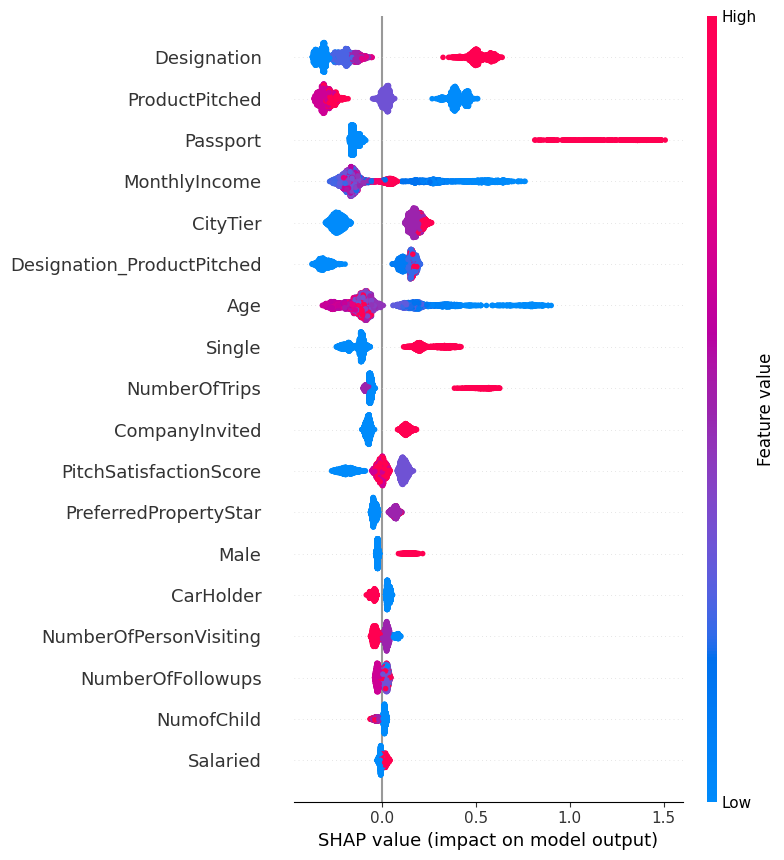

In [56]:
import shap
import lightgbm as lgb
import matplotlib.pyplot as plt
shap.initjs()
explainer = shap.TreeExplainer(model=models[0])
# 横軸：SHAP値 (0からの貢献度、右=プラスの影響)
# 縦軸：特徴量 (上にあるほど重要)
# 色：その特徴の値 (赤=大きい値、青=小さい値)
explainer1 = shap.TreeExplainer(models[0])
shap_values1 = explainer1.shap_values(train.drop("ProdTaken",axis=1))
# ③ summary plotで全体の重要度と分布を見る
shap.summary_plot(shap_values1, train.drop("ProdTaken",axis=1))

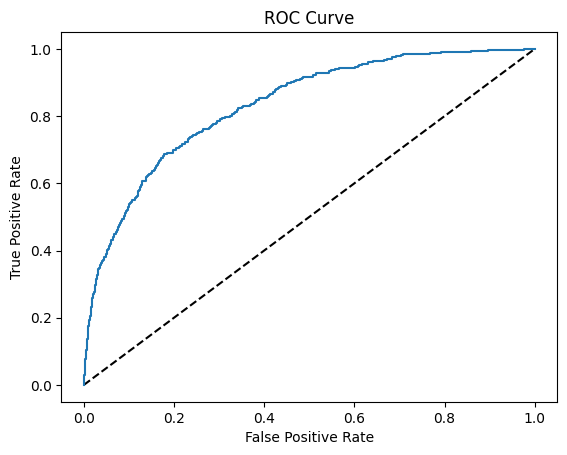

In [57]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(train[TARGET],oof_lgb)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr,label='LogisticRegression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

7. 提出

In [58]:
# submit_sample.csvを読み込みます。
submit = pd.read_csv("/content/sample_submit.csv", header=None)
submit.head(1)

,0,1
0,3489,0.119451


In [59]:
# テストデータを用いて予測します。
predict0 = models[0].predict(test)
predict1 = models[1].predict(test)
predict2 = models[2].predict(test)
predict3 = models[3].predict(test)
predict4 = models[4].predict(test)
predict = (predict0 + predict1 + predict2 + predict3 + predict4) / 5
submit[1] = predict

In [60]:
# 提出
submit.to_csv("submission.csv", index=False, header=None)